In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import math

Here, we will investigate the association of P-sites with mutations (source: humsavar dataset from April, 2022), and their consequence. We first do a brief investigation of the humsavar dataset, before looking into P-sites. Roughly 80,500 records have been retrieved, denoting the affected protein and encoding gene, the unique ID of the variant, the specific change in amino acids, the consequent and a unique identifier for the dbSNP database. If appplicable, a linked disease can also be denoted.

Almost 12,500 proteins have been annotated with a mutation, as well as 73,200 modified sites. Most of the mutations are benign.

In [2]:
humsavar = pd.read_csv("humsavar_parsed_tab.txt", sep="\t")
print(humsavar.shape[0])
humsavar.head()

80517


,Main gene name,ACC_ID,FTId,AA change,Variant category,dbSNP,Disease name
0,A1BG,P04217,VAR_018369,p.His52Arg,LB/B,rs893184,-
1,A1BG,P04217,VAR_018370,p.His395Arg,LB/B,rs2241788,-
2,A1CF,Q9NQ94,VAR_052201,p.Val555Met,LB/B,rs9073,-
3,A1CF,Q9NQ94,VAR_059821,p.Ala558Ser,LB/B,rs11817448,-
4,A2M,P01023,VAR_000012,p.Arg704His,LB/B,rs1800434,-


In [3]:
humsavar["UP_POS"] = humsavar["AA change"].str.extract('(\d+)')
print(humsavar["ACC_ID"].nunique())
print(humsavar.groupby(["ACC_ID", "UP_POS"], as_index=False).agg({"dbSNP":"first"}).shape[0])
print("Disease causing mutations: {}".format(humsavar[humsavar["Variant category"]=="LP/P"].groupby(["ACC_ID", "UP_POS"], as_index=False).agg({"dbSNP": "first"}).shape[0]))
print(("Proteins involved in disease causing mutations: {}".format(humsavar[humsavar["Variant category"]=="LP/P"]["ACC_ID"].nunique())))
print("Benign mutations: {}".format(humsavar[humsavar["Variant category"]=="LB/B"].groupby(["ACC_ID", "UP_POS"], as_index=False).agg({"dbSNP": "first"}).shape[0]))
print(("Proteins involved in benign mutations: {}".format(humsavar[humsavar["Variant category"]=="LB/B"]["ACC_ID"].nunique())))
print("Variants of unknown significance: {}".format(humsavar[humsavar["Variant category"]=="US"].groupby(["ACC_ID", "UP_POS"], as_index=False).agg({"dbSNP": "first"}).shape[0]))
print(("Proteins having variants of unknown significance: {}".format(humsavar[humsavar["Variant category"]=="US"]["ACC_ID"].nunique())))

12947
73256
Disease causing mutations: 27084
Proteins involved in disease causing mutations: 3133
Benign mutations: 38835
Proteins involved in benign mutations: 11679
Variants of unknown significance: 8043
Proteins having variants of unknown significance: 2589


In [4]:
humsavar[humsavar["Variant category"]=="LP/P"].groupby(["ACC_ID"], as_index=False).agg({"dbSNP": "first"}).shape[0]

3133

In [5]:
humsavar[humsavar["Variant category"]=="LB/B"].groupby(["ACC_ID"], as_index=False).agg({"dbSNP": "first"}).shape[0]

11679

In [6]:
humsavar[humsavar["Variant category"]=="US"].groupby(["ACC_ID"], as_index=False).agg({"dbSNP": "first"}).shape[0]

2589

In [7]:
data_site = pd.read_csv("site_data", sep="\t")
print(data_site.shape[0])
data_site.head()

23903


,ACC_ID,UP_POS,tissue,modres,Adipose tissue,B-cells,Blood,Bone,Brain,Breast,...,Small intestine,Synovial tissue,T-cells,Testis,Tooth,Umbilical cord,Ureter,Urinary bladder,Urine,Total
0,A0A075B6H7,30,Lung,T,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,A0A075B6S5,52,Menstrual fluid,S,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,A0A087WXM9,223,Testis,S,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,1
3,A0A0B4J2D5,124,PBMC,S,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,A0A0B4J2D5,145,PBMC,T,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


We extract the modified position (UP_POS column) by extracting the number out of the AA change column, and add a column denoting the full version of Variant category.

In [8]:
humsavar["UP_POS"] = humsavar["AA change"].str.extract('(\d+)')
humsavar.loc[humsavar["Variant category"]=="LP/P", "Annotation"] = "(likely) Pathogenic"
humsavar.loc[humsavar["Variant category"]=="LB/B", "Annotation"] = "(likely) Benign"
humsavar.loc[humsavar["Variant category"]=="US", "Annotation"] = "Unknown significance"
humsavar

,Main gene name,ACC_ID,FTId,AA change,Variant category,dbSNP,Disease name,UP_POS,Annotation
0,A1BG,P04217,VAR_018369,p.His52Arg,LB/B,rs893184,-,52,(likely) Benign
1,A1BG,P04217,VAR_018370,p.His395Arg,LB/B,rs2241788,-,395,(likely) Benign
2,A1CF,Q9NQ94,VAR_052201,p.Val555Met,LB/B,rs9073,-,555,(likely) Benign
3,A1CF,Q9NQ94,VAR_059821,p.Ala558Ser,LB/B,rs11817448,-,558,(likely) Benign
4,A2M,P01023,VAR_000012,p.Arg704His,LB/B,rs1800434,-,704,(likely) Benign
...,...,...,...,...,...,...,...,...,...
80512,-,Q8N402,VAR_042675,p.Thr131Pro,LB/B,rs6519442,-,131,(likely) Benign
80513,-,Q96M66,VAR_039178,p.Arg37His,LB/B,rs350229,-,37,(likely) Benign
80514,-,Q96M66,VAR_039179,p.Arg171Ser,LB/B,rs11648228,-,171,(likely) Benign
80515,-,Q9N2K0,VAR_017799,p.Val81Leu,LB/B,-,-,81,(likely) Benign


Out of the 5 855 proteins in our dataset, 4 106 are present in the humsavar dataset. 27 880 mutation sites have been identified on these proteins. The majority of these sites are annotated as benign (14 004), while 10 600 are annotated as pathogneic. 3 591 are annotated as Unknown Significance. A small subset of sites is annotated with a combination of these (included in the numbers).

In [9]:
mutated_proteins = pd.merge(data_site, humsavar, how="inner", on="ACC_ID")
print(mutated_proteins["ACC_ID"].nunique())
print(mutated_proteins.groupby(["ACC_ID", "UP_POS_y"], as_index=False).agg({"dbSNP": "first"}).shape[0])
print(mutated_proteins.groupby(["ACC_ID", "UP_POS_y", "Annotation"], as_index=False).agg({"dbSNP": "first"})["Annotation"].value_counts())
print(mutated_proteins.shape[0])
print(mutated_proteins["Annotation"].value_counts())

4106
27880
(likely) Benign         14004
(likely) Pathogenic     10600
Unknown significance     3591
Name: Annotation, dtype: int64
189044
(likely) Benign         88598
(likely) Pathogenic     75755
Unknown significance    24691
Name: Annotation, dtype: int64


In [10]:
humsavar["UP_POS"] = humsavar["UP_POS"].astype(int)
humsavar["UP_POS"].dtypes

dtype('int64')

115 proteins have mutations exactly on the modified position, for a 150 sites. Most annotations point towards benign mutations, as was the case for the Humsavar dataset as a whole. Clearly, few proteins are associated with more than one mutation occuring on a P-site. Only 1,96% of the proteins in our dataset is assocaited with a mutation occuring on the P-site itself.

In [11]:
mutated_sites = pd.merge(data_site, humsavar, how="inner", on=["ACC_ID", "UP_POS"])
print(mutated_sites["ACC_ID"].nunique())
print(mutated_sites.groupby(["ACC_ID", "UP_POS"], as_index=False).agg({"dbSNP": "first"}).shape[0])
print(mutated_sites.groupby(["ACC_ID", "UP_POS", "Annotation"], as_index=False).agg({"dbSNP": "first"})["Annotation"].value_counts())
print(mutated_sites["Disease name"].value_counts())
mutated_sites

115
150
(likely) Benign         77
(likely) Pathogenic     52
Unknown significance    23
Name: Annotation, dtype: int64
-                                                                                                                                 89
A sporadic cancer                                                                                                                  9
Amyloidosis, transthyretin-related (AMYL-TTR) [MIM:105210]                                                                         6
Marfan syndrome (MFS) [MIM:154700]                                                                                                 3
Noonan syndrome 5 (NS5) [MIM:611553]                                                                                               3
Neutropenia, severe congenital 1, autosomal dominant (SCN1) [MIM:202700]                                                           3
Pituitary adenoma 4, ACTH-secreting (PITA4) [MIM:219090]                          

,ACC_ID,UP_POS,tissue,modres,Adipose tissue,B-cells,Blood,Bone,Brain,Breast,...,Urinary bladder,Urine,Total,Main gene name,FTId,AA change,Variant category,dbSNP,Disease name,Annotation
0,O14681,319,"Lymph node,Lymph node,Lymph node,Lymph node",T,0,0,0,0,0,0,...,0,0,1,EI24,VAR_065464,p.Thr319Ala,US,rs375652371,Some patients with early onset breast cancer,Unknown significance
1,O14896,424,"Urinary bladder, Colon, Kidney, Liver",S,0,0,0,0,0,0,...,1,0,4,IRF6,VAR_064476,p.Ser424Leu,LP/P,rs387906968,Popliteal pterygium syndrome (PPS) [MIM:119500],(likely) Pathogenic
2,O14994,470,"Blood, Cerebrospinal fluid, Liver, Ovary, Panc...",S,0,0,1,0,1,0,...,0,0,7,SYN3,VAR_068906,p.Ser470Asn,LB/B,rs5998526,-,(likely) Benign
3,O15446,282,"Colon,Colon,Colon,Colon,Colon",T,0,0,0,0,0,0,...,0,0,1,POLR1G,VAR_051876,p.Thr282Ala,LB/B,rs3212989,-,(likely) Benign
4,O43488,255,"Colon,Colon,Colon,Colon,Colon,Colon,Colon,Colo...",S,0,0,0,0,0,0,...,0,0,1,AKR7A2,VAR_048211,p.Ser255Asn,LB/B,rs2231203,-,(likely) Benign
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
164,Q9UQM7,286,"Brain,Brain,Brain",T,0,0,0,0,1,0,...,0,0,1,CAMK2A,VAR_080587,p.Thr286Pro,LP/P,rs1554121872,"Mental retardation, autosomal dominant 53 (MRD...",(likely) Pathogenic
165,Q9Y2X3,508,"Colon,Colon,Colon,Colon",T,0,0,0,0,0,0,...,0,0,1,NOP58,VAR_059464,p.Thr508Pro,LB/B,rs34523815,-,(likely) Benign
166,Q9Y314,168,Blood,T,0,0,1,0,0,0,...,0,0,1,NOSIP,VAR_031169,p.Thr168Met,LB/B,rs17850728,-,(likely) Benign
167,Q9Y490,1227,"PBMC,Urinary bladder, Colon, Kidney, Liver,Lun...",S,0,0,0,0,0,0,...,1,0,6,TLN1,VAR_023751,p.Ser1227Leu,LB/B,rs2295795,-,(likely) Benign


As only a minority of the P-sites are mutated themselves, we will use a five-window range of amino acids (N-terminally and C-terminally of the P-site), and the P-site itself. We thus calculate, for each P-site in our dataframe, what position this would be. We then consecutively merge the each of these 11 possible positions (5 C-terminally of the P-site, 5 N-terminally of the P-site and the P-site itself), with the dataframe containing the mutated positions. We also add a column dneoting how far the mutated residue is from the P-site.

In [12]:
data_site["Pos_min5"] = data_site["UP_POS"] - 5
data_site["Pos_min4"] = data_site["UP_POS"] - 4
data_site["Pos_min3"] = data_site["UP_POS"] - 3
data_site["Pos_min2"] = data_site["UP_POS"] - 2
data_site["Pos_min1"] = data_site["UP_POS"] - 1

data_site["Pos_plus1"] = data_site["UP_POS"] + 1
data_site["Pos_plus2"] = data_site["UP_POS"] + 2
data_site["Pos_plus3"] = data_site["UP_POS"] + 3
data_site["Pos_plus4"] = data_site["UP_POS"] + 4
data_site["Pos_plus5"] = data_site["UP_POS"] + 5

data_site

,ACC_ID,UP_POS,tissue,modres,Adipose tissue,B-cells,Blood,Bone,Brain,Breast,...,Pos_min5,Pos_min4,Pos_min3,Pos_min2,Pos_min1,Pos_plus1,Pos_plus2,Pos_plus3,Pos_plus4,Pos_plus5
0,A0A075B6H7,30,Lung,T,0,0,0,0,0,0,...,25,26,27,28,29,31,32,33,34,35
1,A0A075B6S5,52,Menstrual fluid,S,0,0,0,0,0,0,...,47,48,49,50,51,53,54,55,56,57
2,A0A087WXM9,223,Testis,S,0,0,0,0,0,0,...,218,219,220,221,222,224,225,226,227,228
3,A0A0B4J2D5,124,PBMC,S,0,0,0,0,0,0,...,119,120,121,122,123,125,126,127,128,129
4,A0A0B4J2D5,145,PBMC,T,0,0,0,0,0,0,...,140,141,142,143,144,146,147,148,149,150
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23898,Q9Y6Y0,326,"Lymph node,Lymph node",S,0,0,0,0,0,0,...,321,322,323,324,325,327,328,329,330,331
23899,Q9Y6Y0,336,Colon,S,0,0,0,0,0,0,...,331,332,333,334,335,337,338,339,340,341
23900,Q9Y6Y0,338,"Colon,Colon,Colon,Colon,Colon,Colon,Colon,Colo...",S,0,0,0,0,0,0,...,333,334,335,336,337,339,340,341,342,343
23901,Q9Y6Y8,737,Colon,S,0,0,0,0,0,0,...,732,733,734,735,736,738,739,740,741,742


We first consider only a 2-window of amino acids. We rename the mutated position column to "merge_col", and do the same for each of the 5 positions considered in a 2-window, and merge both dataframes on the condition the positions in both merge_col match for a certain protein. These sub-dataframes for each of the 5 positions are ccombined into one dataframe, data_mut2. This already resulted in more than 400 proteins, considerably more than when considering only the phosphorylated position. The most abundant disease is sporadic cancer if any. Cancer is also mentioned in the disease annotation for at least 76 records (many variations are possible). Most positions are still benign, and most mutations have been found 3 residues away from the phosphorylated residue.

In [13]:
humsavar.rename({"UP_POS": "merge_col"}, axis=1, inplace=True)
data_mut2 = pd.DataFrame({})
for col in ["Pos_min2", "Pos_min1", "UP_POS", "Pos_plus1", "Pos_plus2"]:
    data_site.rename({col: "merge_col"}, axis=1, inplace=True)
    data_sub = pd.merge(data_site, humsavar, how="inner", on=["ACC_ID", "merge_col"])
    data_site.rename({"merge_col": col}, axis=1, inplace=True)
    data_sub.rename({"merge_col": col}, axis=1, inplace=True)
    if col in ["Pos_min2", "Pos_plus2"]:
        data_sub["distance"] = "2"
    elif col in ["Pos_min1", "Pos_plus1"]:
        data_sub["distance"] = "1"
    else:
        data_sub["distance"] = "0"
    data_mut2 = data_mut2.append(data_sub, ignore_index=True)
humsavar.rename({"merge_col": "UP_POS"}, axis=1, inplace=True)
data_mut2

/var/folders/sq/z_sqn7bn61j9sqhwcb08v3tc0000gn/T/ipykernel_1112/1081109907.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_mut2 = data_mut2.append(data_sub, ignore_index=True)
/var/folders/sq/z_sqn7bn61j9sqhwcb08v3tc0000gn/T/ipykernel_1112/1081109907.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_mut2 = data_mut2.append(data_sub, ignore_index=True)
/var/folders/sq/z_sqn7bn61j9sqhwcb08v3tc0000gn/T/ipykernel_1112/1081109907.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_mut2 = data_mut2.append(data_sub, ignore_index=True)
/var/folders/sq/z_sqn7bn61j9sqhwcb08v3tc0000gn/T/ipykernel_1112/1081109907.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a fut

,ACC_ID,UP_POS,tissue,modres,Adipose tissue,B-cells,Blood,Bone,Brain,Breast,...,Pos_plus4,Pos_plus5,Main gene name,FTId,AA change,Variant category,dbSNP,Disease name,Annotation,distance
0,B2RTY4,1364,Colon,S,0,0,0,0,0,0,...,1368,1369,MYO9A,VAR_046172,p.Ser1362Pro,LB/B,rs55738821,-,(likely) Benign,2
1,O14686,4359,Lymph node,S,0,0,0,0,0,0,...,4363,4364,KMT2D,VAR_064377,p.Arg4357Ser,LB/B,rs533214351,-,(likely) Benign,2
2,O15047,915,"Colon,Colon,Colon,Colon,Colon,Colon,Colon,Colo...",S,0,0,0,0,0,0,...,919,920,SETD1A,VAR_083963,p.Arg913Cys,LP/P,-,"Epilepsy, early-onset, with or without develop...",(likely) Pathogenic,2
3,O43663,513,Blood,S,0,0,1,0,0,0,...,517,518,PRC1,VAR_047769,p.Tyr511Cys,LB/B,rs12911192,-,(likely) Benign,2
4,O43707,429,Skin,T,0,0,0,0,0,0,...,433,434,ACTN4,VAR_072116,p.Ala427Thr,LP/P,rs201128110,Focal segmental glomerulosclerosis 1 (FSGS1) [...,(likely) Pathogenic,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1025,Q9UQ35,854,"Blood, Cerebrospinal fluid, Liver, Ovary, Panc...",S,0,0,1,0,1,0,...,858,859,SRRM2,VAR_048868,p.Thr856Arg,LB/B,rs12185191,-,(likely) Benign,2
1026,Q9Y276,181,Lung,Y,0,0,0,0,0,0,...,185,186,BCS1L,VAR_032089,p.Arg183His,LP/P,rs121908577,Bjoernstad syndrome (BJS) [MIM:262000],(likely) Pathogenic,2
1027,Q9Y276,181,Lung,Y,0,0,0,0,0,0,...,185,186,BCS1L,VAR_064617,p.Arg183Cys,LP/P,rs144885874,"Mitochondrial complex III deficiency, nuclear ...",(likely) Pathogenic,2
1028,Q9Y463,273,"Blood,Blood,Lung,Lung,Lung,Lung,Lung,Lung,Lung...",Y,0,0,1,0,1,0,...,277,278,DYRK1B,VAR_040457,p.Gln275Arg,US,-,A metastatic melanoma sample,Unknown significance,2


In [14]:
print(data_mut2["ACC_ID"].nunique())
print(data_mut2.groupby(["ACC_ID", "UP_POS"], as_index=False).agg({"dbSNP": "first"}).shape[0])
data_mut2["Disease name"].value_counts()

413
681


-                                                                           532
A sporadic cancer                                                            41
Amyloidosis, transthyretin-related (AMYL-TTR) [MIM:105210]                   33
Neutropenia, severe congenital 1, autosomal dominant (SCN1) [MIM:202700]     19
Nemaline myopathy 3 (NEM3) [MIM:161800]                                      19
                                                                           ... 
Diamond-Blackfan anemia 1 (DBA1) [MIM:105650]                                 1
Hyperoxaluria primary 1 (HP1) [MIM:259900]                                    1
Otopalatodigital syndrome 1 (OPD1) [MIM:311300]                               1
Diamond-Blackfan anemia 5 (DBA5) [MIM:612528]                                 1
Mitochondrial complex III deficiency, nuclear 1 (MC3DN1) [MIM:124000]         1
Name: Disease name, Length: 173, dtype: int64

In [15]:
data_mut2[data_mut2["Disease name"].str.contains("cancer")].shape[0]

76

In [16]:
data_mut2.groupby(["ACC_ID", "UP_POS", "Annotation"], as_index=False).agg({"dbSNP": "first"})["Annotation"].value_counts()

(likely) Benign         372
(likely) Pathogenic     249
Unknown significance     76
Name: Annotation, dtype: int64

In [17]:
data_mut2["distance"].value_counts()

2    446
1    415
0    169
Name: distance, dtype: int64

We now consider a 5 range window for the mutation to occur (5 C-terminally from the phosphorylated residue, 5 N-terminally, and the phosphorylated residue itself, totalling 11), computed in a similar fashion as before for the 2-window.

In [18]:
data_mut5 = pd.DataFrame({})
humsavar.rename({"UP_POS": "merge_col"}, axis=1, inplace=True)

for col in ["Pos_min5", "Pos_min4", "Pos_min3","Pos_min2", "Pos_min1", "UP_POS", "Pos_plus1", "Pos_plus2", "Pos_plus3",
           "Pos_plus4", "Pos_plus5"]:
    data_site.rename({col: "merge_col"}, axis=1, inplace=True)
    data_sub = pd.merge(data_site, humsavar, how="inner", on=["ACC_ID", "merge_col"])
    data_site.rename({"merge_col": col}, axis=1, inplace=True)
    data_sub.rename({"merge_col": col}, axis=1, inplace=True)
    if col == "Pos_min5":
        data_sub["distance"] = "-5"
    elif col == "Pos_min4":
        data_sub["distance"] = "-4"
    elif col == "Pos_min3":
        data_sub["distance"] = "-3"
    elif col == "Pos_min2":
        data_sub["distance"] = "-2"
    elif col == "Pos_min1":
        data_sub["distance"] = "-1"
    elif col == "Pos_plus5":
        data_sub["distance"] = "5"
    elif col == "Pos_plus4":
        data_sub["distance"] = "4"
    elif col == "Pos_plus3":
        data_sub["distance"] = "3"
    elif col == "Pos_plus2":
        data_sub["distance"] = "2"
    elif col == "Pos_plus1":
        data_sub["distance"] = "1"
    else:
        data_sub["distance"] = "0"
    data_mut5 = data_mut5.append(data_sub, ignore_index=True)
humsavar.rename({"merge_col": "UP_POS"}, axis=1, inplace=True)
data_mut5

/var/folders/sq/z_sqn7bn61j9sqhwcb08v3tc0000gn/T/ipykernel_1112/2914078786.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_mut5 = data_mut5.append(data_sub, ignore_index=True)
/var/folders/sq/z_sqn7bn61j9sqhwcb08v3tc0000gn/T/ipykernel_1112/2914078786.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_mut5 = data_mut5.append(data_sub, ignore_index=True)
/var/folders/sq/z_sqn7bn61j9sqhwcb08v3tc0000gn/T/ipykernel_1112/2914078786.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_mut5 = data_mut5.append(data_sub, ignore_index=True)
/var/folders/sq/z_sqn7bn61j9sqhwcb08v3tc0000gn/T/ipykernel_1112/2914078786.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a fut

,ACC_ID,UP_POS,tissue,modres,Adipose tissue,B-cells,Blood,Bone,Brain,Breast,...,Pos_plus4,Pos_plus5,Main gene name,FTId,AA change,Variant category,dbSNP,Disease name,Annotation,distance
0,O00204,350,Colon,S,0,0,0,0,0,0,...,354,355,SULT2B1,VAR_020888,p.Pro345Leu,LB/B,rs17842463,-,(likely) Benign,-5
1,O43318,415,Colon,T,0,0,0,0,0,0,...,419,420,MAP3K7,VAR_080761,p.Arg410Gln,US,rs201721045,-,Unknown significance,-5
2,O43707,260,"PBMC,PBMC,Skin,Skin,Skin,Skin,Skin,Skin,Skin,S...",Y,0,0,0,0,0,0,...,264,265,ACTN4,VAR_010378,p.Lys255Glu,LP/P,rs121908415,Focal segmental glomerulosclerosis 1 (FSGS1) [...,(likely) Pathogenic,-5
3,O60716,920,"Colon,Colon,Colon,Colon,Colon,Colon,Colon,Colo...",S,0,0,0,0,0,0,...,924,925,CTNND1,VAR_020931,p.Arg915Lys,LB/B,rs11570222,-,(likely) Benign,-5
4,O60832,70,PBMC,T,0,0,0,0,0,0,...,74,75,DKC1,VAR_010079,p.Arg65Thr,LP/P,rs121912301,"Dyskeratosis congenita, X-linked (DKCX) [MIM:3...",(likely) Pathogenic,-5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2324,Q9UI08,242,"NK-cells,NK-cells,Lymph node",S,0,0,0,0,0,0,...,246,247,EVL,VAR_036465,p.Pro247Leu,US,-,A colorectal cancer sample,Unknown significance,5
2325,Q9UK55,56,"Blood,Blood,Lymph node",S,0,0,1,0,0,0,...,60,61,SERPINA10,VAR_020326,p.Ser61Gly,LB/B,rs941591,-,(likely) Benign,5
2326,Q9UKT5,8,"Colon,Colon,Colon,Lymph node,Lymph node",S,0,0,0,0,0,0,...,12,13,FBXO4,VAR_063502,p.Pro13Ser,US,-,Esophagus cancer sample,Unknown significance,5
2327,Q9UNE7,23,"Colon,Colon,Colon,Colon,Colon,Colon,Colon,Colo...",S,0,0,0,0,0,0,...,27,28,STUB1,VAR_072348,p.Glu28Lys,LP/P,-,"Spinocerebellar ataxia, autosomal recessive, 1...",(likely) Pathogenic,5


Slightly more mutations have been found towards the N-terminus (- X, with X a number, in the list below). While for the N-terminus, mutations are more frequently identified further away, this seems slightly less the case for the mutations towards the C-terminus. The differences are relatively small, making solid conclusions difficult to identify.

In [19]:
data_mut5["distance"].value_counts()

-5    252
-4    233
-2    223
2     223
3     217
-1    215
-3    204
4     202
1     200
5     191
0     169
Name: distance, dtype: int64

60 sites are annotated with both "benign" and "pathogenic", or another combination. This could be because of different mutations, and because a mutation on position -1 might be benign while one on position +4 might be pathogenic.

In [20]:
print(data_mut5["ACC_ID"].nunique())
print(data_mut5.groupby(["ACC_ID", "UP_POS"], as_index=False).agg({"dbSNP": "first"}).shape[0])
print(data_mut5.groupby(["ACC_ID", "UP_POS", "Annotation"], as_index=False).agg({"dbSNP": "first"})["Annotation"].value_counts())

712
1345
(likely) Benign         796
(likely) Pathogenic     452
Unknown significance    155
Name: Annotation, dtype: int64


# Frequency of mutation - protein level

We start by considering the mutations on the protein level. How many tissue-specific phosphorylated proteins, tissue aspecific phosphorylated proteins and pervasively phosphorylated proteins are associated with a mutation in our dataset? For this, we read in the files of the three different categories and merge them on the unique protein identified ID column or ACC_ID.

In [21]:
tspec_proteins = pd.read_csv("1.1 tissue-specific proteins.tsv", sep="\t")
taspec_proteins = pd.read_csv("1.1 non tissue-specific proteins.tsv", sep="\t")
gen_proteins = pd.read_csv("1.1 general P proteins", sep="\t")

In [22]:
tspec_mut = pd.merge(tspec_proteins["ACC_ID"], data_mut5, how="inner", on=["ACC_ID"])
tspec_mut

,ACC_ID,UP_POS,tissue,modres,Adipose tissue,B-cells,Blood,Bone,Brain,Breast,...,Pos_plus4,Pos_plus5,Main gene name,FTId,AA change,Variant category,dbSNP,Disease name,Annotation,distance
0,A6NER3,10,"Lung,Lung,Lung",Y,0,0,0,0,0,0,...,14,15,GAGE12J,VAR_037385,p.Tyr9Cys,LB/B,rs7064096,-,(likely) Benign,-1
1,A6NER3,10,"Lung,Lung,Lung",Y,0,0,0,0,0,0,...,14,15,GAGE12J,VAR_037386,p.Arg13Ser,LB/B,rs7064105,-,(likely) Benign,3
2,O00204,350,Colon,S,0,0,0,0,0,0,...,354,355,SULT2B1,VAR_020888,p.Pro345Leu,LB/B,rs17842463,-,(likely) Benign,-5
3,O14773,508,"PBMC,PBMC,PBMC,PBMC,PBMC",Y,0,0,0,0,0,0,...,512,513,TPP1,VAR_066890,p.Asn504Tyr,LP/P,-,"Ceroid lipofuscinosis, neuronal, 2 (CLN2) [MIM...",(likely) Pathogenic,-4
4,O14880,46,Placenta,T,0,0,0,0,0,0,...,50,51,MGST3,VAR_012062,p.Pro48Ser,LB/B,rs1802088,-,(likely) Benign,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,Q9Y276,181,Lung,Y,0,0,0,0,0,0,...,185,186,BCS1L,VAR_032090,p.Arg184Cys,LP/P,rs121908578,"Mitochondrial complex III deficiency, nuclear ...",(likely) Pathogenic,3
196,Q9Y282,116,Lymph node,S,0,0,0,0,0,0,...,120,121,ERGIC3,VAR_048939,p.Ile113Leu,LB/B,rs35505616,-,(likely) Benign,-3
197,Q9Y4C1,445,"Colon,Colon,Colon,Colon,Colon,Colon,Colon,Colon",S,0,0,0,0,0,0,...,449,450,KDM3A,VAR_055977,p.Ser447Pro,LB/B,rs34605051,-,(likely) Benign,2
198,Q9Y4U1,275,"Colon,Colon,Colon,Colon",S,0,0,0,0,0,0,...,279,280,MMACHC,VAR_038805,p.Ser271Gly,LB/B,rs35219601,-,(likely) Benign,-4


In [23]:
taspec_mut = pd.merge(taspec_proteins["ACC_ID"], data_mut5, how="inner", on=["ACC_ID"])
taspec_mut

,ACC_ID,UP_POS,tissue,modres,Adipose tissue,B-cells,Blood,Bone,Brain,Breast,...,Pos_plus4,Pos_plus5,Main gene name,FTId,AA change,Variant category,dbSNP,Disease name,Annotation,distance
0,A0M8Q6,31,"Nasal polyps, Palatine tonsils, Parotid gland,...",S,0,0,0,0,0,0,...,35,36,IGLC7,VAR_077896,p.Asn34Tyr,LB/B,-,-,(likely) Benign,3
1,A1L390,1040,Colon,S,0,0,0,0,0,0,...,1044,1045,PLEKHG3,VAR_035330,p.Arg1036Trp,LB/B,rs229649,-,(likely) Benign,-4
2,A1L390,1037,Colon,S,0,0,0,0,0,0,...,1041,1042,PLEKHG3,VAR_035330,p.Arg1036Trp,LB/B,rs229649,-,(likely) Benign,-1
3,B2RTY4,1364,Colon,S,0,0,0,0,0,0,...,1368,1369,MYO9A,VAR_046172,p.Ser1362Pro,LB/B,rs55738821,-,(likely) Benign,-2
4,O00160,961,Umbilical cord,S,0,0,0,0,0,0,...,965,966,MYO1F,VAR_056179,p.Pro960Leu,LB/B,rs2288411,-,(likely) Benign,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
673,Q9Y2U8,261,"Lymph node,Lymph node",S,0,0,0,0,0,0,...,265,266,LEMD3,VAR_034605,p.Asp260Tyr,LB/B,rs7487311,-,(likely) Benign,-1
674,Q9Y314,168,Blood,T,0,0,1,0,0,0,...,172,173,NOSIP,VAR_031169,p.Thr168Met,LB/B,rs17850728,-,(likely) Benign,0
675,Q9Y4K4,335,"Colon,Colon,Colon,Colon,Colon,Colon,Colon,Colo...",S,0,0,0,0,0,0,...,339,340,MAP4K5,VAR_040747,p.Ala334Thr,LB/B,rs12881869,-,(likely) Benign,-1
676,Q9Y4K4,333,"Colon,Colon,Colon,Colon,Colon,Colon,Colon,Colon",T,0,0,0,0,0,0,...,337,338,MAP4K5,VAR_040747,p.Ala334Thr,LB/B,rs12881869,-,(likely) Benign,1


In [24]:
gen_mut = pd.merge(gen_proteins["ACC_ID"], data_mut5, how="inner", on=["ACC_ID"])
gen_mut

,ACC_ID,UP_POS,tissue,modres,Adipose tissue,B-cells,Blood,Bone,Brain,Breast,...,Pos_plus4,Pos_plus5,Main gene name,FTId,AA change,Variant category,dbSNP,Disease name,Annotation,distance
0,O14523,417,"Blood, Cerebrospinal fluid, Liver, Ovary, Panc...",T,0,0,1,0,1,0,...,421,422,C2CD2L,VAR_028797,p.Arg413Trp,LB/B,rs2239896,-,(likely) Benign,-4
1,O14523,411,"Blood, Cerebrospinal fluid, Liver, Ovary, Panc...",S,0,0,1,0,1,0,...,415,416,C2CD2L,VAR_028797,p.Arg413Trp,LB/B,rs2239896,-,(likely) Benign,2
2,O14639,433,"Liver,Liver,PBMC,PBMC,PBMC,PBMC,PBMC,Pancreas,...",T,0,0,1,0,1,0,...,437,438,ABLIM1,VAR_050141,p.Pro434Thr,LB/B,rs11593544,-,(likely) Benign,1
3,O14639,431,"Liver,Liver,Liver,PBMC,PBMC,PBMC,PBMC,PBMC,PBM...",S,0,1,1,0,1,0,...,435,436,ABLIM1,VAR_050141,p.Pro434Thr,LB/B,rs11593544,-,(likely) Benign,3
4,O14639,429,"Colon,Colon,Colon,Colon,Colon,Colon,Colon,Lymp...",T,0,0,0,0,0,0,...,433,434,ABLIM1,VAR_050141,p.Pro434Thr,LB/B,rs11593544,-,(likely) Benign,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1446,Q9Y2X3,508,"Colon,Colon,Colon,Colon",T,0,0,0,0,0,0,...,512,513,NOP58,VAR_059464,p.Thr508Pro,LB/B,rs34523815,-,(likely) Benign,0
1447,Q9Y463,273,"Blood,Blood,Lung,Lung,Lung,Lung,Lung,Lung,Lung...",Y,0,0,1,0,1,0,...,277,278,DYRK1B,VAR_040457,p.Gln275Arg,US,-,A metastatic melanoma sample,Unknown significance,2
1448,Q9Y490,1227,"PBMC,Urinary bladder, Colon, Kidney, Liver,Lun...",S,0,0,0,0,0,0,...,1231,1232,TLN1,VAR_023751,p.Ser1227Leu,LB/B,rs2295795,-,(likely) Benign,0
1449,Q9Y618,2005,Colon,S,0,0,0,0,0,0,...,2009,2010,NCOR2,VAR_060074,p.Pro2001Ser,LB/B,rs2230944,-,(likely) Benign,-4


Especially tissue-specific phosphorylated proteins seem less associated with mutaiton. Not only less proteins could be found with a mutation within 5 redidues of a P-site, also less mutations have been found (ie, a certain tissue-specific phosphorylated protein is most frequently associated with a single mutated site, as opposed to multiple mutated sites for pervasively phosphorylated proteins.

In [25]:
print(tspec_mut["ACC_ID"].nunique())
print(taspec_mut["ACC_ID"].nunique())
print(gen_mut["ACC_ID"].nunique())

133
245
334


In [26]:
print(tspec_mut.groupby(["ACC_ID", "UP_POS"], as_index=False).agg({"dbSNP": "first"}).shape[0])
print(taspec_mut.groupby(["ACC_ID", "UP_POS"], as_index=False).agg({"dbSNP": "first"}).shape[0])
print(gen_mut.groupby(["ACC_ID", "UP_POS"], as_index=False).agg({"dbSNP": "first"}).shape[0])

151
376
818


In [27]:
list_tissues_STY = ["Adipose tissue", "B-cells", "Blood", "Bone", "Brain", "Breast",
                "Cerebrospinal fluid", "Cervix", "Colon",
                "Dental plaque", "Esophagus", "Eye", "Follicular fluid", "Heart", "Hela", "Kidney",
                "Liver", "Lung", "Lymph node", "Menstrual fluid", "Monocytes", "Nasal polyps",
               "NK-cells", "Ovary", "Pancreas", "Palatine tonsils", "Parotid gland", "PBMC",
                "Peritoneal dialysis fluid", "Placenta", "Skeletal muscle", "Skin", "Small intestine",
               "Synovial tissue", "T-cells", "Testis", "Tooth", "Umbilical cord", "Ureter",
               "Urinary bladder", "Urine"]

In [28]:
print(humsavar["ACC_ID"].nunique())
print(humsavar[humsavar["Variant category"]=="LP/P"]["ACC_ID"].nunique())
print(humsavar[humsavar["Variant category"]=="LB/B"]["ACC_ID"].nunique())
print(humsavar[humsavar["Variant category"]=="US"]["ACC_ID"].nunique())

12947
3133
11679
2589


Next, we count, per tissue, the amount of proteins for which at least one mutation could be found within a five-residue window of a mutation. No tissue showed more such proteins then expected, based on the amount of proteins identified in a tissue. These calculations were done per category of proteins.

<AxesSubplot:xlabel='Tissue'>

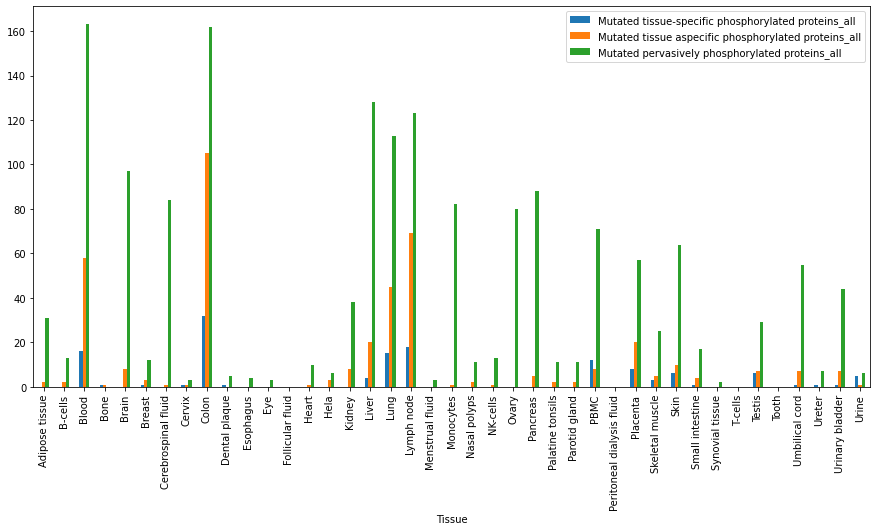

In [29]:
mut_prot_tissue = pd.DataFrame({"Tissue": list_tissues_STY})
list_tspec = []
list_taspec = []
list_gen = []
for tissue in list_tissues_STY:
    count_tspec = tspec_mut.loc[tspec_mut[tissue]==1, "ACC_ID"].nunique()
    count_taspec = taspec_mut.loc[taspec_mut[tissue]==1, "ACC_ID"].nunique()
    count_gen = gen_mut.loc[gen_mut[tissue]==1, "ACC_ID"].nunique()
    list_tspec.append(count_tspec)
    list_taspec.append(count_taspec)
    list_gen.append(count_gen)
mut_prot_tissue["Mutated tissue-specific phosphorylated proteins_all"] = list_tspec
mut_prot_tissue["Mutated tissue aspecific phosphorylated proteins_all"] = list_taspec
mut_prot_tissue["Mutated pervasively phosphorylated proteins_all"] = list_gen
mut_prot_tissue.plot(kind="bar", figsize=(15,7), x="Tissue")
#plt.savefig("Humsavar_abs_all_mutated_proteins.png", format="png", bbox_inches="tight")

In [30]:
prot_three_cat = pd.read_csv("number of three categories per tissue.tsv", sep="\t")
prot_three_cat.head()

,Tissue,number of tissue-specific proteins,number of non tissue-specific proteins,number of generally expressed proteins,Total
0,Adipose tissue,0,39,311,350
1,B-cells,4,27,202,233
2,Blood,241,966,1530,2737
3,Bone,1,1,9,11
4,Brain,19,56,951,1026


Here, we show the percentage proteins associated with a mutation compared to the total amount of proteins, per category, per tissue. While this percentage varies a bit, only low represented tissues show high or low percentages.

<AxesSubplot:title={'center':'Percentage mutated proteins'}, xlabel='Tissue'>

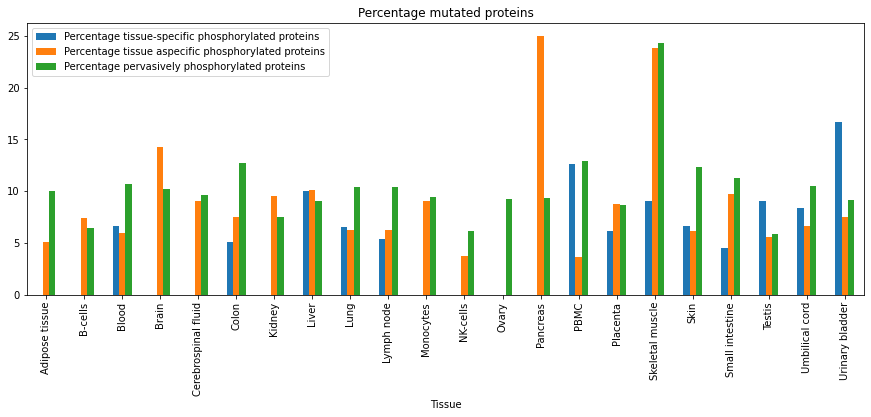

In [31]:
mut_prot_tissue_ratio = prot_three_cat.copy()
mut_prot_tissue_ratio["Percentage tissue-specific phosphorylated proteins"] = mut_prot_tissue["Mutated tissue-specific phosphorylated proteins_all"]*100/mut_prot_tissue_ratio["number of tissue-specific proteins"]
mut_prot_tissue_ratio["Percentage tissue aspecific phosphorylated proteins"] = mut_prot_tissue["Mutated tissue aspecific phosphorylated proteins_all"]*100/mut_prot_tissue_ratio["number of non tissue-specific proteins"]
mut_prot_tissue_ratio["Percentage pervasively phosphorylated proteins"] = mut_prot_tissue["Mutated pervasively phosphorylated proteins_all"]*100/mut_prot_tissue_ratio["number of generally expressed proteins"]
mut_prot_tissue_ratio[((mut_prot_tissue_ratio["number of tissue-specific proteins"]>=100)|
                     (mut_prot_tissue_ratio["number of non tissue-specific proteins"]>=100)|
                     (mut_prot_tissue_ratio["number of generally expressed proteins"]>=100))][["Tissue", "Percentage tissue-specific phosphorylated proteins",
                                                                                          "Percentage tissue aspecific phosphorylated proteins", 
                                                                                          "Percentage pervasively phosphorylated proteins"]].plot(kind="bar", figsize=(15,5), x="Tissue", title="Percentage mutated proteins")
#plt.savefig("Humsavar_ratio_all_mutated_proteins.png", format="png", bbox_inches="tight")

We now repeat the same calculations on the absolute level, per effect of the mutation: benign, pathogenic and unknown significance.

<AxesSubplot:xlabel='Tissue'>

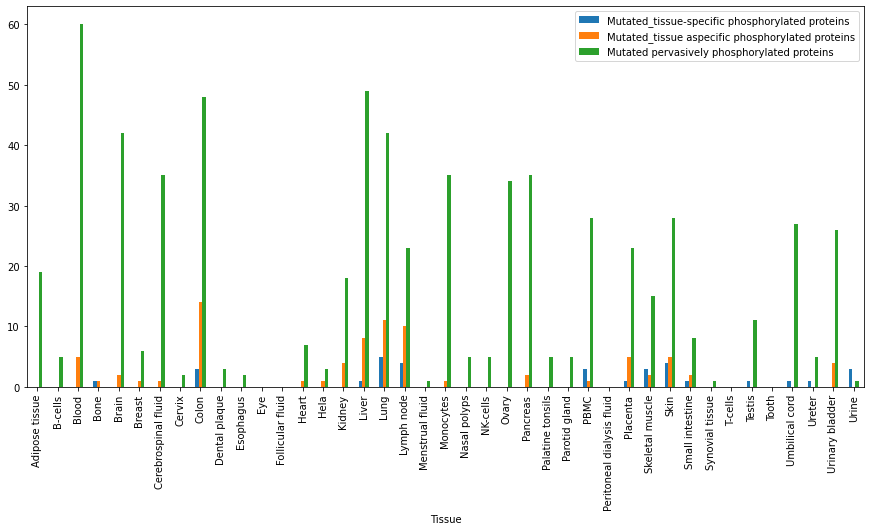

In [32]:
mut_prot_tissue_path = pd.DataFrame({"Tissue": list_tissues_STY})
list_tspec = []
list_taspec = []
list_gen = []
for tissue in list_tissues_STY:
    count_tspec = tspec_mut.loc[(tspec_mut[tissue]==1)&(tspec_mut["Variant category"]=="LP/P"), "ACC_ID"].nunique()
    count_taspec = taspec_mut.loc[(taspec_mut[tissue]==1)&(taspec_mut["Variant category"]=="LP/P"), "ACC_ID"].nunique()
    count_gen = gen_mut.loc[(gen_mut[tissue]==1)&(gen_mut["Variant category"]=="LP/P"), "ACC_ID"].nunique()
    list_tspec.append(count_tspec)
    list_taspec.append(count_taspec)
    list_gen.append(count_gen)
mut_prot_tissue_path["Mutated_tissue-specific phosphorylated proteins"] = list_tspec
mut_prot_tissue_path["Mutated_tissue aspecific phosphorylated proteins"] = list_taspec
mut_prot_tissue_path["Mutated pervasively phosphorylated proteins"] = list_gen
mut_prot_tissue_path.plot(kind="bar", figsize=(15,7), x="Tissue")

In [33]:
mut_prot_tissue_ratio_path = mut_prot_tissue[["Tissue", "Mutated tissue-specific phosphorylated proteins_all", "Mutated tissue aspecific phosphorylated proteins_all", "Mutated pervasively phosphorylated proteins_all"]].copy()
mut_prot_tissue_ratio_path["Ratio tissue-specific phosphorylated proteins (pathogenic mutation)"] = mut_prot_tissue_path["Mutated_tissue-specific phosphorylated proteins"]*100/mut_prot_tissue_ratio_path["Mutated tissue-specific phosphorylated proteins_all"]
mut_prot_tissue_ratio_path["Ratio tissue aspecific phosphorylated proteins (pathogenic mutation)"] = mut_prot_tissue_path["Mutated_tissue aspecific phosphorylated proteins"]*100/mut_prot_tissue_ratio_path["Mutated tissue aspecific phosphorylated proteins_all"]
mut_prot_tissue_ratio_path["Ratio pervasively phosphorylated proteins (pathogenic mutation)"] = mut_prot_tissue_path["Mutated pervasively phosphorylated proteins"]*100/mut_prot_tissue_ratio_path["Mutated pervasively phosphorylated proteins_all"]

In [34]:
print(mut_prot_tissue_ratio_path["Ratio tissue-specific phosphorylated proteins (pathogenic mutation)"].describe())
print(mut_prot_tissue_ratio_path["Ratio tissue aspecific phosphorylated proteins (pathogenic mutation)"].describe())
print(mut_prot_tissue_ratio_path["Ratio pervasively phosphorylated proteins (pathogenic mutation)"].describe())

count     19.000000
mean      40.566520
std       40.929541
min        0.000000
25%        4.687500
50%       25.000000
75%       83.333333
max      100.000000
Name: Ratio tissue-specific phosphorylated proteins (pathogenic mutation), dtype: float64
count     30.000000
mean      30.573358
std       33.327806
min        0.000000
25%        0.000000
50%       24.722222
75%       47.500000
max      100.000000
Name: Ratio tissue aspecific phosphorylated proteins (pathogenic mutation), dtype: float64
count    36.000000
mean     44.090533
std      14.255071
min       0.000000
25%      38.416466
50%      43.524485
75%      50.000000
max      71.428571
Name: Ratio pervasively phosphorylated proteins (pathogenic mutation), dtype: float64


In [35]:
whisker_tspec = 1.5*(83.33-4.68)
whisker_taspec = 1.5*(47.5)
whisker_gen = 1.5*(50-38.42)
print(whisker_tspec, whisker_taspec, whisker_gen)

117.97500000000001 71.25 17.369999999999997


Here, only tissues for which at least one of the categories exceeds 1.5 times the interquartile range for that category are shown.

<AxesSubplot:title={'center':'Ratio proteins having pathogenic mutation out of proteins having mutation'}, xlabel='Tissue'>

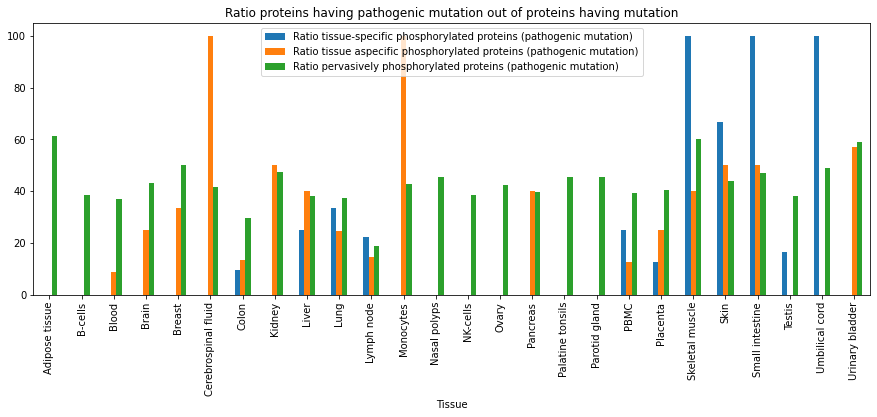

In [36]:
mut_prot_tissue_ratio_path[(((mut_prot_tissue_ratio_path["Ratio tissue-specific phosphorylated proteins (pathogenic mutation)"]>=whisker_tspec)&(mut_prot_tissue_ratio_path["Mutated tissue-specific phosphorylated proteins_all"]>10))|
                     ((mut_prot_tissue_ratio_path["Ratio tissue aspecific phosphorylated proteins (pathogenic mutation)"]>=whisker_taspec)&(mut_prot_tissue_ratio_path["Mutated tissue aspecific phosphorylated proteins_all"]>10))|
                     ((mut_prot_tissue_ratio_path["Ratio pervasively phosphorylated proteins (pathogenic mutation)"]>=whisker_gen)&(mut_prot_tissue_ratio_path["Mutated pervasively phosphorylated proteins_all"]>10)))][["Tissue", "Ratio tissue-specific phosphorylated proteins (pathogenic mutation)",
                                                                                          "Ratio tissue aspecific phosphorylated proteins (pathogenic mutation)", 
                                                                                          "Ratio pervasively phosphorylated proteins (pathogenic mutation)"]].plot(kind="bar", figsize=(15,5), x="Tissue", title="Ratio proteins having pathogenic mutation out of proteins having mutation")
#plt.savefig("Humsavar_ratio_pathmutated_proteins.png", format="png", bbox_inches="tight")

In [37]:
mut_prot_tissue_ratio_path

,Tissue,Mutated tissue-specific phosphorylated proteins_all,Mutated tissue aspecific phosphorylated proteins_all,Mutated pervasively phosphorylated proteins_all,Ratio tissue-specific phosphorylated proteins (pathogenic mutation),Ratio tissue aspecific phosphorylated proteins (pathogenic mutation),Ratio pervasively phosphorylated proteins (pathogenic mutation)
0,Adipose tissue,0,2,31,NaN,0.000000,61.290323
1,B-cells,0,2,13,NaN,0.000000,38.461538
2,Blood,16,58,163,0.000000,8.620690,36.809816
3,Bone,1,1,0,100.000000,100.000000,NaN
4,Brain,0,8,97,NaN,25.000000,43.298969
5,Breast,1,3,12,0.000000,33.333333,50.000000
6,Cerebrospinal fluid,0,1,84,NaN,100.000000,41.666667
7,Cervix,1,1,3,0.000000,0.000000,66.666667
8,Colon,32,105,162,9.375000,13.333333,29.629630
9,Dental plaque,1,0,5,0.000000,NaN,60.000000


<AxesSubplot:xlabel='Tissue'>

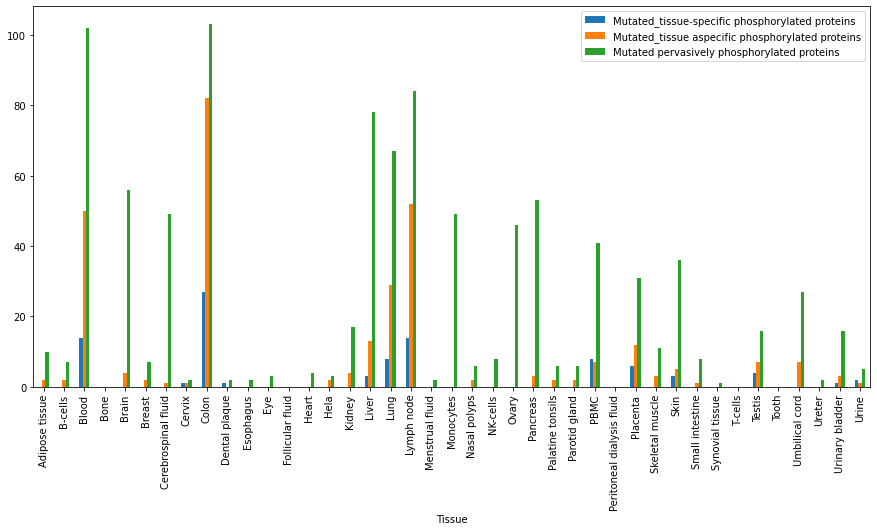

In [38]:
mut_prot_tissue_ben = pd.DataFrame({"Tissue": list_tissues_STY})
list_tspec = []
list_taspec = []
list_gen = []
for tissue in list_tissues_STY:
    count_tspec = tspec_mut.loc[(tspec_mut[tissue]==1)&(tspec_mut["Variant category"]=="LB/B"), "ACC_ID"].nunique()
    count_taspec = taspec_mut.loc[(taspec_mut[tissue]==1)&(taspec_mut["Variant category"]=="LB/B"), "ACC_ID"].nunique()
    count_gen = gen_mut.loc[(gen_mut[tissue]==1)&(gen_mut["Variant category"]=="LB/B"), "ACC_ID"].nunique()
    list_tspec.append(count_tspec)
    list_taspec.append(count_taspec)
    list_gen.append(count_gen)
mut_prot_tissue_ben["Mutated_tissue-specific phosphorylated proteins"] = list_tspec
mut_prot_tissue_ben["Mutated_tissue aspecific phosphorylated proteins"] = list_taspec
mut_prot_tissue_ben["Mutated pervasively phosphorylated proteins"] = list_gen
mut_prot_tissue_ben.plot(kind="bar", figsize=(15,7), x="Tissue")

In [39]:
mut_prot_tissue_ratio_ben = mut_prot_tissue[["Tissue", "Mutated tissue-specific phosphorylated proteins_all", "Mutated tissue aspecific phosphorylated proteins_all", "Mutated pervasively phosphorylated proteins_all"]].copy()
mut_prot_tissue_ratio_ben["Ratio tissue-specific phosphorylated proteins (benign mutation)"] = mut_prot_tissue_ben["Mutated_tissue-specific phosphorylated proteins"]*100/mut_prot_tissue_ratio_ben["Mutated tissue-specific phosphorylated proteins_all"]
mut_prot_tissue_ratio_ben["Ratio tissue aspecific phosphorylated proteins (benign mutation)"] = mut_prot_tissue_ben["Mutated_tissue aspecific phosphorylated proteins"]*100/mut_prot_tissue_ratio_ben["Mutated tissue aspecific phosphorylated proteins_all"]
mut_prot_tissue_ratio_ben["Ratio pervasively phosphorylated proteins (benign mutation)"] = mut_prot_tissue_ben["Mutated pervasively phosphorylated proteins"]*100/mut_prot_tissue_ratio_ben["Mutated pervasively phosphorylated proteins_all"]

In [40]:
print(mut_prot_tissue_ratio_ben["Ratio tissue-specific phosphorylated proteins (benign mutation)"].describe())
print(mut_prot_tissue_ratio_ben["Ratio tissue aspecific phosphorylated proteins (benign mutation)"].describe())
print(mut_prot_tissue_ratio_ben["Ratio pervasively phosphorylated proteins (benign mutation)"].describe())

count     19.000000
mean      51.385234
std       39.256778
min        0.000000
25%        0.000000
50%       66.666667
75%       81.076389
max      100.000000
Name: Ratio tissue-specific phosphorylated proteins (benign mutation), dtype: float64
count     30.000000
mean      66.259979
std       33.826836
min        0.000000
25%       50.000000
50%       66.666667
75%      100.000000
max      100.000000
Name: Ratio tissue aspecific phosphorylated proteins (benign mutation), dtype: float64
count     36.000000
mean      55.496760
std       13.098420
min       28.571429
25%       49.772727
50%       55.711207
75%       60.404830
max      100.000000
Name: Ratio pervasively phosphorylated proteins (benign mutation), dtype: float64


In [41]:
whisker_tspec = 1.5*(81.08)
whisker_taspec = 1.5*(100-50)
whisker_gen = 1.5*(60.4-49.77)
print(whisker_tspec, whisker_taspec, whisker_gen)

121.62 75.0 15.944999999999993


<AxesSubplot:title={'center':'Ratio proteins having benign mutation out of proteins having mutation'}, xlabel='Tissue'>

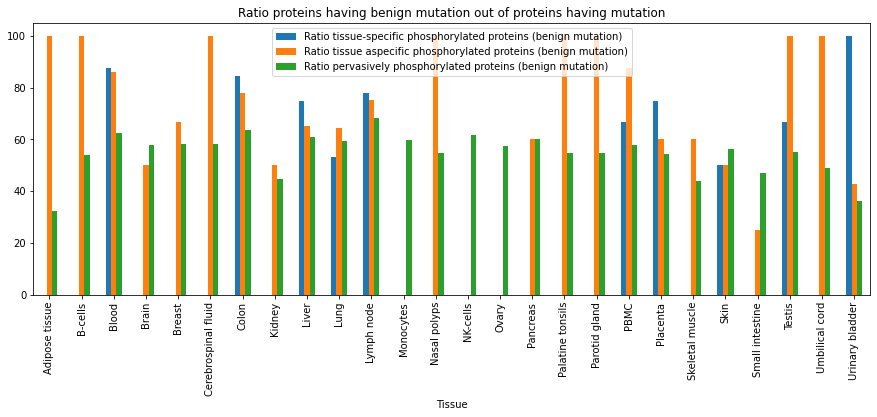

In [42]:
mut_prot_tissue_ratio_ben[(((mut_prot_tissue_ratio_ben["Ratio tissue-specific phosphorylated proteins (benign mutation)"]>=whisker_tspec)&(mut_prot_tissue_ratio_ben["Mutated tissue-specific phosphorylated proteins_all"]>10))|
                     ((mut_prot_tissue_ratio_ben["Ratio tissue aspecific phosphorylated proteins (benign mutation)"]>=whisker_taspec)&(mut_prot_tissue_ratio_ben["Mutated tissue aspecific phosphorylated proteins_all"]>10))|
                     ((mut_prot_tissue_ratio_ben["Ratio pervasively phosphorylated proteins (benign mutation)"]>=whisker_gen)&(mut_prot_tissue_ratio_ben["Mutated pervasively phosphorylated proteins_all"]>10)))][["Tissue", "Ratio tissue-specific phosphorylated proteins (benign mutation)",
                                                                                          "Ratio tissue aspecific phosphorylated proteins (benign mutation)", 
                                                                                          "Ratio pervasively phosphorylated proteins (benign mutation)"]].plot(kind="bar", figsize=(15,5), x="Tissue", title="Ratio proteins having benign mutation out of proteins having mutation")
#plt.savefig("Humsavar_ratio_ben_mutated_proteins.png", format="png", bbox_inches="tight")

<AxesSubplot:xlabel='Tissue'>

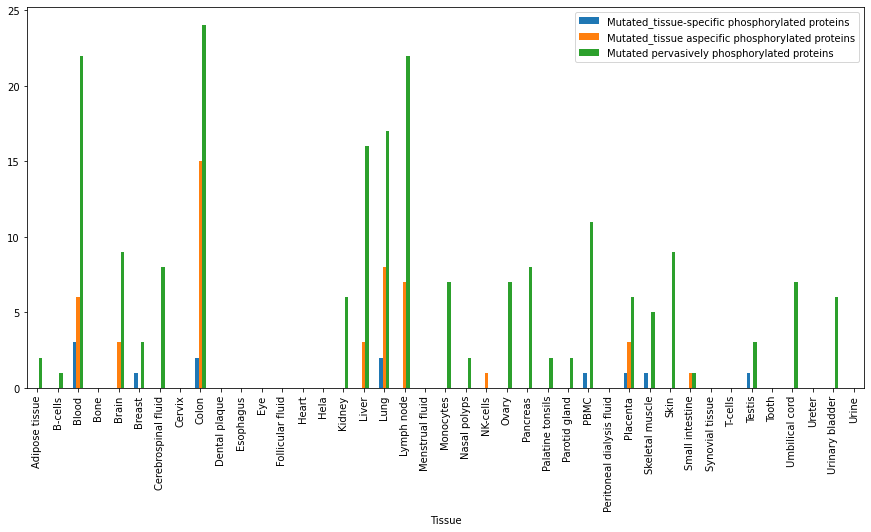

In [43]:
mut_prot_tissue_us = pd.DataFrame({"Tissue": list_tissues_STY})
list_tspec = []
list_taspec = []
list_gen = []
for tissue in list_tissues_STY:
    count_tspec = tspec_mut.loc[(tspec_mut[tissue]==1)&(tspec_mut["Variant category"]=="US"), "ACC_ID"].nunique()
    count_taspec = taspec_mut.loc[(taspec_mut[tissue]==1)&(taspec_mut["Variant category"]=="US"), "ACC_ID"].nunique()
    count_gen = gen_mut.loc[(gen_mut[tissue]==1)&(gen_mut["Variant category"]=="US"), "ACC_ID"].nunique()
    list_tspec.append(count_tspec)
    list_taspec.append(count_taspec)
    list_gen.append(count_gen)
mut_prot_tissue_us["Mutated_tissue-specific phosphorylated proteins"] = list_tspec
mut_prot_tissue_us["Mutated_tissue aspecific phosphorylated proteins"] = list_taspec
mut_prot_tissue_us["Mutated pervasively phosphorylated proteins"] = list_gen
mut_prot_tissue_us.plot(kind="bar", figsize=(15,7), x="Tissue")

In [44]:
mut_prot_tissue_ratio_us = mut_prot_tissue[["Tissue", "Mutated tissue-specific phosphorylated proteins_all", "Mutated tissue aspecific phosphorylated proteins_all", "Mutated pervasively phosphorylated proteins_all"]].copy()
mut_prot_tissue_ratio_us["Ratio tissue-specific phosphorylated proteins (unknown significance)"] = mut_prot_tissue_us["Mutated_tissue-specific phosphorylated proteins"]*100/mut_prot_tissue_ratio_us["Mutated tissue-specific phosphorylated proteins_all"]
mut_prot_tissue_ratio_us["Ratio tissue aspecific phosphorylated proteins (unknown significance)"] = mut_prot_tissue_us["Mutated_tissue aspecific phosphorylated proteins"]*100/mut_prot_tissue_ratio_us["Mutated tissue aspecific phosphorylated proteins_all"]
mut_prot_tissue_ratio_us["Ratio pervasively phosphorylated proteins (unknown significance)"] = mut_prot_tissue_us["Mutated pervasively phosphorylated proteins"]*100/mut_prot_tissue_ratio_us["Mutated pervasively phosphorylated proteins_all"]

In [45]:
print(mut_prot_tissue_ratio_us["Ratio tissue-specific phosphorylated proteins (unknown significance)"].describe())
print(mut_prot_tissue_ratio_us["Ratio tissue aspecific phosphorylated proteins (unknown significance)"].describe())
print(mut_prot_tissue_ratio_us["Ratio pervasively phosphorylated proteins (unknown significance)"].describe())

count     19.000000
mean      11.008772
std       23.428755
min        0.000000
25%        0.000000
50%        0.000000
75%       12.916667
max      100.000000
Name: Ratio tissue-specific phosphorylated proteins (unknown significance), dtype: float64
count     30.000000
mean       8.168442
std       19.660579
min        0.000000
25%        0.000000
50%        0.000000
75%       10.294853
max      100.000000
Name: Ratio tissue aspecific phosphorylated proteins (unknown significance), dtype: float64
count    36.000000
mean      9.196480
std       7.315896
min       0.000000
25%       0.000000
50%       9.401080
75%      14.872173
max      25.000000
Name: Ratio pervasively phosphorylated proteins (unknown significance), dtype: float64


In [46]:
whisker_tspec = 1.5*(12.91)
whisker_taspec = 1.5*(10.29)
whisker_gen = 1.5*(14.87)
print(whisker_tspec, whisker_taspec, whisker_gen)

19.365000000000002 15.434999999999999 22.305


<AxesSubplot:title={'center':'Ratio proteins having unknown significance out of proteins having mutation'}, xlabel='Tissue'>

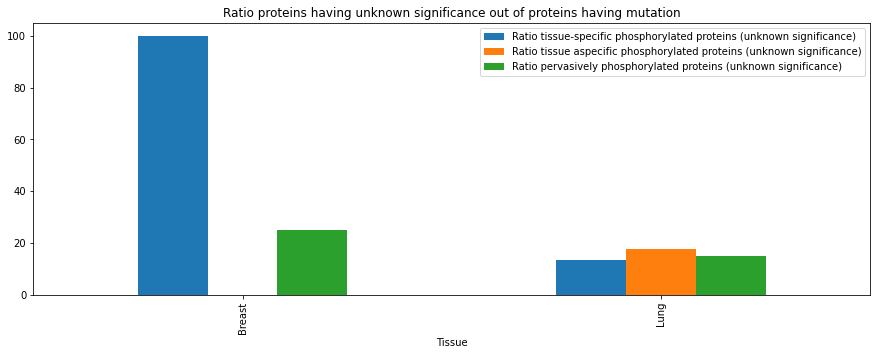

In [47]:
mut_prot_tissue_ratio_us[(((mut_prot_tissue_ratio_us["Ratio tissue-specific phosphorylated proteins (unknown significance)"]>=whisker_tspec)&(mut_prot_tissue_ratio_us["Mutated tissue-specific phosphorylated proteins_all"]>10))|
                     ((mut_prot_tissue_ratio_us["Ratio tissue aspecific phosphorylated proteins (unknown significance)"]>=whisker_taspec)&(mut_prot_tissue_ratio_us["Mutated tissue aspecific phosphorylated proteins_all"]>10))|
                     ((mut_prot_tissue_ratio_us["Ratio pervasively phosphorylated proteins (unknown significance)"]>=whisker_gen)&(mut_prot_tissue_ratio_us["Mutated pervasively phosphorylated proteins_all"]>10)))][["Tissue", "Ratio tissue-specific phosphorylated proteins (unknown significance)",
                                                                                          "Ratio tissue aspecific phosphorylated proteins (unknown significance)", 
                                                                                          "Ratio pervasively phosphorylated proteins (unknown significance)"]].plot(kind="bar", figsize=(15,5), x="Tissue", title="Ratio proteins having unknown significance out of proteins having mutation")
#plt.savefig("Humsavar_ratio_us_mutated_proteins.png", format="png", bbox_inches="tight")

In [48]:
mut_prot_tissue_ratio_us

,Tissue,Mutated tissue-specific phosphorylated proteins_all,Mutated tissue aspecific phosphorylated proteins_all,Mutated pervasively phosphorylated proteins_all,Ratio tissue-specific phosphorylated proteins (unknown significance),Ratio tissue aspecific phosphorylated proteins (unknown significance),Ratio pervasively phosphorylated proteins (unknown significance)
0,Adipose tissue,0,2,31,NaN,0.000000,6.451613
1,B-cells,0,2,13,NaN,0.000000,7.692308
2,Blood,16,58,163,18.750000,10.344828,13.496933
3,Bone,1,1,0,0.000000,0.000000,NaN
4,Brain,0,8,97,NaN,37.500000,9.278351
5,Breast,1,3,12,100.000000,0.000000,25.000000
6,Cerebrospinal fluid,0,1,84,NaN,0.000000,9.523810
7,Cervix,1,1,3,0.000000,0.000000,0.000000
8,Colon,32,105,162,6.250000,14.285714,14.814815
9,Dental plaque,1,0,5,0.000000,NaN,0.000000


In [49]:
tspec_mut["Disease name"].value_counts()

-                                                                                   118
Amyotrophic lateral sclerosis 1 (ALS1) [MIM:105400]                                  11
Ornithine carbamoyltransferase deficiency (OTCD) [MIM:311250]                         8
Phenylketonuria (PKU) [MIM:261600]                                                    7
Tubulointerstitial kidney disease, autosomal dominant, 1 (ADTKD1) [MIM:162000]        6
Mowat-Wilson syndrome (MOWS) [MIM:235730]                                             3
Hypophosphatasia (HOPS) [MIM:146300]                                                  3
Arthrogryposis, distal, 1C (DA1C) [MIM:619110]                                        3
Diabetes insipidus, nephrogenic, autosomal (ANDI) [MIM:125800]                        3
A breast cancer sample                                                                3
Diamond-Blackfan anemia 1 (DBA1) [MIM:105650]                                         3
A hepatocellular carcinoma sampl

In [50]:
taspec_mut["Disease name"].value_counts()

-                                                                                     282
A sporadic cancer                                                                      72
Amyloidosis, transthyretin-related (AMYL-TTR) [MIM:105210]                             64
Sporadic cancers                                                                       38
Neutropenia, severe congenital 1, autosomal dominant (SCN1) [MIM:202700]               35
                                                                                     ... 
Breast cancer (BC) [MIM:114480]                                                         1
Breast-ovarian cancer, familial, 1 (BROVCA1) [MIM:604370]                               1
Anemia, sideroblastic, 4 (SIDBA4) [MIM:182170]                                          1
Epilepsy, idiopathic generalized 8 (EIG8) [MIM:612899]                                  1
Rajab interstitial lung disease with brain calcifications 2 (RILDBC2) [MIM:619013]      1
Name: Dise

In [51]:
gen_mut["Disease name"].value_counts()

-                                                                                    826
Nemaline myopathy 3 (NEM3) [MIM:161800]                                               51
Noonan syndrome 5 (NS5) [MIM:611553]                                                  31
Emery-Dreifuss muscular dystrophy 2, autosomal dominant (EDMD2) [MIM:181350]          29
Cardiomyopathy, familial hypertrophic 1 (CMH1) [MIM:192600]                           18
                                                                                    ... 
Megalencephaly-capillary malformation-polymicrogyria syndrome (MCAP) [MIM:602501]      1
Immunodeficiency 31B (IMD31B) [MIM:613796]                                             1
Diabetes mellitus, non-insulin-dependent (NIDDM) [MIM:125853]                          1
Neurodegeneration with ataxia and late-onset optic atrophy (NDAXOA) [MIM:619259]       1
Cardiac valvular dysplasia, X-linked (CVD1) [MIM:314400]                               1
Name: Disease name, L

# Frequency of mutation - P-site level

We now consider the mutations on the P-site level. For this, we require for each site, to which category it belongs. This data is stored in tspec_sites, taspec_sites and gen_sites. We further first consider how many P-sites are associated with a mutation exactly on the P-site. This is the case for only a minority of P-sites. We then consider a five residue-window as before, resulting in more P-sites being associated with a mutation.

In [52]:
tspec_sites = pd.read_csv("1.2 tissue-specific sites.tsv", sep="\t")
taspec_sites = pd.read_csv("1.2 non tissue-specific sites.tsv", sep="\t")
gen_sites = pd.read_csv("1.2 general P sites.tsv", sep="\t")

In [53]:
tspec_sites_mut1 = pd.merge(tspec_sites[["ACC_ID", "UP_POS"]], mutated_sites, how="inner", on=["ACC_ID", "UP_POS"])
print(tspec_sites_mut1.groupby(["ACC_ID", "UP_POS"], as_index=False).agg({"dbSNP": "first"}).shape[0])
print(tspec_sites_mut1["ACC_ID"].nunique())

82
69


In [54]:
taspec_sites_mut1 = pd.merge(taspec_sites[["ACC_ID", "UP_POS"]], mutated_sites, how="inner", on=["ACC_ID", "UP_POS"])
print(taspec_sites_mut1.groupby(["ACC_ID", "UP_POS"], as_index=False).agg({"dbSNP": "first"}).shape[0])
print(taspec_sites_mut1["ACC_ID"].nunique())

34
31


In [55]:
perv_sites_mut1 = pd.merge(gen_sites[["ACC_ID", "UP_POS"]], mutated_sites, how="inner", on=["ACC_ID", "UP_POS"])
print(perv_sites_mut1.groupby(["ACC_ID", "UP_POS"], as_index=False).agg({"dbSNP": "first"}).shape[0])
print(perv_sites_mut1["ACC_ID"].nunique())

34
26


In [56]:
tspec_site_mut = pd.merge(tspec_sites[["ACC_ID", "UP_POS"]], data_mut5, how = "inner", on=["ACC_ID", "UP_POS"])
tspec_site_mut

,ACC_ID,UP_POS,tissue,modres,Adipose tissue,B-cells,Blood,Bone,Brain,Breast,...,Pos_plus4,Pos_plus5,Main gene name,FTId,AA change,Variant category,dbSNP,Disease name,Annotation,distance
0,A1L390,1037,Colon,S,0,0,0,0,0,0,...,1041,1042,PLEKHG3,VAR_035330,p.Arg1036Trp,LB/B,rs229649,-,(likely) Benign,-1
1,A1L390,1040,Colon,S,0,0,0,0,0,0,...,1044,1045,PLEKHG3,VAR_035330,p.Arg1036Trp,LB/B,rs229649,-,(likely) Benign,-4
2,A6NER3,10,"Lung,Lung,Lung",Y,0,0,0,0,0,0,...,14,15,GAGE12J,VAR_037385,p.Tyr9Cys,LB/B,rs7064096,-,(likely) Benign,-1
3,A6NER3,10,"Lung,Lung,Lung",Y,0,0,0,0,0,0,...,14,15,GAGE12J,VAR_037386,p.Arg13Ser,LB/B,rs7064105,-,(likely) Benign,3
4,B2RTY4,1364,Colon,S,0,0,0,0,0,0,...,1368,1369,MYO9A,VAR_046172,p.Ser1362Pro,LB/B,rs55738821,-,(likely) Benign,-2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1256,Q9Y4K4,333,"Colon,Colon,Colon,Colon,Colon,Colon,Colon,Colon",T,0,0,0,0,0,0,...,337,338,MAP4K5,VAR_040747,p.Ala334Thr,LB/B,rs12881869,-,(likely) Benign,1
1257,Q9Y4U1,275,"Colon,Colon,Colon,Colon",S,0,0,0,0,0,0,...,279,280,MMACHC,VAR_038805,p.Ser271Gly,LB/B,rs35219601,-,(likely) Benign,-4
1258,Q9Y618,2005,Colon,S,0,0,0,0,0,0,...,2009,2010,NCOR2,VAR_060074,p.Pro2001Ser,LB/B,rs2230944,-,(likely) Benign,-4
1259,Q9Y6H5,239,"Blood,Blood",S,0,0,1,0,0,0,...,243,244,SNCAIP,VAR_048312,p.Glu235Gly,LB/B,rs6867105,-,(likely) Benign,-4


In [57]:
taspec_site_mut = pd.merge(taspec_sites[["ACC_ID", "UP_POS"]], data_mut5, how = "inner", on=["ACC_ID", "UP_POS"])
taspec_site_mut

,ACC_ID,UP_POS,tissue,modres,Adipose tissue,B-cells,Blood,Bone,Brain,Breast,...,Pos_plus4,Pos_plus5,Main gene name,FTId,AA change,Variant category,dbSNP,Disease name,Annotation,distance
0,A0M8Q6,31,"Nasal polyps, Palatine tonsils, Parotid gland,...",S,0,0,0,0,0,0,...,35,36,IGLC7,VAR_077896,p.Asn34Tyr,LB/B,-,-,(likely) Benign,3
1,O00418,18,"Blood,Lymph node,Lymph node,Lymph node",S,0,0,1,0,0,0,...,22,23,EEF2K,VAR_033915,p.His23Arg,LB/B,rs9935059,-,(likely) Benign,5
2,O14558,16,"Adipose tissue, Umbilical cord",S,1,0,0,0,0,0,...,20,21,HSPB6,VAR_077818,p.Pro20Leu,LB/B,rs11549029,-,(likely) Benign,4
3,O14639,429,"Colon,Colon,Colon,Colon,Colon,Colon,Colon,Lymp...",T,0,0,0,0,0,0,...,433,434,ABLIM1,VAR_050141,p.Pro434Thr,LB/B,rs11593544,-,(likely) Benign,5
4,O14681,317,"Placenta,Lymph node",S,0,0,0,0,0,0,...,321,322,EI24,VAR_065464,p.Thr319Ala,US,rs375652371,Some patients with early onset breast cancer,Unknown significance,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
604,Q9UNF1,190,"Colon,Colon,Colon,Colon,Colon,Colon,Colon,Colo...",S,0,0,0,0,0,0,...,194,195,MAGED2,VAR_053508,p.Glu187Asp,LB/B,rs12014977,-,(likely) Benign,-3
605,Q9UNF1,191,"Colon,Colon,Colon,Colon,Colon,Colon,Colon,Colo...",S,0,0,0,0,0,0,...,195,196,MAGED2,VAR_053508,p.Glu187Asp,LB/B,rs12014977,-,(likely) Benign,-4
606,Q9UPN4,47,"Blood,Colon,Colon,Colon,Colon,Colon,Colon,Colo...",S,0,0,1,0,0,0,...,51,52,CEP131,VAR_056740,p.Val43Ile,LB/B,rs8067409,-,(likely) Benign,-4
607,Q9Y4K4,335,"Colon,Colon,Colon,Colon,Colon,Colon,Colon,Colo...",S,0,0,0,0,0,0,...,339,340,MAP4K5,VAR_040747,p.Ala334Thr,LB/B,rs12881869,-,(likely) Benign,-1


In [58]:
gen_site_mut = pd.merge(gen_sites[["ACC_ID", "UP_POS"]], data_mut5, how = "inner", on=["ACC_ID", "UP_POS"])
gen_site_mut

,ACC_ID,UP_POS,tissue,modres,Adipose tissue,B-cells,Blood,Bone,Brain,Breast,...,Pos_plus4,Pos_plus5,Main gene name,FTId,AA change,Variant category,dbSNP,Disease name,Annotation,distance
0,O14523,411,"Blood, Cerebrospinal fluid, Liver, Ovary, Panc...",S,0,0,1,0,1,0,...,415,416,C2CD2L,VAR_028797,p.Arg413Trp,LB/B,rs2239896,-,(likely) Benign,2
1,O14523,417,"Blood, Cerebrospinal fluid, Liver, Ovary, Panc...",T,0,0,1,0,1,0,...,421,422,C2CD2L,VAR_028797,p.Arg413Trp,LB/B,rs2239896,-,(likely) Benign,-4
2,O14639,431,"Liver,Liver,Liver,PBMC,PBMC,PBMC,PBMC,PBMC,PBM...",S,0,1,1,0,1,0,...,435,436,ABLIM1,VAR_050141,p.Pro434Thr,LB/B,rs11593544,-,(likely) Benign,3
3,O14639,433,"Liver,Liver,PBMC,PBMC,PBMC,PBMC,PBMC,Pancreas,...",T,0,0,1,0,1,0,...,437,438,ABLIM1,VAR_050141,p.Pro434Thr,LB/B,rs11593544,-,(likely) Benign,1
4,O14994,470,"Blood, Cerebrospinal fluid, Liver, Ovary, Panc...",S,0,0,1,0,1,0,...,474,475,SYN3,VAR_068906,p.Ser470Asn,LB/B,rs5998526,-,(likely) Benign,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
454,Q9UQB3,457,"Blood, Cerebrospinal fluid, Liver, Ovary, Panc...",T,0,0,1,0,1,0,...,461,462,CTNND2,VAR_073391,p.Arg454His,LP/P,rs750266236,-,(likely) Pathogenic,-3
455,Q9UQB3,460,"Brain,Brain,Blood, Cerebrospinal fluid, Liver,...",S,0,0,1,0,1,0,...,464,465,CTNND2,VAR_073392,p.Asp465Asn,LB/B,rs200377770,-,(likely) Benign,5
456,Q9UQM7,234,"Blood, Cerebrospinal fluid, Liver, Ovary, Panc...",S,0,0,1,0,1,0,...,238,239,CAMK2A,VAR_080585,p.Pro235Leu,US,rs864309606,"Mental retardation, autosomal dominant 53 (MRD...",Unknown significance,1
457,Q9Y463,273,"Blood,Blood,Lung,Lung,Lung,Lung,Lung,Lung,Lung...",Y,0,0,1,0,1,0,...,277,278,DYRK1B,VAR_040457,p.Gln275Arg,US,-,A metastatic melanoma sample,Unknown significance,2


In [59]:
print(tspec_site_mut["ACC_ID"].nunique())
print(tspec_site_mut.groupby(["ACC_ID", "UP_POS"], as_index=False).agg({"dbSNP": "first"}).shape[0])
print(taspec_site_mut["ACC_ID"].nunique())
print(taspec_site_mut.groupby(["ACC_ID", "UP_POS"], as_index=False).agg({"dbSNP": "first"}).shape[0])
print(gen_site_mut["ACC_ID"].nunique())
print(gen_site_mut.groupby(["ACC_ID", "UP_POS"], as_index=False).agg({"dbSNP": "first"}).shape[0])

516
775
234
344
120
226


While for GO-terms, Pfam annotation and disordered region information from MobiDB only tissue-specific P-sites showed lower representation, here this is the case for the both tissue-specific P-sites and tissue aspecific P-sites. The representation of P-sites associated with a mutation within a 5-residue window across tissues is similar to the overall distribution of P-sites across tissues.

In [60]:
print("Percentage mutated tissue-specific P-sites: {} %".format(tspec_site_mut.groupby(["ACC_ID", "UP_POS"], as_index=False).agg({"dbSNP": "first"}).shape[0]*100/tspec_sites.shape[0]))
print("Percentage mutated tissue aspecific P-sites: {} %".format(taspec_site_mut.groupby(["ACC_ID", "UP_POS"], as_index=False).agg({"dbSNP": "first"}).shape[0]*100/taspec_sites.shape[0]))
print("Percentage mutated pervasive P-sites {} %".format(gen_site_mut.groupby(["ACC_ID", "UP_POS"], as_index=False).agg({"dbSNP": "first"}).shape[0]*100/gen_sites.shape[0]))

Percentage mutated tissue-specific P-sites: 5.528211712675654 %
Percentage mutated tissue aspecific P-sites: 5.310280950910775 %
Percentage mutated pervasive P-sites 6.635349383440986 %


<AxesSubplot:xlabel='Tissue'>

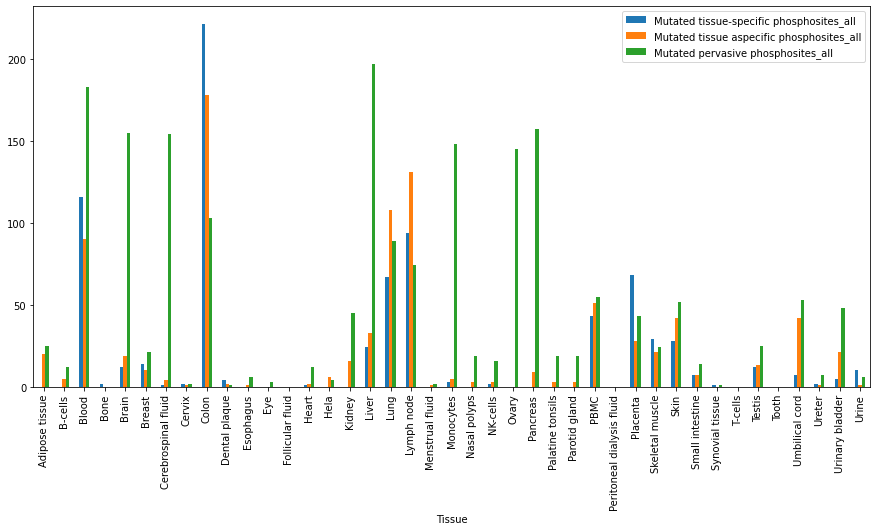

In [61]:
mut_sites_tissue = pd.DataFrame({"Tissue": list_tissues_STY})
list_tspec = []
list_taspec = []
list_gen = []
for tissue in list_tissues_STY:
    tspec_mut_tissue = tspec_site_mut.loc[tspec_site_mut[tissue]==1, :].groupby(["ACC_ID", "UP_POS"], as_index=False).agg({"dbSNP": "first"})
    taspec_mut_tissue = taspec_site_mut.loc[taspec_site_mut[tissue]==1, :].groupby(["ACC_ID", "UP_POS"], as_index=False).agg({"dbSNP": "first"})
    gen_mut_tissue = gen_site_mut.loc[gen_site_mut[tissue]==1, :].groupby(["ACC_ID", "UP_POS"], as_index=False).agg({"dbSNP": "first"})
    count_tspec = tspec_mut_tissue.shape[0]
    count_taspec = taspec_mut_tissue.shape[0]
    count_gen = gen_mut_tissue.shape[0]
    list_tspec.append(count_tspec)
    list_taspec.append(count_taspec)
    list_gen.append(count_gen)
mut_sites_tissue["Mutated tissue-specific phosphosites_all"] = list_tspec
mut_sites_tissue["Mutated tissue aspecific phosphosites_all"] = list_taspec
mut_sites_tissue["Mutated pervasive phosphosites_all"] = list_gen
mut_sites_tissue.plot(kind="bar", figsize=(15,7), x="Tissue")
#plt.savefig("Humsavar_abs_all_mutated_sites.png", format="png", bbox_inches="tight")

In [62]:
mut_sites_tissue

,Tissue,Mutated tissue-specific phosphosites_all,Mutated tissue aspecific phosphosites_all,Mutated pervasive phosphosites_all
0,Adipose tissue,0,20,25
1,B-cells,0,5,12
2,Blood,116,90,183
3,Bone,2,0,0
4,Brain,12,19,155
5,Breast,14,10,21
6,Cerebrospinal fluid,1,4,154
7,Cervix,2,1,2
8,Colon,221,178,103
9,Dental plaque,4,2,1


In [63]:
sites_three_cat = pd.read_csv("number of three categories per tissue_sites.tsv", sep="\t")
sites_three_cat.head()

,Tissue,number of tissue-specific sites,number of non tissue-specific sites,number of generally expressed sites,Total
0,Adipose tissue,0,221,390,611
1,B-cells,16,95,250,361
2,Blood,1642,2466,2961,7069
3,Bone,2,2,9,13
4,Brain,121,176,2307,2604


In [64]:
print(humsavar.groupby(["ACC_ID", "UP_POS"], as_index=False).agg({"dbSNP": "first"}).shape[0])
print(humsavar[humsavar["Variant category"]=="LP/P"].groupby(["ACC_ID", "UP_POS"], as_index=False).agg({"dbSNP": "first"}).shape[0])
print(humsavar[humsavar["Variant category"]=="LB/B"].groupby(["ACC_ID", "UP_POS"], as_index=False).agg({"dbSNP": "first"}).shape[0])
print(humsavar[humsavar["Variant category"]=="US"].groupby(["ACC_ID", "UP_POS"], as_index=False).agg({"dbSNP": "first"}).shape[0])

73256
27084
38835
8043


Shown here is the percentage P-sites associated with a mutation within a 5-residue window compared to the total amount of P-sites in that tissue. For some tissues, for some categories this ratio is higher than for others, and the categories in tissues showing different percentages are not always underrepresented.

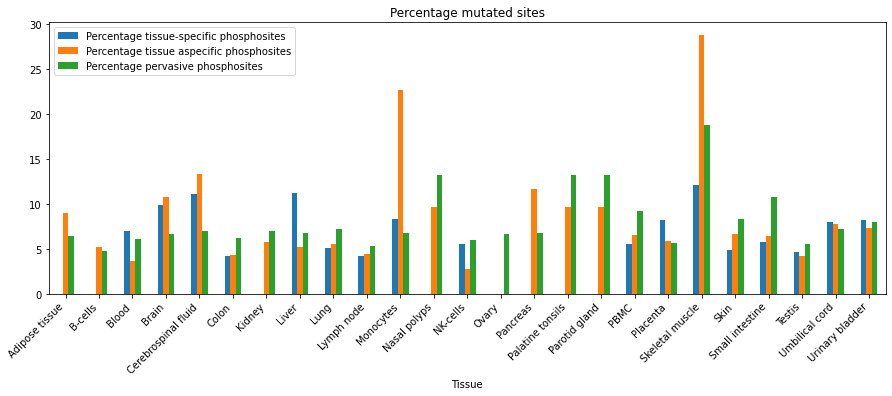

In [65]:
mut_sites_tissue_ratio = sites_three_cat.copy()
mut_sites_tissue_ratio["Percentage tissue-specific phosphosites"] = mut_sites_tissue["Mutated tissue-specific phosphosites_all"]*100/mut_sites_tissue_ratio["number of tissue-specific sites"]
mut_sites_tissue_ratio["Percentage tissue aspecific phosphosites"] = mut_sites_tissue["Mutated tissue aspecific phosphosites_all"]*100/mut_sites_tissue_ratio["number of non tissue-specific sites"]
mut_sites_tissue_ratio["Percentage pervasive phosphosites"] = mut_sites_tissue["Mutated pervasive phosphosites_all"]*100/mut_sites_tissue_ratio["number of generally expressed sites"]
mut_sites_tissue_ratio[((mut_sites_tissue_ratio["number of tissue-specific sites"]>=100)|
                     (mut_sites_tissue_ratio["number of non tissue-specific sites"]>=100)|
                     (mut_sites_tissue_ratio["number of generally expressed sites"]>=100))][["Tissue", "Percentage tissue-specific phosphosites",
                                                                                          "Percentage tissue aspecific phosphosites", 
                                                                                          "Percentage pervasive phosphosites"]].plot(kind="bar", figsize=(15,5), x="Tissue", title="Percentage mutated sites")
plt.xticks(rotation=45, ha="right")
#plt.savefig("Humsavar_Percentage_mutated_sites.png", format="png", bbox_inches="tight")
plt.show()

While above only these tissues for which at least one cateogry exceeds 100 P-sites (regardless of association with mutation), here we see the percentage P-sites in each tissue and each cateogry without that filter. However, some underrepresented tissues show distinctive outliers.

<AxesSubplot:title={'center':'Ratio mutated sites'}, xlabel='Tissue'>

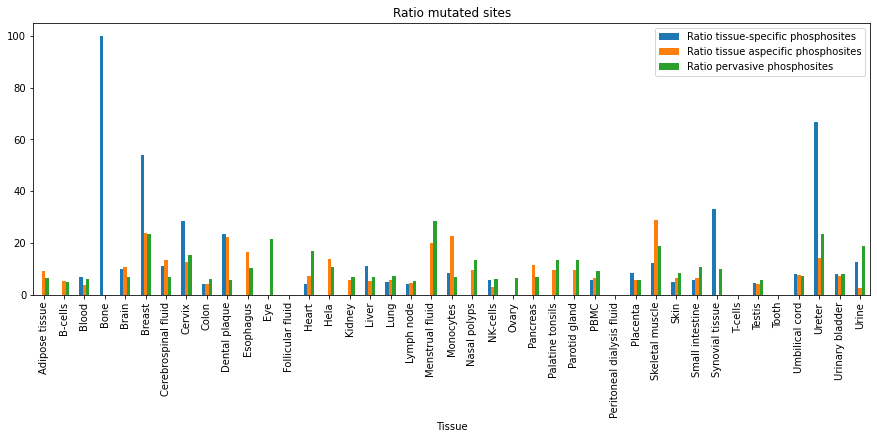

In [66]:
mut_sites_tissue_ratio = sites_three_cat.copy()
mut_sites_tissue_ratio["Ratio tissue-specific phosphosites"] = mut_sites_tissue["Mutated tissue-specific phosphosites_all"]*100/mut_sites_tissue_ratio["number of tissue-specific sites"]
mut_sites_tissue_ratio["Ratio tissue aspecific phosphosites"] = mut_sites_tissue["Mutated tissue aspecific phosphosites_all"]*100/mut_sites_tissue_ratio["number of non tissue-specific sites"]
mut_sites_tissue_ratio["Ratio pervasive phosphosites"] = mut_sites_tissue["Mutated pervasive phosphosites_all"]*100/mut_sites_tissue_ratio["number of generally expressed sites"]
mut_sites_tissue_ratio[["Tissue", "Ratio tissue-specific phosphosites",
                                                                                          "Ratio tissue aspecific phosphosites", 
                                                                                          "Ratio pervasive phosphosites"]].plot(kind="bar", figsize=(15,5), x="Tissue", title="Ratio mutated sites")
#plt.savefig("Humsavar_ratio_mutated_sites_nonfiltered.png", format="png", bbox_inches="tight")

In [67]:
mut_sites_tissue_ratio

,Tissue,number of tissue-specific sites,number of non tissue-specific sites,number of generally expressed sites,Total,Ratio tissue-specific phosphosites,Ratio tissue aspecific phosphosites,Ratio pervasive phosphosites
0,Adipose tissue,0,221,390,611,NaN,9.049774,6.410256
1,B-cells,16,95,250,361,0.000000,5.263158,4.800000
2,Blood,1642,2466,2961,7069,7.064555,3.649635,6.180344
3,Bone,2,2,9,13,100.000000,0.000000,0.000000
4,Brain,121,176,2307,2604,9.917355,10.795455,6.718682
5,Breast,26,42,89,157,53.846154,23.809524,23.595506
6,Cerebrospinal fluid,9,30,2203,2242,11.111111,13.333333,6.990468
7,Cervix,7,8,13,28,28.571429,12.500000,15.384615
8,Colon,5252,4089,1651,10992,4.207921,4.353143,6.238643
9,Dental plaque,17,9,18,44,23.529412,22.222222,5.555556


We do the same for each consequence of mutation (pathogenic, benign, unknown significance). First, we do this on the absolute level. Later we do this for the percentages, this time filtering out the tissues for which none of the percentages exceed 1.5 times the interquartile range.

<AxesSubplot:xlabel='Tissue'>

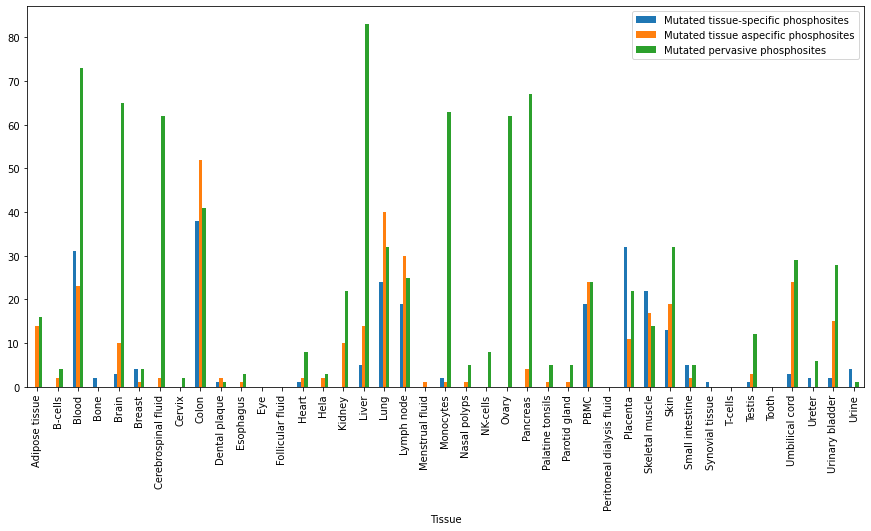

In [68]:
mut_sites_tissue_path = pd.DataFrame({"Tissue": list_tissues_STY})
list_tspec = []
list_taspec = []
list_gen = []
for tissue in list_tissues_STY:
    tspec_mut_tissue = tspec_site_mut.loc[(tspec_site_mut[tissue]==1)&(tspec_site_mut["Variant category"]=="LP/P"), :].groupby(["ACC_ID", "UP_POS"], as_index=False).agg({"dbSNP": "first"})
    taspec_mut_tissue = taspec_site_mut.loc[(taspec_site_mut[tissue]==1)&(taspec_site_mut["Variant category"]=="LP/P"), :].groupby(["ACC_ID", "UP_POS"], as_index=False).agg({"dbSNP": "first"})
    gen_mut_tissue = gen_site_mut.loc[(gen_site_mut[tissue]==1)&(gen_site_mut["Variant category"]=="LP/P"), :].groupby(["ACC_ID", "UP_POS"], as_index=False).agg({"dbSNP": "first"})
    count_tspec = tspec_mut_tissue.shape[0]
    count_taspec = taspec_mut_tissue.shape[0]
    count_gen = gen_mut_tissue.shape[0]
    list_tspec.append(count_tspec)
    list_taspec.append(count_taspec)
    list_gen.append(count_gen)
mut_sites_tissue_path["Mutated tissue-specific phosphosites"] = list_tspec
mut_sites_tissue_path["Mutated tissue aspecific phosphosites"] = list_taspec
mut_sites_tissue_path["Mutated pervasive phosphosites"] = list_gen
mut_sites_tissue_path.plot(kind="bar", figsize=(15,7), x="Tissue")

In [69]:
mut_sites_tissue_ratio_path = mut_sites_tissue[["Tissue", "Mutated tissue-specific phosphosites_all", "Mutated tissue aspecific phosphosites_all", "Mutated pervasive phosphosites_all"]].copy()
mut_sites_tissue_ratio_path["Ratio tissue-specific phosphosites (pathogenic mutation)"] = mut_sites_tissue_path["Mutated tissue-specific phosphosites"]*100/mut_sites_tissue_ratio_path["Mutated tissue-specific phosphosites_all"]
mut_sites_tissue_ratio_path["Ratio tissue aspecific phosphosites (pathogenic mutation)"] = mut_sites_tissue_path["Mutated tissue aspecific phosphosites"]*100/mut_sites_tissue_ratio_path["Mutated tissue aspecific phosphosites_all"]
mut_sites_tissue_ratio_path["Ratio pervasive phosphosites (pathogenic mutation)"] = mut_sites_tissue_path["Mutated pervasive phosphosites"]*100/mut_sites_tissue_ratio_path["Mutated pervasive phosphosites_all"]

In [70]:
print(mut_sites_tissue_ratio_path["Ratio tissue-specific phosphosites (pathogenic mutation)"].describe())
print(mut_sites_tissue_ratio_path["Ratio tissue aspecific phosphosites (pathogenic mutation)"].describe())
print(mut_sites_tissue_ratio_path["Ratio pervasive phosphosites (pathogenic mutation)"].describe())

count     25.000000
mean      43.287134
std       32.331454
min        0.000000
25%       20.833333
50%       40.000000
75%       66.666667
max      100.000000
Name: Ratio tissue-specific phosphosites (pathogenic mutation), dtype: float64
count     33.000000
mean      43.418037
std       29.402029
min        0.000000
25%       25.555556
50%       39.285714
75%       57.142857
max      100.000000
Name: Ratio tissue aspecific phosphosites (pathogenic mutation), dtype: float64
count     36.000000
mean      44.485120
std       23.545750
min        0.000000
25%       33.671171
50%       42.621363
75%       55.621069
max      100.000000
Name: Ratio pervasive phosphosites (pathogenic mutation), dtype: float64


In [71]:
whisker_tspec = 1.5*(66.67-20.83)
whisker_taspec = 1.5*(57.14-25.56)
whisker_gen = 1.5*(55.62-33.67)
print(whisker_tspec, whisker_taspec, whisker_gen)

68.76 47.370000000000005 32.925


<AxesSubplot:title={'center':'Ratio sites having pathogenic mutation out of sites having mutation'}, xlabel='Tissue'>

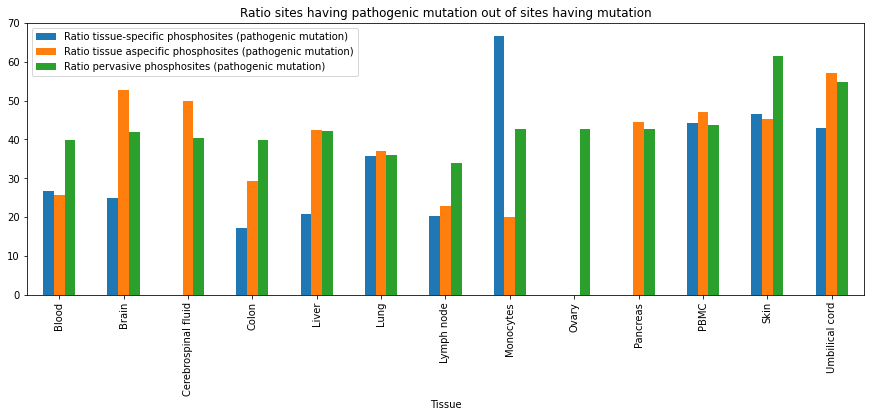

In [72]:
mut_sites_tissue_ratio_path[(((mut_sites_tissue_ratio_path["Ratio tissue-specific phosphosites (pathogenic mutation)"]>=whisker_tspec)&(mut_sites_tissue_ratio_path["Mutated tissue-specific phosphosites_all"]>50))|
                     ((mut_sites_tissue_ratio_path["Ratio tissue aspecific phosphosites (pathogenic mutation)"]>=whisker_taspec)&(mut_sites_tissue_ratio_path["Mutated tissue aspecific phosphosites_all"]>50))|
                     ((mut_sites_tissue_ratio_path["Ratio pervasive phosphosites (pathogenic mutation)"]>=whisker_gen)&(mut_sites_tissue_ratio_path["Mutated pervasive phosphosites_all"]>50)))][["Tissue", "Ratio tissue-specific phosphosites (pathogenic mutation)",
                                                                                          "Ratio tissue aspecific phosphosites (pathogenic mutation)", 
                                                                                          "Ratio pervasive phosphosites (pathogenic mutation)"]].plot(kind="bar", figsize=(15,5), x="Tissue", title="Ratio sites having pathogenic mutation out of sites having mutation")
#plt.savefig("Humsavar_ratio_pathmutated_siteseins.png", format="png", bbox_inches="tight")

In [73]:
mut_sites_tissue_ratio_path[(mut_sites_tissue_ratio_path["Tissue"]=="Monocytes")|
                           (mut_sites_tissue_ratio_path["Tissue"]=="Skin")|
                           (mut_sites_tissue_ratio_path["Tissue"]=="Umbilical cord")]

,Tissue,Mutated tissue-specific phosphosites_all,Mutated tissue aspecific phosphosites_all,Mutated pervasive phosphosites_all,Ratio tissue-specific phosphosites (pathogenic mutation),Ratio tissue aspecific phosphosites (pathogenic mutation),Ratio pervasive phosphosites (pathogenic mutation)
20,Monocytes,3,5,148,66.666667,20.000000,42.567568
31,Skin,28,42,52,46.428571,45.238095,61.538462
37,Umbilical cord,7,42,53,42.857143,57.142857,54.716981


<AxesSubplot:xlabel='Tissue'>

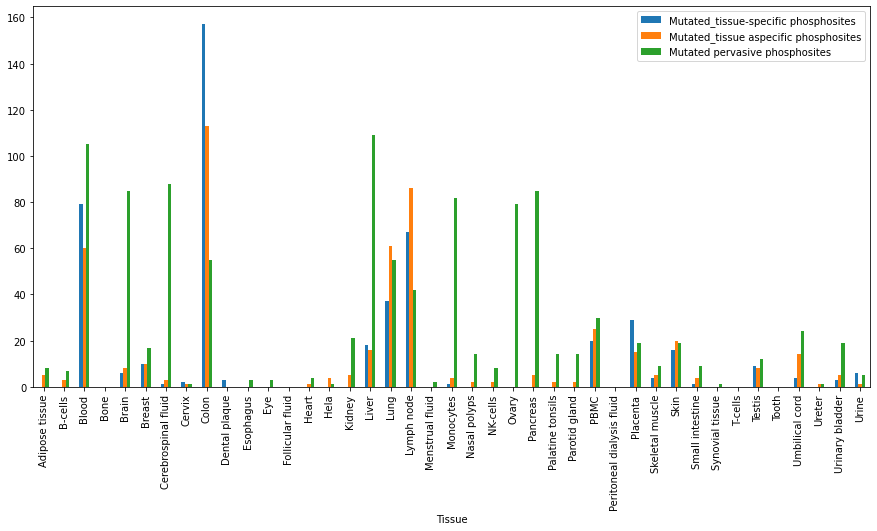

In [74]:
mut_sites_tissue_ben = pd.DataFrame({"Tissue": list_tissues_STY})
list_tspec = []
list_taspec = []
list_gen = []
for tissue in list_tissues_STY:
    tspec_mut_tissue = tspec_site_mut.loc[(tspec_site_mut[tissue]==1)&(tspec_site_mut["Variant category"]=="LB/B"), :].groupby(["ACC_ID", "UP_POS"], as_index=False).agg({"dbSNP": "first"})
    taspec_mut_tissue = taspec_site_mut.loc[(taspec_site_mut[tissue]==1)&(taspec_site_mut["Variant category"]=="LB/B"), :].groupby(["ACC_ID", "UP_POS"], as_index=False).agg({"dbSNP": "first"})
    gen_mut_tissue = gen_site_mut.loc[(gen_site_mut[tissue]==1)&(gen_site_mut["Variant category"]=="LB/B"), :].groupby(["ACC_ID", "UP_POS"], as_index=False).agg({"dbSNP": "first"})
    count_tspec = tspec_mut_tissue.shape[0]
    count_taspec = taspec_mut_tissue.shape[0]
    count_gen = gen_mut_tissue.shape[0]
    list_tspec.append(count_tspec)
    list_taspec.append(count_taspec)
    list_gen.append(count_gen)
mut_sites_tissue_ben["Mutated_tissue-specific phosphosites"] = list_tspec
mut_sites_tissue_ben["Mutated_tissue aspecific phosphosites"] = list_taspec
mut_sites_tissue_ben["Mutated pervasive phosphosites"] = list_gen
mut_sites_tissue_ben.plot(kind="bar", figsize=(15,7), x="Tissue")

In [75]:
mut_sites_tissue_ratio_ben = mut_sites_tissue[["Tissue", "Mutated tissue-specific phosphosites_all", "Mutated tissue aspecific phosphosites_all", "Mutated pervasive phosphosites_all"]].copy()
mut_sites_tissue_ratio_ben["Ratio tissue-specific phosphosites (benign mutation)"] = mut_sites_tissue_ben["Mutated_tissue-specific phosphosites"]*100/mut_sites_tissue_ratio_ben["Mutated tissue-specific phosphosites_all"]
mut_sites_tissue_ratio_ben["Ratio tissue aspecific phosphosites (benign mutation)"] = mut_sites_tissue_ben["Mutated_tissue aspecific phosphosites"]*100/mut_sites_tissue_ratio_ben["Mutated tissue aspecific phosphosites_all"]
mut_sites_tissue_ratio_ben["Ratio pervasive phosphosites (benign mutation)"] = mut_sites_tissue_ben["Mutated pervasive phosphosites"]*100/mut_sites_tissue_ratio_ben["Mutated pervasive phosphosites_all"]

In [76]:
print(mut_sites_tissue_ratio_ben["Ratio tissue-specific phosphosites (benign mutation)"].describe())
print(mut_sites_tissue_ratio_ben["Ratio tissue aspecific phosphosites (benign mutation)"].describe())
print(mut_sites_tissue_ratio_ben["Ratio pervasive phosphosites (benign mutation)"].describe())

count     25.000000
mean      47.877191
std       31.757189
min        0.000000
25%       14.285714
50%       57.142857
75%       71.276596
max      100.000000
Name: Ratio tissue-specific phosphosites (benign mutation), dtype: float64
count     33.000000
mean      54.631907
std       27.086441
min        0.000000
25%       42.105263
50%       57.142857
75%       66.666667
max      100.000000
Name: Ratio tissue aspecific phosphosites (benign mutation), dtype: float64
count     36.000000
mean      54.876357
std       21.797549
min        0.000000
25%       45.008776
50%       54.514107
75%       62.419743
max      100.000000
Name: Ratio pervasive phosphosites (benign mutation), dtype: float64


In [77]:
whisker_tspec = 1.5*(71.28-14.29)
whisker_taspec = 1.5*(66.67-42.11)
whisker_gen = 1.5*(62.42-45)
print(whisker_tspec, whisker_taspec, whisker_gen)

85.485 36.84 26.130000000000003


<AxesSubplot:title={'center':'Ratio sites having benign mutation out of sites having mutation'}, xlabel='Tissue'>

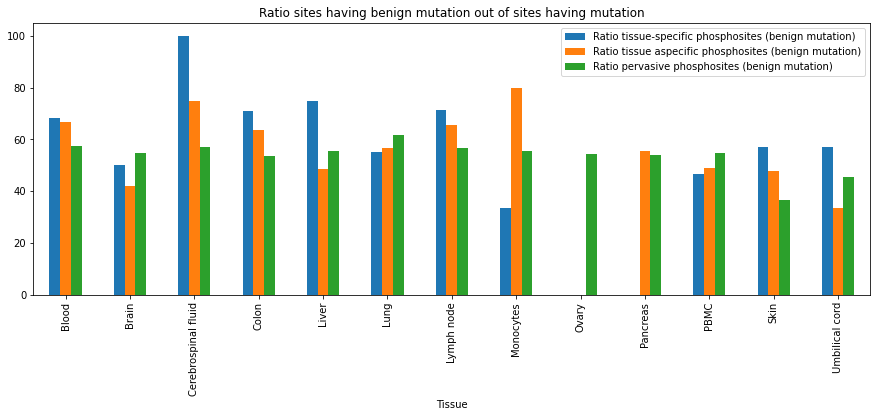

In [78]:
mut_sites_tissue_ratio_ben[(((mut_sites_tissue_ratio_ben["Ratio tissue-specific phosphosites (benign mutation)"]>=whisker_tspec)&(mut_sites_tissue_ratio_ben["Mutated tissue-specific phosphosites_all"]>50))|
                     ((mut_sites_tissue_ratio_ben["Ratio tissue aspecific phosphosites (benign mutation)"]>=whisker_taspec)&(mut_sites_tissue_ratio_ben["Mutated tissue aspecific phosphosites_all"]>50))|
                     ((mut_sites_tissue_ratio_ben["Ratio pervasive phosphosites (benign mutation)"]>=whisker_gen)&(mut_sites_tissue_ratio_ben["Mutated pervasive phosphosites_all"]>50)))][["Tissue", "Ratio tissue-specific phosphosites (benign mutation)",
                                                                                          "Ratio tissue aspecific phosphosites (benign mutation)", 
                                                                                          "Ratio pervasive phosphosites (benign mutation)"]].plot(kind="bar", figsize=(15,5), x="Tissue", title="Ratio sites having benign mutation out of sites having mutation")
#plt.savefig("Humsavar_ratio_ben_mutated_sites.png", format="png", bbox_inches="tight")

In [79]:
mut_sites_tissue_ratio_ben

,Tissue,Mutated tissue-specific phosphosites_all,Mutated tissue aspecific phosphosites_all,Mutated pervasive phosphosites_all,Ratio tissue-specific phosphosites (benign mutation),Ratio tissue aspecific phosphosites (benign mutation),Ratio pervasive phosphosites (benign mutation)
0,Adipose tissue,0,20,25,NaN,25.000000,32.000000
1,B-cells,0,5,12,NaN,60.000000,58.333333
2,Blood,116,90,183,68.103448,66.666667,57.377049
3,Bone,2,0,0,0.000000,NaN,NaN
4,Brain,12,19,155,50.000000,42.105263,54.838710
5,Breast,14,10,21,71.428571,100.000000,80.952381
6,Cerebrospinal fluid,1,4,154,100.000000,75.000000,57.142857
7,Cervix,2,1,2,100.000000,100.000000,50.000000
8,Colon,221,178,103,71.040724,63.483146,53.398058
9,Dental plaque,4,2,1,75.000000,0.000000,0.000000


<AxesSubplot:xlabel='Tissue'>

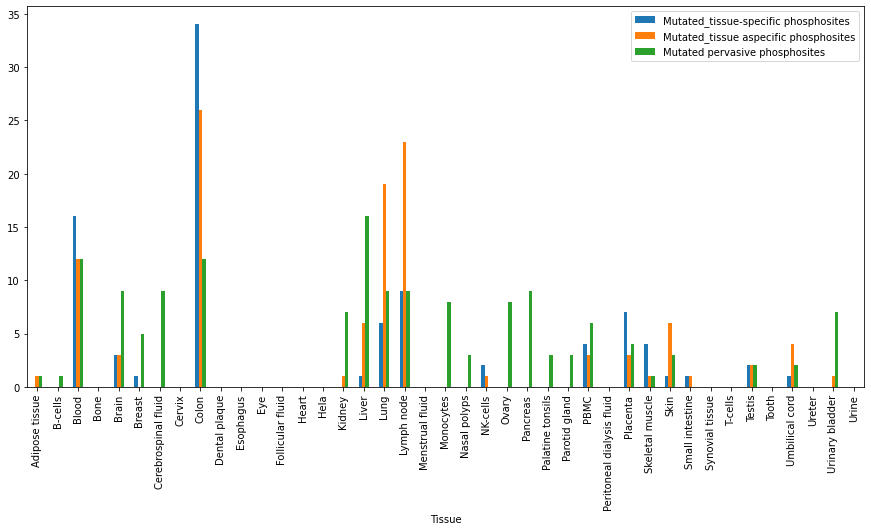

In [80]:
mut_sites_tissue_us = pd.DataFrame({"Tissue": list_tissues_STY})
list_tspec = []
list_taspec = []
list_gen = []
for tissue in list_tissues_STY:
    tspec_mut_tissue = tspec_site_mut.loc[(tspec_site_mut[tissue]==1)&(tspec_site_mut["Variant category"]=="US"), :].groupby(["ACC_ID", "UP_POS"], as_index=False).agg({"dbSNP": "first"})
    taspec_mut_tissue = taspec_site_mut.loc[(taspec_site_mut[tissue]==1)&(taspec_site_mut["Variant category"]=="US"), :].groupby(["ACC_ID", "UP_POS"], as_index=False).agg({"dbSNP": "first"})
    gen_mut_tissue = gen_site_mut.loc[(gen_site_mut[tissue]==1)&(gen_site_mut["Variant category"]=="US"), :].groupby(["ACC_ID", "UP_POS"], as_index=False).agg({"dbSNP": "first"})
    count_tspec = tspec_mut_tissue.shape[0]
    count_taspec = taspec_mut_tissue.shape[0]
    count_gen = gen_mut_tissue.shape[0]
    list_tspec.append(count_tspec)
    list_taspec.append(count_taspec)
    list_gen.append(count_gen)
mut_sites_tissue_us["Mutated_tissue-specific phosphosites"] = list_tspec
mut_sites_tissue_us["Mutated_tissue aspecific phosphosites"] = list_taspec
mut_sites_tissue_us["Mutated pervasive phosphosites"] = list_gen
mut_sites_tissue_us.plot(kind="bar", figsize=(15,7), x="Tissue")

In [81]:
mut_sites_tissue_ratio_us = mut_sites_tissue[["Tissue", "Mutated tissue-specific phosphosites_all", "Mutated tissue aspecific phosphosites_all", "Mutated pervasive phosphosites_all"]].copy()
mut_sites_tissue_ratio_us["Ratio tissue-specific phosphosites (unknown significance)"] = mut_sites_tissue_us["Mutated_tissue-specific phosphosites"]*100/mut_sites_tissue_ratio_us["Mutated tissue-specific phosphosites_all"]
mut_sites_tissue_ratio_us["Ratio tissue aspecific phosphosites (unknown significance)"] = mut_sites_tissue_us["Mutated_tissue aspecific phosphosites"]*100/mut_sites_tissue_ratio_us["Mutated tissue aspecific phosphosites_all"]
mut_sites_tissue_ratio_us["Ratio pervasive phosphosites (unknown significance)"] = mut_sites_tissue_us["Mutated pervasive phosphosites"]*100/mut_sites_tissue_ratio_us["Mutated pervasive phosphosites_all"]

In [82]:
print(mut_sites_tissue_ratio_us["Ratio tissue-specific phosphosites (unknown significance)"].describe())
print(mut_sites_tissue_ratio_us["Ratio tissue aspecific phosphosites (unknown significance)"].describe())
print(mut_sites_tissue_ratio_us["Ratio pervasive phosphosites (unknown significance)"].describe())

count     25.000000
mean      10.648640
std       19.936141
min        0.000000
25%        0.000000
50%        7.142857
75%       13.793103
max      100.000000
Name: Ratio tissue-specific phosphosites (unknown significance), dtype: float64
count    33.000000
mean      6.704389
std       8.312154
min       0.000000
25%       0.000000
50%       4.761905
75%      14.285714
max      33.333333
Name: Ratio tissue aspecific phosphosites (unknown significance), dtype: float64
count    36.000000
mean      6.457806
std       6.195119
min       0.000000
25%       0.000000
50%       5.750857
75%      10.311542
max      23.809524
Name: Ratio pervasive phosphosites (unknown significance), dtype: float64


In [83]:
whisker_tspec = 1.5*(13.79)
whisker_taspec = 1.5*(14.29)
whisker_gen = 1.5*(10.31)
print(whisker_tspec, whisker_taspec, whisker_gen)

20.685 21.435 15.465


None of the ratios exceeds the whisker.

<AxesSubplot:title={'center':'Ratio sites having unknown significance out of sites having mutation'}, xlabel='Tissue'>

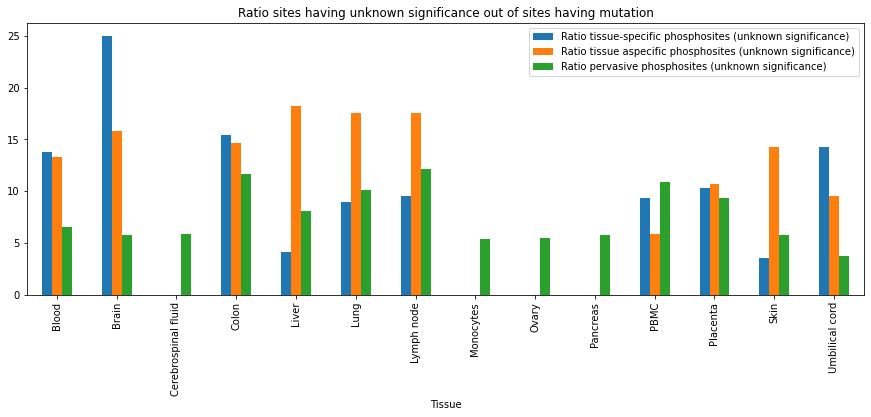

In [84]:
mut_sites_tissue_ratio_us[(((mut_sites_tissue_ratio_us["Ratio tissue-specific phosphosites (unknown significance)"]>=0)&(mut_sites_tissue_ratio_us["Mutated tissue-specific phosphosites_all"]>50))|
                     ((mut_sites_tissue_ratio_us["Ratio tissue aspecific phosphosites (unknown significance)"]>=0)&(mut_sites_tissue_ratio_us["Mutated tissue aspecific phosphosites_all"]>50))|
                     ((mut_sites_tissue_ratio_us["Ratio pervasive phosphosites (unknown significance)"]>=0)&(mut_sites_tissue_ratio_us["Mutated pervasive phosphosites_all"]>50)))][["Tissue", "Ratio tissue-specific phosphosites (unknown significance)",
                                                                                          "Ratio tissue aspecific phosphosites (unknown significance)", 
                                                                                          "Ratio pervasive phosphosites (unknown significance)"]].plot(kind="bar", figsize=(15,5), x="Tissue", title="Ratio sites having unknown significance out of sites having mutation")
#plt.savefig("Humsavar_ratio_us_mutated_sites.png", format="png", bbox_inches="tight")

In [85]:
mut_sites_tissue_ratio_us

,Tissue,Mutated tissue-specific phosphosites_all,Mutated tissue aspecific phosphosites_all,Mutated pervasive phosphosites_all,Ratio tissue-specific phosphosites (unknown significance),Ratio tissue aspecific phosphosites (unknown significance),Ratio pervasive phosphosites (unknown significance)
0,Adipose tissue,0,20,25,NaN,5.000000,4.000000
1,B-cells,0,5,12,NaN,0.000000,8.333333
2,Blood,116,90,183,13.793103,13.333333,6.557377
3,Bone,2,0,0,0.000000,NaN,NaN
4,Brain,12,19,155,25.000000,15.789474,5.806452
5,Breast,14,10,21,7.142857,0.000000,23.809524
6,Cerebrospinal fluid,1,4,154,0.000000,0.000000,5.844156
7,Cervix,2,1,2,0.000000,0.000000,0.000000
8,Colon,221,178,103,15.384615,14.606742,11.650485
9,Dental plaque,4,2,1,0.000000,0.000000,0.000000


In [86]:
tspec_site_mut["Disease name"].value_counts()

-                                                                                     626
Amyloidosis, transthyretin-related (AMYL-TTR) [MIM:105210]                             55
A sporadic cancer                                                                      55
Marfan syndrome (MFS) [MIM:154700]                                                     29
Sporadic cancers                                                                       28
                                                                                     ... 
Diamond-Blackfan anemia 5 (DBA5) [MIM:612528]                                           1
Myopathy, myofibrillar, 1 (MFM1) [MIM:601419]                                           1
Cardiomyopathy, dilated 1I (CMD1I) [MIM:604765]                                         1
Hypoplastic left heart syndrome 1 (HLHS1) [MIM:241550]                                  1
Rajab interstitial lung disease with brain calcifications 2 (RILDBC2) [MIM:619013]      1
Name: Dise

In [87]:
tspec_site_mut[tspec_site_mut["Disease name"].str.contains("cancer")].groupby(["ACC_ID", "UP_POS"], as_index=False).agg({"dbSNP": "first"}).shape[0]

43

In [88]:
taspec_site_mut["Disease name"].value_counts()

-                                                                           308
Nemaline myopathy 3 (NEM3) [MIM:161800]                                      32
A sporadic cancer                                                            17
Noonan syndrome 5 (NS5) [MIM:611553]                                         16
Neutropenia, severe congenital 1, autosomal dominant (SCN1) [MIM:202700]     11
                                                                           ... 
Dystonia, juvenile-onset (DJO) [MIM:607371]                                   1
Neuronopathy, distal hereditary motor, 2B (HMN2B) [MIM:608634]                1
Mandibuloacral dysplasia with type A lipodystrophy (MADA) [MIM:248370]        1
Atrial septal defect 5 (ASD5) [MIM:612794]                                    1
Spinocerebellar ataxia, autosomal recessive, 16 (SCAR16) [MIM:615768]         1
Name: Disease name, Length: 114, dtype: int64

In [89]:
taspec_site_mut[taspec_site_mut["Disease name"].str.contains("cancer")].groupby(["ACC_ID", "UP_POS"], as_index=False).agg({"dbSNP": "first"}).shape[0]

11

In [90]:
gen_site_mut["Disease name"].value_counts()

-                                                                  292
Noonan syndrome 5 (NS5) [MIM:611553]                                15
Nemaline myopathy 3 (NEM3) [MIM:161800]                             12
Alexander disease (ALXDRD) [MIM:203450]                              8
Baraitser-Winter syndrome 2 (BRWS2) [MIM:614583]                     7
                                                                  ... 
A breast cancer sample                                               1
Deafness, autosomal dominant, 70 (DFNA70) [MIM:616968]               1
Migraine, familial hemiplegic, 2 (FHM2) [MIM:602481]                 1
Symptomatic deficiency in lactate transport (SDLT) [MIM:245340]      1
Mental retardation, autosomal dominant 53 (MRD53) [MIM:617798]       1
Name: Disease name, Length: 70, dtype: int64

In [91]:
gen_site_mut[gen_site_mut["Disease name"].str.contains("cancer")].groupby(["ACC_ID", "UP_POS"], as_index=False).agg({"dbSNP": "first"}).shape[0]

1

# Proteins having tissue-specific P-sites

We now repeat the same type of analysis on the P-site level. For this, we first merge the site-data with the data from each of the three categories of proteins.

In [92]:
tpsecsites_tspecproteins = pd.merge(tspec_proteins["ACC_ID"], data_site, how="inner", on=["ACC_ID"])
print(tpsecsites_tspecproteins.shape[0])
print(tpsecsites_tspecproteins["ACC_ID"].nunique())

2794
2029


In [93]:
tspecsites_taspecproteins = pd.merge(taspec_proteins["ACC_ID"], data_site, how="inner", on=["ACC_ID"])
tspecsites_taspecproteins = pd.merge(tspecsites_taspecproteins[["ACC_ID", "UP_POS"]], tspec_sites, how="inner", on=["ACC_ID", "UP_POS"])
print(tspecsites_taspecproteins.shape[0])
print(tspecsites_taspecproteins["ACC_ID"].nunique())

4989
1596


In [94]:
tspecsites_genproteins = pd.merge(gen_proteins, data_site, how="inner", on=["ACC_ID"])
tspecsites_genproteins = pd.merge(tspecsites_genproteins[["ACC_ID", "UP_POS"]], tspec_sites, how="inner", on=["ACC_ID", "UP_POS"])
print(tspecsites_genproteins.shape[0])
print(tspecsites_genproteins["ACC_ID"].nunique())

6236
1352


In [95]:
tspecsites_tspecproteins_mut = pd.merge(tpsecsites_tspecproteins, data_mut5, how="inner", on=["ACC_ID", "UP_POS"])
print(tspecsites_tspecproteins_mut.shape[0])
print(tspecsites_tspecproteins_mut["ACC_ID"].nunique())

200
133


In [96]:
tspecsites_taspecproteins_mut = pd.merge(tspecsites_taspecproteins, data_mut5, how="inner", on=["ACC_ID", "UP_POS"])
print(tspecsites_taspecproteins_mut.shape[0])
print(tspecsites_taspecproteins_mut["ACC_ID"].nunique())

495
187


In [97]:
tspecsites_genproteins_mut = pd.merge(tspecsites_genproteins, data_mut5, how="inner", on=["ACC_ID", "UP_POS"])
print(tspecsites_genproteins_mut.shape[0])
print(tspecsites_genproteins_mut["ACC_ID"].nunique())

566
196


Unlike on the P-site level, the difference for tissue-specific P-sites on the three categories of proteins is small.

In [98]:
print("Percentage tissue-specific P-sites on tissue-specific phosphorylated proteins: {}%".format(tspecsites_tspecproteins_mut.groupby(["ACC_ID", "UP_POS"], as_index=False).agg({"dbSNP": "first"}).shape[0]*100/tpsecsites_tspecproteins.shape[0]))
print("Percentage tissue-specific P-sites on tissue aspecific phosphorylated proteins: {}%".format(tspecsites_taspecproteins_mut.groupby(["ACC_ID", "UP_POS"], as_index=False).agg({"dbSNP": "first"}).shape[0]*100/tspecsites_taspecproteins.shape[0]))
print("Percentage tissue-specific P-sites on pervasively phosphorylated proteins: {}%".format(tspecsites_genproteins_mut.groupby(["ACC_ID", "UP_POS"], as_index=False).agg({"dbSNP": "first"}).shape[0]*100/tspecsites_genproteins.shape[0]))

Percentage tissue-specific P-sites on tissue-specific phosphorylated proteins: 5.404438081603436%
Percentage tissue-specific P-sites on tissue aspecific phosphorylated proteins: 5.552214872719984%
Percentage tissue-specific P-sites on pervasively phosphorylated proteins: 5.564464400256575%


<AxesSubplot:xlabel='Tissue'>

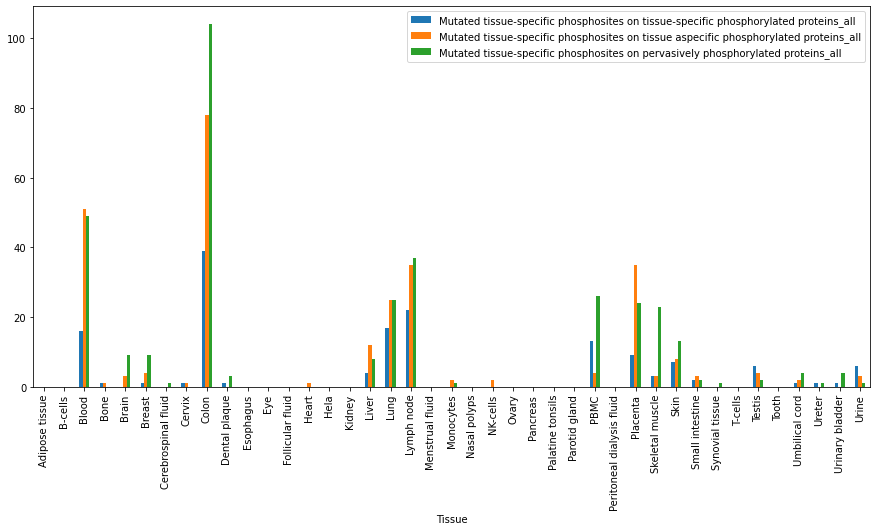

In [99]:
mut_tspecsites_tissue = pd.DataFrame({"Tissue": list_tissues_STY})
list_tspec = []
list_taspec = []
list_gen = []
for tissue in list_tissues_STY:
    tissue = tissue+"_x"
    tspec_mut_tissue = tspecsites_tspecproteins_mut.loc[tspecsites_tspecproteins_mut[tissue]==1, :].groupby(["ACC_ID", "UP_POS"], as_index=False).agg({"dbSNP": "first"})
    taspec_mut_tissue = tspecsites_taspecproteins_mut.loc[tspecsites_taspecproteins_mut[tissue]==1, :].groupby(["ACC_ID", "UP_POS"], as_index=False).agg({"dbSNP": "first"})
    gen_mut_tissue = tspecsites_genproteins_mut.loc[tspecsites_genproteins_mut[tissue]==1, :].groupby(["ACC_ID", "UP_POS"], as_index=False).agg({"dbSNP": "first"})
    count_tspec = tspec_mut_tissue.shape[0]
    count_taspec = taspec_mut_tissue.shape[0]
    count_gen = gen_mut_tissue.shape[0]
    list_tspec.append(count_tspec)
    list_taspec.append(count_taspec)
    list_gen.append(count_gen)
mut_tspecsites_tissue["Mutated tissue-specific phosphosites on tissue-specific phosphorylated proteins_all"] = list_tspec
mut_tspecsites_tissue["Mutated tissue-specific phosphosites on tissue aspecific phosphorylated proteins_all"] = list_taspec
mut_tspecsites_tissue["Mutated tissue-specific phosphosites on pervasively phosphorylated proteins_all"] = list_gen
mut_tspecsites_tissue.plot(kind="bar", figsize=(15,7), x="Tissue")
#plt.savefig("Humsavar_abs_all_mutated_tspecsites.png", format="png", bbox_inches="tight")

<AxesSubplot:title={'center':'Ratio mutated sites'}, xlabel='Tissue'>

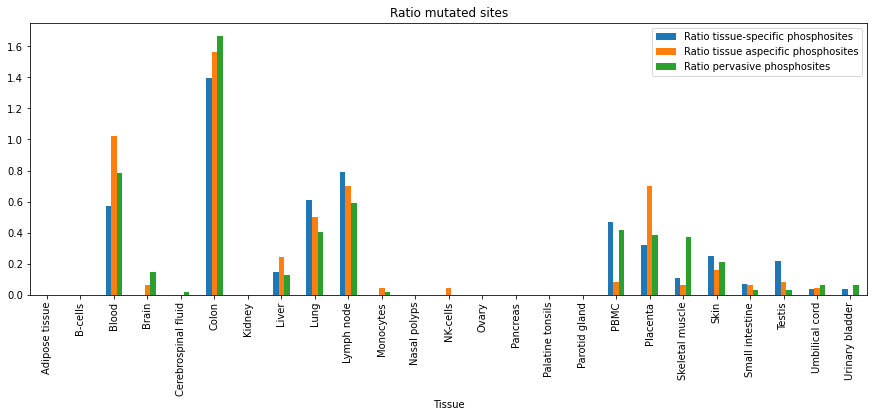

In [100]:
mut_tspecsites_tissue_ratio = pd.DataFrame({"Tissue": list_tissues_STY})
mut_tspecsites_tissue_ratio["Ratio tissue-specific phosphosites"] = mut_tspecsites_tissue["Mutated tissue-specific phosphosites on tissue-specific phosphorylated proteins_all"]*100/tpsecsites_tspecproteins.shape[0]
mut_tspecsites_tissue_ratio["Ratio tissue aspecific phosphosites"] = mut_tspecsites_tissue["Mutated tissue-specific phosphosites on tissue aspecific phosphorylated proteins_all"]*100/tspecsites_taspecproteins.shape[0]
mut_tspecsites_tissue_ratio["Ratio pervasive phosphosites"] = mut_tspecsites_tissue["Mutated tissue-specific phosphosites on pervasively phosphorylated proteins_all"]*100/tspecsites_genproteins.shape[0]
mut_tspecsites_tissue_ratio[((mut_sites_tissue_ratio["number of tissue-specific sites"]>=100)|
                     (mut_sites_tissue_ratio["number of non tissue-specific sites"]>=100)|
                     (mut_sites_tissue_ratio["number of generally expressed sites"]>=100))][["Tissue", "Ratio tissue-specific phosphosites",
                                                                                          "Ratio tissue aspecific phosphosites", 
                                                                                          "Ratio pervasive phosphosites"]].plot(kind="bar", figsize=(15,5), x="Tissue", title="Ratio mutated sites")
#plt.savefig("Humsavar_ratio_mutated_tspecsites.png", format="png", bbox_inches="tight")

# Comparison of the frequency of mutation on non-P STY sites

Here, we'll compare the frequency of mutation for non-phosphorylated (according to our dataset) canonical sites identifed on the same peptide as a P-sites. For this, we read in the data. We retain only the STY P-sites.

In [101]:
data = pd.read_csv("phospho_data_tissue_annotation.tsv", sep="\t")
data.dropna(inplace=True)
print(data.shape[0])
data.head()

586479


,proj,peptide,modres,UP_POS,ACC_ID,pep_start,pep_end,tissue
0,PXD000004,RPPSPEPSTK,S,2102,Q01082,2099,2108,Brain
1,PXD000004,ACVVHGSDLK,C,660,P50993,659,668,Brain
2,PXD000004,ACVVHGSDLK,C,663,P05023,662,671,Brain
3,PXD000004,AISPTSATSSGR,S,600,Q9Y4I1,598,609,Brain
4,PXD000004,FYYTAGSSSPTHAK,S,198,O75508,190,203,Brain


In [102]:
data = data[(data["modres"]=="S")|(data["modres"]=="T")|(data["modres"]=="Y")]
data_P = data.groupby(["ACC_ID", "UP_POS", "modres"], as_index=False).agg({"modres": "first"})
data_P.head()

,ACC_ID,UP_POS,modres
0,A0A075B6H7,30,T
1,A0A075B6S5,52,S
2,A0A087WXM9,223,S
3,A0A0B4J2D5,124,S
4,A0A0B4J2D5,145,T


We now make a dataframe for the non-phosphorylated STY-sites, containing, per pSTY position, only the longest peptide. The pSTY-site will later be used to categorise the non-phosphorylated STY-sites. However, some positions occur on the same peptide, which should all be excluded from the dataframe of non-phosphorylated STY-sites.

In [103]:
data_nonP = data.groupby(["ACC_ID", "UP_POS", "modres"], as_index=False).agg({"peptide": lambda x: max(x, key=len),
                                                                       "pep_start": lambda x: min(x), "pep_end": lambda x: max(x)})

data_nonP

,ACC_ID,UP_POS,modres,peptide,pep_start,pep_end
0,A0A075B6H7,30,T,EIVMTQSPPTLSLSPGER,21,38
1,A0A075B6S5,52,S,ASQGISNYLAWYQQK,47,61
2,A0A087WXM9,223,S,TVMTVADQNVSPK,213,225
3,A0A0B4J2D5,124,S,GKITDLANLSAANHDAAIFPGGFGAAK,115,141
4,A0A0B4J2D5,145,T,NLSTFAVDGKDCK,142,154
...,...,...,...,...,...,...
23898,Q9Y6Y0,326,S,NSPQSSPTSTPK,321,332
23899,Q9Y6Y0,336,S,SLSFEMQQDELIEK,336,349
23900,Q9Y6Y0,338,S,SLSFEMQQDELIEK,336,349
23901,Q9Y6Y8,737,S,DMASLPSESNEPK,734,746


In [104]:
data_nonP["length"] = data_nonP["peptide"].str.len()
data_nonP["length"].max()

30

We now check, for each of the 30 positions in the longest peptide in this dataset, whether on this position an STY-site occurs, and if that positions is not phosphorylated. Because some peptides have shown phosphorylation on more than one position, we will filter out the positions later on.

In [105]:
list_S = []
list_T = []
list_Y = []
for i in range(30):
    col = "S"+ str(i)
    data_nonP[col] = np.nan
    data_nonP.loc[(data_nonP["peptide"].str[i]=="S") & (data_nonP["pep_start"]+i<=data_nonP["pep_end"]) & (data_nonP["pep_start"]+i != data_nonP["UP_POS"]) , col] = data_nonP["pep_start"]+i
    list_S.append(col)
    col_T = "T"+ str(i)
    data_nonP[col_T] = np.nan
    data_nonP.loc[(data_nonP["peptide"].str[i]=="T") & (data_nonP["pep_start"]+i<=data_nonP["pep_end"]) & (data_nonP["pep_start"]+i != data_nonP["UP_POS"]) , col_T] = data_nonP["pep_start"]+i
    list_T.append(col_T)
    col_Y = "Y"+ str(i)
    data_nonP[col_Y] = np.nan
    data_nonP.loc[(data_nonP["peptide"].str[i]=="Y") & (data_nonP["pep_start"]+i<=data_nonP["pep_end"]) & (data_nonP["pep_start"]+i != data_nonP["UP_POS"]) , col_Y] = data_nonP["pep_start"]+i
    list_Y.append(col_Y)
data_nonP

,ACC_ID,UP_POS,modres,peptide,pep_start,pep_end,length,S0,T0,Y0,...,Y26,S27,T27,Y27,S28,T28,Y28,S29,T29,Y29
0,A0A075B6H7,30,T,EIVMTQSPPTLSLSPGER,21,38,18,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,A0A075B6S5,52,S,ASQGISNYLAWYQQK,47,61,15,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,A0A087WXM9,223,S,TVMTVADQNVSPK,213,225,13,NaN,213.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,A0A0B4J2D5,124,S,GKITDLANLSAANHDAAIFPGGFGAAK,115,141,27,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,A0A0B4J2D5,145,T,NLSTFAVDGKDCK,142,154,13,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23898,Q9Y6Y0,326,S,NSPQSSPTSTPK,321,332,12,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
23899,Q9Y6Y0,336,S,SLSFEMQQDELIEK,336,349,14,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
23900,Q9Y6Y0,338,S,SLSFEMQQDELIEK,336,349,14,336.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
23901,Q9Y6Y8,737,S,DMASLPSESNEPK,734,746,13,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Here we make a dataframe of all possible phosphosites per protein in our dataset, shown as comma seperated strings. Because a non STY-site in the previous dataframe is indicated by NaN, the column type is float. Thus, we first convert all the positions to float (.0 ending), before combining them as a string.

In [106]:
positions = data_P[["ACC_ID", "UP_POS"]].copy()
positions["UP_POS"]= positions["UP_POS"].astype("float64")
positions["UP_POS"]= positions["UP_POS"].astype(str)
positions = positions.groupby(["ACC_ID"], as_index=False)["UP_POS"].apply(lambda x: ",".join(x))
positions.rename({"UP_POS": "list_positions"}, axis=1, inplace=True)
positions

,ACC_ID,list_positions
0,A0A075B6H7,30.0
1,A0A075B6S5,52.0
2,A0A087WXM9,223.0
3,A0A0B4J2D5,"124.0,145.0"
4,A0A0B4J2D9,52.0
...,...,...
5850,Q9Y6X4,"398.0,526.0,635.0"
5851,Q9Y6X8,37.0
5852,Q9Y6X9,"615.0,725.0,733.0,743.0"
5853,Q9Y6Y0,"276.0,326.0,336.0,338.0"


In [107]:
data_nonP = pd.merge(data_nonP, positions, how="inner", on=["ACC_ID"])
data_nonP

,ACC_ID,UP_POS,modres,peptide,pep_start,pep_end,length,S0,T0,Y0,...,S27,T27,Y27,S28,T28,Y28,S29,T29,Y29,list_positions
0,A0A075B6H7,30,T,EIVMTQSPPTLSLSPGER,21,38,18,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,30.0
1,A0A075B6S5,52,S,ASQGISNYLAWYQQK,47,61,15,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,52.0
2,A0A087WXM9,223,S,TVMTVADQNVSPK,213,225,13,NaN,213.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,223.0
3,A0A0B4J2D5,124,S,GKITDLANLSAANHDAAIFPGGFGAAK,115,141,27,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"124.0,145.0"
4,A0A0B4J2D5,145,T,NLSTFAVDGKDCK,142,154,13,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"124.0,145.0"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23898,Q9Y6Y0,326,S,NSPQSSPTSTPK,321,332,12,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"276.0,326.0,336.0,338.0"
23899,Q9Y6Y0,336,S,SLSFEMQQDELIEK,336,349,14,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"276.0,326.0,336.0,338.0"
23900,Q9Y6Y0,338,S,SLSFEMQQDELIEK,336,349,14,336.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"276.0,326.0,336.0,338.0"
23901,Q9Y6Y8,737,S,DMASLPSESNEPK,734,746,13,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"737.0,926.0"


In [108]:
data_nonP[data_nonP["list_positions"].str.contains(",")]

,ACC_ID,UP_POS,modres,peptide,pep_start,pep_end,length,S0,T0,Y0,...,S27,T27,Y27,S28,T28,Y28,S29,T29,Y29,list_positions
3,A0A0B4J2D5,124,S,GKITDLANLSAANHDAAIFPGGFGAAK,115,141,27,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"124.0,145.0"
4,A0A0B4J2D5,145,T,NLSTFAVDGKDCK,142,154,13,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"124.0,145.0"
17,A0A1B0GTU1,491,S,VQQSSESSTSSPSQHEATPGAR,485,506,22,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"491.0,494.0,760.0,762.0,763.0"
18,A0A1B0GTU1,494,S,VQQSSESSTSSPSQHEATPGAR,485,506,22,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"491.0,494.0,760.0,762.0,763.0"
19,A0A1B0GTU1,760,S,RLSSASTGKPPLSVEDDFEK,757,776,20,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"491.0,494.0,760.0,762.0,763.0"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23898,Q9Y6Y0,326,S,NSPQSSPTSTPK,321,332,12,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"276.0,326.0,336.0,338.0"
23899,Q9Y6Y0,336,S,SLSFEMQQDELIEK,336,349,14,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"276.0,326.0,336.0,338.0"
23900,Q9Y6Y0,338,S,SLSFEMQQDELIEK,336,349,14,336.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"276.0,326.0,336.0,338.0"
23901,Q9Y6Y8,737,S,DMASLPSESNEPK,734,746,13,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"737.0,926.0"


We now check for each positions that has been marked as not the same as the phosphosite entry in the above dataframe, whether it does not occur in the list of positions of phosphosites of that protein.

In [109]:
pos_split = data_nonP["list_positions"].str.split(",", expand=True)
pos_split

,0,1,2,3,4,5,6,7,8,9,...,139,140,141,142,143,144,145,146,147,148
0,30.0,None,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
1,52.0,None,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
2,223.0,None,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
3,124.0,145.0,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
4,124.0,145.0,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23898,276.0,326.0,336.0,338.0,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
23899,276.0,326.0,336.0,338.0,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
23900,276.0,326.0,336.0,338.0,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
23901,737.0,926.0,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None


In [110]:
data_nonP = pd.merge(data_nonP, pos_split, how="inner", left_index=True, right_index=True)
data_nonP

,ACC_ID,UP_POS,modres,peptide,pep_start,pep_end,length,S0,T0,Y0,...,139,140,141,142,143,144,145,146,147,148
0,A0A075B6H7,30,T,EIVMTQSPPTLSLSPGER,21,38,18,NaN,NaN,NaN,...,None,None,None,None,None,None,None,None,None,None
1,A0A075B6S5,52,S,ASQGISNYLAWYQQK,47,61,15,NaN,NaN,NaN,...,None,None,None,None,None,None,None,None,None,None
2,A0A087WXM9,223,S,TVMTVADQNVSPK,213,225,13,NaN,213.0,NaN,...,None,None,None,None,None,None,None,None,None,None
3,A0A0B4J2D5,124,S,GKITDLANLSAANHDAAIFPGGFGAAK,115,141,27,NaN,NaN,NaN,...,None,None,None,None,None,None,None,None,None,None
4,A0A0B4J2D5,145,T,NLSTFAVDGKDCK,142,154,13,NaN,NaN,NaN,...,None,None,None,None,None,None,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23898,Q9Y6Y0,326,S,NSPQSSPTSTPK,321,332,12,NaN,NaN,NaN,...,None,None,None,None,None,None,None,None,None,None
23899,Q9Y6Y0,336,S,SLSFEMQQDELIEK,336,349,14,NaN,NaN,NaN,...,None,None,None,None,None,None,None,None,None,None
23900,Q9Y6Y0,338,S,SLSFEMQQDELIEK,336,349,14,336.0,NaN,NaN,...,None,None,None,None,None,None,None,None,None,None
23901,Q9Y6Y8,737,S,DMASLPSESNEPK,734,746,13,NaN,NaN,NaN,...,None,None,None,None,None,None,None,None,None,None


In [111]:
data_nonP.replace({"None": np.nan}, inplace=True)
for i in range(149):
    data_nonP[i] = data_nonP[i].astype(float)
print(data_nonP[i].dtype)

float64


Here, we check for each site in the list of non-phosphorylated STY-sites, whether it occurs i nthe list of phosphorylated STY-sites. If so, the position is replaced by NaN and not considered for further analysis.

In [112]:
for n in list_S:
    for i in range(149):
        data_nonP.loc[(((data_nonP[n].isna()==False)&(data_nonP[i].isna()==False))&(data_nonP[i]==data_nonP[n])), n] = np.nan
for n in list_T:
    for i in range(149):
        data_nonP.loc[(((data_nonP[n].isna()==False)&(data_nonP[i].isna()==False))&(data_nonP[i]==data_nonP[n])), n] = np.nan
for n in list_Y:
    for i in range(149):
        data_nonP.loc[(((data_nonP[n].isna()==False)&(data_nonP[i].isna()==False))&(data_nonP[i]==data_nonP[n])), n] = np.nan

In [113]:
data_nonP

,ACC_ID,UP_POS,modres,peptide,pep_start,pep_end,length,S0,T0,Y0,...,139,140,141,142,143,144,145,146,147,148
0,A0A075B6H7,30,T,EIVMTQSPPTLSLSPGER,21,38,18,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,A0A075B6S5,52,S,ASQGISNYLAWYQQK,47,61,15,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,A0A087WXM9,223,S,TVMTVADQNVSPK,213,225,13,NaN,213.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,A0A0B4J2D5,124,S,GKITDLANLSAANHDAAIFPGGFGAAK,115,141,27,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,A0A0B4J2D5,145,T,NLSTFAVDGKDCK,142,154,13,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23898,Q9Y6Y0,326,S,NSPQSSPTSTPK,321,332,12,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
23899,Q9Y6Y0,336,S,SLSFEMQQDELIEK,336,349,14,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
23900,Q9Y6Y0,338,S,SLSFEMQQDELIEK,336,349,14,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
23901,Q9Y6Y8,737,S,DMASLPSESNEPK,734,746,13,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [115]:
data_nonP.dropna(axis=1, how="all", inplace=True)
data_nonP

,ACC_ID,UP_POS,modres,peptide,pep_start,pep_end,length,S0,T0,Y0,...,139,140,141,142,143,144,145,146,147,148
0,A0A075B6H7,30,T,EIVMTQSPPTLSLSPGER,21,38,18,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,A0A075B6S5,52,S,ASQGISNYLAWYQQK,47,61,15,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,A0A087WXM9,223,S,TVMTVADQNVSPK,213,225,13,NaN,213.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,A0A0B4J2D5,124,S,GKITDLANLSAANHDAAIFPGGFGAAK,115,141,27,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,A0A0B4J2D5,145,T,NLSTFAVDGKDCK,142,154,13,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23898,Q9Y6Y0,326,S,NSPQSSPTSTPK,321,332,12,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
23899,Q9Y6Y0,336,S,SLSFEMQQDELIEK,336,349,14,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
23900,Q9Y6Y0,338,S,SLSFEMQQDELIEK,336,349,14,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
23901,Q9Y6Y8,737,S,DMASLPSESNEPK,734,746,13,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [116]:
list_all_cols = list(data_nonP)
for x in list_S:
    if x not in list_all_cols and x in list_S:
        list_S.remove(x)
for x in list_T:
    if x not in list_all_cols and x in list_T:
        list_T.remove(x)
for x in list_Y:    
    if x not in list_all_cols and x in list_Y:
        list_Y.remove(x)
print(list_S)
print(list_T)
print(list_Y)

['S0', 'S1', 'S2', 'S3', 'S4', 'S5', 'S6', 'S7', 'S8', 'S9', 'S10', 'S11', 'S12', 'S13', 'S14', 'S15', 'S16', 'S17', 'S18', 'S19', 'S20', 'S21', 'S22', 'S23', 'S24', 'S25', 'S26', 'S27', 'S28']
['T0', 'T1', 'T2', 'T3', 'T4', 'T5', 'T6', 'T7', 'T8', 'T9', 'T10', 'T11', 'T12', 'T13', 'T14', 'T15', 'T16', 'T17', 'T18', 'T19', 'T20', 'T21', 'T22', 'T23', 'T24', 'T25', 'T26', 'T27', 'T28']
['Y0', 'Y1', 'Y2', 'Y3', 'Y4', 'Y5', 'Y6', 'Y7', 'Y8', 'Y9', 'Y10', 'Y11', 'Y12', 'Y13', 'Y14', 'Y15', 'Y16', 'Y17', 'Y18', 'Y19', 'Y20', 'Y21', 'Y22', 'Y23', 'Y24', 'Y25', 'Y26', 'Y27', 'Y28']


We now check for mutations occuring exactly on the nonP-STY-sites. For this, we iterate over all columns signifying the possible position on a peptide and the residue involved (S0 to S28 for the Ser on position 0 to 28, similar for Thr and Tyr). For this position, we check wheter it occurs in the Humsavar dataset. These positions that have been found in the Humsavar dataset are added to a larger dataframe, mutated_res, with pos_int indicating the mutated position and "res" indicating the residue before mutation.

In [117]:
mutated_res = pd.DataFrame({})
for n in list_S:
    print(n)
    data_gr_sub = data_nonP[(~data_nonP[n].isnull())&(data_nonP[n].isna()==False)]
    if data_gr_sub.shape[0] != 0:
        data_gr_sub[n]= data_gr_sub[n].astype(int)
        humsavar.rename({"UP_POS": "pos_int"}, axis=1, inplace=True)
        data_gr_sub.rename({n: "pos_int"}, axis=1, inplace=True)
        sub = pd.merge(data_gr_sub, humsavar, how="inner", on=["ACC_ID", "pos_int"])
        sub["res"] = "S"
        humsavar.rename({"pos_int": "UP_POS"}, axis=1, inplace=True)
        data_gr_sub.rename({"pos_int": n}, axis=1, inplace=True)
        mutated_res = mutated_res.append(sub)
for n in list_T:
    print(n)
    data_gr_sub = data_nonP[(~data_nonP[n].isnull())&(data_nonP[n].isna()==False)]
    if data_gr_sub.shape[0] != 0:
        data_gr_sub[n]=data_gr_sub[n].astype(int)
        humsavar.rename({"UP_POS": "pos_int"}, axis=1, inplace=True)
        data_gr_sub.rename({n: "pos_int"}, axis=1, inplace=True)
        sub = pd.merge(data_gr_sub, humsavar, how="inner", on=["ACC_ID", "pos_int"])
        sub["res"] = "T"
        humsavar.rename({"pos_int": "UP_POS"}, axis=1, inplace=True)
        data_gr_sub.rename({"pos_int": n}, axis=1, inplace=True)
        mutated_res = mutated_res.append(sub)
for n in list_Y:
    print(n)
    data_gr_sub = data_nonP[(~data_nonP[n].isnull())&(data_nonP[n].isna()==False)]
    if data_gr_sub.shape[0] != 0:
        data_gr_sub[n]=data_gr_sub[n].astype(int)
        humsavar.rename({"UP_POS": "pos_int"}, axis=1, inplace=True)
        data_gr_sub.rename({n: "pos_int"}, axis=1, inplace=True)
        sub = pd.merge(data_gr_sub, humsavar, how="inner", on=["ACC_ID", "pos_int"])
        sub["res"] = "Y"
        humsavar.rename({"pos_int": "UP_POS"}, axis=1, inplace=True)
        data_gr_sub.rename({"pos_int": n}, axis=1, inplace=True)
        mutated_res = mutated_res.append(sub)

S0
S1
S2


/var/folders/sq/z_sqn7bn61j9sqhwcb08v3tc0000gn/T/ipykernel_1112/3735652164.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_gr_sub[n]= data_gr_sub[n].astype(int)
/var/folders/sq/z_sqn7bn61j9sqhwcb08v3tc0000gn/T/ipykernel_1112/3735652164.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_gr_sub.rename({n: "pos_int"}, axis=1, inplace=True)
/var/folders/sq/z_sqn7bn61j9sqhwcb08v3tc0000gn/T/ipykernel_1112/3735652164.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: htt

S3
S4
S5
S6


/var/folders/sq/z_sqn7bn61j9sqhwcb08v3tc0000gn/T/ipykernel_1112/3735652164.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_gr_sub.rename({"pos_int": n}, axis=1, inplace=True)
/var/folders/sq/z_sqn7bn61j9sqhwcb08v3tc0000gn/T/ipykernel_1112/3735652164.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mutated_res = mutated_res.append(sub)
/var/folders/sq/z_sqn7bn61j9sqhwcb08v3tc0000gn/T/ipykernel_1112/3735652164.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  da

S7
S8
S9
S10


/var/folders/sq/z_sqn7bn61j9sqhwcb08v3tc0000gn/T/ipykernel_1112/3735652164.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_gr_sub.rename({"pos_int": n}, axis=1, inplace=True)
/var/folders/sq/z_sqn7bn61j9sqhwcb08v3tc0000gn/T/ipykernel_1112/3735652164.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mutated_res = mutated_res.append(sub)
/var/folders/sq/z_sqn7bn61j9sqhwcb08v3tc0000gn/T/ipykernel_1112/3735652164.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  da

S11
S12
S13
S14


/var/folders/sq/z_sqn7bn61j9sqhwcb08v3tc0000gn/T/ipykernel_1112/3735652164.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_gr_sub.rename({"pos_int": n}, axis=1, inplace=True)
/var/folders/sq/z_sqn7bn61j9sqhwcb08v3tc0000gn/T/ipykernel_1112/3735652164.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mutated_res = mutated_res.append(sub)
/var/folders/sq/z_sqn7bn61j9sqhwcb08v3tc0000gn/T/ipykernel_1112/3735652164.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  da

S15
S16
S17
S18


/var/folders/sq/z_sqn7bn61j9sqhwcb08v3tc0000gn/T/ipykernel_1112/3735652164.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_gr_sub.rename({"pos_int": n}, axis=1, inplace=True)
/var/folders/sq/z_sqn7bn61j9sqhwcb08v3tc0000gn/T/ipykernel_1112/3735652164.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mutated_res = mutated_res.append(sub)
/var/folders/sq/z_sqn7bn61j9sqhwcb08v3tc0000gn/T/ipykernel_1112/3735652164.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  da

S19
S20
S21
S22


/var/folders/sq/z_sqn7bn61j9sqhwcb08v3tc0000gn/T/ipykernel_1112/3735652164.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_gr_sub.rename({"pos_int": n}, axis=1, inplace=True)
/var/folders/sq/z_sqn7bn61j9sqhwcb08v3tc0000gn/T/ipykernel_1112/3735652164.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mutated_res = mutated_res.append(sub)
/var/folders/sq/z_sqn7bn61j9sqhwcb08v3tc0000gn/T/ipykernel_1112/3735652164.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  da

S23
S24
S25
S26


/var/folders/sq/z_sqn7bn61j9sqhwcb08v3tc0000gn/T/ipykernel_1112/3735652164.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_gr_sub.rename({"pos_int": n}, axis=1, inplace=True)
/var/folders/sq/z_sqn7bn61j9sqhwcb08v3tc0000gn/T/ipykernel_1112/3735652164.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mutated_res = mutated_res.append(sub)
/var/folders/sq/z_sqn7bn61j9sqhwcb08v3tc0000gn/T/ipykernel_1112/3735652164.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  da

S27
S28
T0
T1


/var/folders/sq/z_sqn7bn61j9sqhwcb08v3tc0000gn/T/ipykernel_1112/3735652164.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_gr_sub.rename({"pos_int": n}, axis=1, inplace=True)
/var/folders/sq/z_sqn7bn61j9sqhwcb08v3tc0000gn/T/ipykernel_1112/3735652164.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mutated_res = mutated_res.append(sub)
/var/folders/sq/z_sqn7bn61j9sqhwcb08v3tc0000gn/T/ipykernel_1112/3735652164.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  da

T2
T3
T4
T5


/var/folders/sq/z_sqn7bn61j9sqhwcb08v3tc0000gn/T/ipykernel_1112/3735652164.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_gr_sub.rename({"pos_int": n}, axis=1, inplace=True)
/var/folders/sq/z_sqn7bn61j9sqhwcb08v3tc0000gn/T/ipykernel_1112/3735652164.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mutated_res = mutated_res.append(sub)
/var/folders/sq/z_sqn7bn61j9sqhwcb08v3tc0000gn/T/ipykernel_1112/3735652164.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  d

T6
T7
T8
T9


/var/folders/sq/z_sqn7bn61j9sqhwcb08v3tc0000gn/T/ipykernel_1112/3735652164.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_gr_sub.rename({"pos_int": n}, axis=1, inplace=True)
/var/folders/sq/z_sqn7bn61j9sqhwcb08v3tc0000gn/T/ipykernel_1112/3735652164.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mutated_res = mutated_res.append(sub)
/var/folders/sq/z_sqn7bn61j9sqhwcb08v3tc0000gn/T/ipykernel_1112/3735652164.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  d

T10
T11
T12
T13


/var/folders/sq/z_sqn7bn61j9sqhwcb08v3tc0000gn/T/ipykernel_1112/3735652164.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_gr_sub.rename({"pos_int": n}, axis=1, inplace=True)
/var/folders/sq/z_sqn7bn61j9sqhwcb08v3tc0000gn/T/ipykernel_1112/3735652164.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mutated_res = mutated_res.append(sub)
/var/folders/sq/z_sqn7bn61j9sqhwcb08v3tc0000gn/T/ipykernel_1112/3735652164.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  d

T14
T15
T16
T17


/var/folders/sq/z_sqn7bn61j9sqhwcb08v3tc0000gn/T/ipykernel_1112/3735652164.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_gr_sub.rename({"pos_int": n}, axis=1, inplace=True)
/var/folders/sq/z_sqn7bn61j9sqhwcb08v3tc0000gn/T/ipykernel_1112/3735652164.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mutated_res = mutated_res.append(sub)
/var/folders/sq/z_sqn7bn61j9sqhwcb08v3tc0000gn/T/ipykernel_1112/3735652164.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  d

T18
T19
T20
T21


/var/folders/sq/z_sqn7bn61j9sqhwcb08v3tc0000gn/T/ipykernel_1112/3735652164.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_gr_sub.rename({"pos_int": n}, axis=1, inplace=True)
/var/folders/sq/z_sqn7bn61j9sqhwcb08v3tc0000gn/T/ipykernel_1112/3735652164.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mutated_res = mutated_res.append(sub)
/var/folders/sq/z_sqn7bn61j9sqhwcb08v3tc0000gn/T/ipykernel_1112/3735652164.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  d

T22
T23
T24
T25


/var/folders/sq/z_sqn7bn61j9sqhwcb08v3tc0000gn/T/ipykernel_1112/3735652164.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_gr_sub.rename({"pos_int": n}, axis=1, inplace=True)
/var/folders/sq/z_sqn7bn61j9sqhwcb08v3tc0000gn/T/ipykernel_1112/3735652164.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mutated_res = mutated_res.append(sub)
/var/folders/sq/z_sqn7bn61j9sqhwcb08v3tc0000gn/T/ipykernel_1112/3735652164.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  d

T26
T27
T28
Y0


/var/folders/sq/z_sqn7bn61j9sqhwcb08v3tc0000gn/T/ipykernel_1112/3735652164.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_gr_sub.rename({"pos_int": n}, axis=1, inplace=True)
/var/folders/sq/z_sqn7bn61j9sqhwcb08v3tc0000gn/T/ipykernel_1112/3735652164.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mutated_res = mutated_res.append(sub)
/var/folders/sq/z_sqn7bn61j9sqhwcb08v3tc0000gn/T/ipykernel_1112/3735652164.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  d

Y1
Y2
Y3
Y4


/var/folders/sq/z_sqn7bn61j9sqhwcb08v3tc0000gn/T/ipykernel_1112/3735652164.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_gr_sub.rename({"pos_int": n}, axis=1, inplace=True)
/var/folders/sq/z_sqn7bn61j9sqhwcb08v3tc0000gn/T/ipykernel_1112/3735652164.py:37: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mutated_res = mutated_res.append(sub)
/var/folders/sq/z_sqn7bn61j9sqhwcb08v3tc0000gn/T/ipykernel_1112/3735652164.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  d

Y5
Y6
Y7
Y8


/var/folders/sq/z_sqn7bn61j9sqhwcb08v3tc0000gn/T/ipykernel_1112/3735652164.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_gr_sub.rename({"pos_int": n}, axis=1, inplace=True)
/var/folders/sq/z_sqn7bn61j9sqhwcb08v3tc0000gn/T/ipykernel_1112/3735652164.py:37: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mutated_res = mutated_res.append(sub)
/var/folders/sq/z_sqn7bn61j9sqhwcb08v3tc0000gn/T/ipykernel_1112/3735652164.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  d

Y9
Y10
Y11
Y12


/var/folders/sq/z_sqn7bn61j9sqhwcb08v3tc0000gn/T/ipykernel_1112/3735652164.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_gr_sub.rename({"pos_int": n}, axis=1, inplace=True)
/var/folders/sq/z_sqn7bn61j9sqhwcb08v3tc0000gn/T/ipykernel_1112/3735652164.py:37: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mutated_res = mutated_res.append(sub)
/var/folders/sq/z_sqn7bn61j9sqhwcb08v3tc0000gn/T/ipykernel_1112/3735652164.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  d

Y13
Y14
Y15
Y16


/var/folders/sq/z_sqn7bn61j9sqhwcb08v3tc0000gn/T/ipykernel_1112/3735652164.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_gr_sub.rename({"pos_int": n}, axis=1, inplace=True)
/var/folders/sq/z_sqn7bn61j9sqhwcb08v3tc0000gn/T/ipykernel_1112/3735652164.py:37: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mutated_res = mutated_res.append(sub)
/var/folders/sq/z_sqn7bn61j9sqhwcb08v3tc0000gn/T/ipykernel_1112/3735652164.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  d

Y17
Y18
Y19
Y20


/var/folders/sq/z_sqn7bn61j9sqhwcb08v3tc0000gn/T/ipykernel_1112/3735652164.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_gr_sub.rename({"pos_int": n}, axis=1, inplace=True)
/var/folders/sq/z_sqn7bn61j9sqhwcb08v3tc0000gn/T/ipykernel_1112/3735652164.py:37: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mutated_res = mutated_res.append(sub)
/var/folders/sq/z_sqn7bn61j9sqhwcb08v3tc0000gn/T/ipykernel_1112/3735652164.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  d

Y21
Y22
Y23
Y24


/var/folders/sq/z_sqn7bn61j9sqhwcb08v3tc0000gn/T/ipykernel_1112/3735652164.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_gr_sub.rename({"pos_int": n}, axis=1, inplace=True)
/var/folders/sq/z_sqn7bn61j9sqhwcb08v3tc0000gn/T/ipykernel_1112/3735652164.py:37: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mutated_res = mutated_res.append(sub)
/var/folders/sq/z_sqn7bn61j9sqhwcb08v3tc0000gn/T/ipykernel_1112/3735652164.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  d

Y25
Y26
Y27
Y28


/var/folders/sq/z_sqn7bn61j9sqhwcb08v3tc0000gn/T/ipykernel_1112/3735652164.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_gr_sub.rename({"pos_int": n}, axis=1, inplace=True)
/var/folders/sq/z_sqn7bn61j9sqhwcb08v3tc0000gn/T/ipykernel_1112/3735652164.py:37: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mutated_res = mutated_res.append(sub)
/var/folders/sq/z_sqn7bn61j9sqhwcb08v3tc0000gn/T/ipykernel_1112/3735652164.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  d

In [118]:
for x in list_S:
    mutated_res.drop(x, axis=1, inplace=True)
for x in list_T:
    mutated_res.drop(x, axis=1, inplace=True)
for x in list_Y:
    mutated_res.drop(x, axis=1, inplace=True)
mutated_res

,ACC_ID,UP_POS,modres,peptide,pep_start,pep_end,length,pos_int,list_positions,0,...,147,148,Main gene name,FTId,AA change,Variant category,dbSNP,Disease name,Annotation,res
0,P02730,733,T,SVTHANALTVMGK,731,743,13,731,"350.0,356.0,733.0",350.0,...,NaN,NaN,SLC4A1,VAR_039295,p.Ser731Pro,LP/P,rs863225461,Cryohydrocytosis (CHC) [MIM:185020],(likely) Pathogenic,S
1,P04264,193,S,SLNNQFASFIDKVR,186,199,14,186,"13.0,18.0,19.0,21.0,47.0,48.0,55.0,66.0,79.0,1...",13.0,...,NaN,NaN,KRT1,VAR_003855,p.Ser186Pro,LP/P,rs60022878,Epidermolytic hyperkeratosis (EHK) [MIM:113800],(likely) Pathogenic,S
2,P11172,37,Y,SGLSSPIYIDLR,30,41,12,30,"37.0,214.0",37.0,...,NaN,NaN,UMPS,VAR_020614,p.Ser30Gly,LB/B,rs17843776,-,(likely) Benign,S
3,P17812,581,T,SGSSSPDSEITELKFPSINHD,571,591,21,571,"574.0,575.0,581.0",574.0,...,NaN,NaN,CTPS1,VAR_027055,p.Ser571Ile,LB/B,rs17856308,-,(likely) Benign,S
4,P48552,807,S,SEPVSPQDFSFSK,803,815,13,803,"564.0,807.0",564.0,...,NaN,NaN,NRIP1,VAR_023709,p.Ser803Leu,LB/B,rs61750208,-,(likely) Benign,S
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3,P68133,273,S,CPETLFQPSFIGMESAGIHETTYNSIMK,259,286,28,281,"35.0,54.0,55.0,62.0,79.0,93.0,105.0,122.0,135....",35.0,...,NaN,NaN,ACTA1,VAR_062471,p.Tyr281His,LP/P,-,Nemaline myopathy 3 (NEM3) [MIM:161800],(likely) Pathogenic,Y
0,P62736,122,T,MTQIMFETFNVPAMYVAIQAVLSLYASGR,121,149,29,145,"35.0,54.0,55.0,62.0,79.0,105.0,122.0,135.0,150...",35.0,...,NaN,NaN,ACTA2,VAR_062578,p.Tyr145Cys,LP/P,-,"Aortic aneurysm, familial thoracic 6 (AAT6) [M...",(likely) Pathogenic,Y
1,P62736,135,Y,MTQIMFETFNVPAMYVAIQAVLSLYASGR,121,149,29,145,"35.0,54.0,55.0,62.0,79.0,105.0,122.0,135.0,150...",35.0,...,NaN,NaN,ACTA2,VAR_062578,p.Tyr145Cys,LP/P,-,"Aortic aneurysm, familial thoracic 6 (AAT6) [M...",(likely) Pathogenic,Y
0,P68871,124,T,LLGNVLVCVLAHHFGKEFTPPVQAAYQK,106,133,28,131,"10.0,13.0,36.0,45.0,50.0,51.0,73.0,88.0,90.0,1...",10.0,...,NaN,NaN,HBB,VAR_003063,p.Tyr131Asp,LB/B,rs35834416,-,(likely) Benign,Y


We now calculate how many non-phosphorylated P-sites occur on a given peptide. For this, we calculate the total amount of STY sites combined and seperately. After this, we calculate how many P-sites occur on that peptide by representing P-sites by dummy-variabels. The number of non-phosphorylated STY-sites is the number of all STY-sites minus the number of phosphorylated ones. Relatively speaking, Ser is enriched in the phosphorylated dataset, to the disadvantage of Thr and Tyr.

In [119]:
data_nonP["countSTY"] = data_nonP["peptide"].str.count("S") + data_nonP["peptide"].str.count("T") + data_nonP["peptide"].str.count("Y")
data_nonP["countS"] = data_nonP["peptide"].str.count("S")
data_nonP["countT"] = data_nonP["peptide"].str.count("T")
data_nonP["countY"] = data_nonP["peptide"].str.count("Y")
data_nonP = pd.get_dummies(data_nonP, columns=["modres"])
data_nonP_peptide = data_nonP.groupby(["peptide"], as_index=False).agg({"countSTY": "first", "countS": "first", "countT": "first",
                                                                   "countY": "first", "UP_POS": "count", "modres_S": "sum",
                                                                   "modres_T": "sum", "modres_Y": "sum"})

data_nonP_peptide["countSTYnonP"] = data_nonP_peptide["countSTY"] - data_nonP_peptide["UP_POS"]
data_nonP_peptide["countSnonP"] = data_nonP_peptide["countS"] - data_nonP_peptide["modres_S"]
data_nonP_peptide["countTnonP"] = data_nonP_peptide["countT"] - data_nonP_peptide["modres_T"]
data_nonP_peptide["countYnonP"] = data_nonP_peptide["countY"] - data_nonP_peptide["modres_Y"]
data_nonP_peptide.head()

,peptide,countSTY,countS,countT,countY,UP_POS,modres_S,modres_T,modres_Y,countSTYnonP,countSnonP,countTnonP,countYnonP
0,AAAAAAAATMALAAPSSPTPESPTMLTK,7,3,4,0,3,3,0,0,4,0,4,0
1,AAAAAATAPPSPGPAQPGPR,2,1,1,0,1,1,0,0,1,0,1,0
2,AAAAAATAPPSPGPAQPGPRAQR,2,1,1,0,1,0,1,0,1,1,0,0
3,AAAAGLGHPASPGGSEDGPPGSEEEDAAR,3,3,0,0,1,1,0,0,2,2,0,0
4,AAAAGSLDRSR,2,2,0,0,1,1,0,0,1,1,0,0


In [120]:
print(data_nonP_peptide["countSTY"].sum())
print(data_nonP_peptide["countS"].sum())
print(data_nonP_peptide["countT"].sum())
print(data_nonP_peptide["countY"].sum())
print(data_nonP_peptide["countS"].sum()+data_nonP_peptide["countT"].sum()+data_nonP_peptide["countY"].sum())

63197
40486
17426
5285
63197


In [121]:
print(data_nonP_peptide["countS"].sum()*100/data_nonP_peptide["countSTY"].sum())
print(data_nonP_peptide["countT"].sum()*100/data_nonP_peptide["countSTY"].sum())
print(data_nonP_peptide["countY"].sum()*100/data_nonP_peptide["countSTY"].sum())

64.06316755542194
27.574093706979763
8.362738737598304


In [122]:
print(data_nonP_peptide["countSTYnonP"].sum())
print(data_nonP_peptide["countSnonP"].sum())
print(data_nonP_peptide["countTnonP"].sum())
print(data_nonP_peptide["countYnonP"].sum())
print(data_nonP_peptide["countSnonP"].sum()+data_nonP_peptide["countTnonP"].sum()+data_nonP_peptide["countYnonP"].sum())

39294
23791
11810
3693
39294


In [123]:
print(data_nonP_peptide["countSnonP"].sum()*100/data_nonP_peptide["countSTYnonP"].sum())
print(data_nonP_peptide["countTnonP"].sum()*100/data_nonP_peptide["countSTYnonP"].sum())
print(data_nonP_peptide["countYnonP"].sum()*100/data_nonP_peptide["countSTYnonP"].sum())

60.546139359698685
30.05547920802158
9.398381432279738


In [124]:
data_P = pd.get_dummies(data_P, columns=["modres"])
data_P_site = data_P.groupby(["ACC_ID", "UP_POS"], as_index=False).agg({"modres_S": "sum", "modres_T": "sum",
                                                                         "modres_Y": "sum"})
print(data_P_site.shape[0])
print(data_P_site["modres_S"].sum())
print(data_P_site["modres_T"].sum())
print(data_P_site["modres_Y"].sum())

23903
16695
5616
1592


In [125]:
print(data_P_site["modres_S"].sum()+data_P_site["modres_T"].sum()+data_P_site["modres_Y"].sum())

23903


In [126]:
print("S", data_P_site["modres_S"].sum()*100/data_P_site.shape[0])
print("T", data_P_site["modres_T"].sum()*100/data_P_site.shape[0])
print("Y", data_P_site["modres_Y"].sum()*100/data_P_site.shape[0])

S 69.84478935698448
T 23.494958791783457
Y 6.660251851232063


We'll now identify all mutated non P-sites, and how many S-/T-/Y-sites there are among them. After that, we consider the effect of the mutations (pathogenic, benign, unknown significance), first combined and then per residue.

In [127]:
mutated_res_modsites = mutated_res.groupby(["pos_int"], as_index=False).agg({"res": "first"})
print(mutated_res_modsites.shape[0])
print(mutated_res_modsites["res"].value_counts())

196
S    105
T     67
Y     24
Name: res, dtype: int64


In [128]:
print(mutated_res_modsites.shape[0]*100/data_nonP_peptide["countSTYnonP"].sum())
print(mutated_res_modsites["res"].value_counts()[0]*100/data_nonP_peptide["countSnonP"].sum())
print(mutated_res_modsites["res"].value_counts()[1]*100/data_nonP_peptide["countTnonP"].sum())
print(mutated_res_modsites["res"].value_counts()[2]*100/data_nonP_peptide["countYnonP"].sum())

0.4988038886343971
0.4413433651380774
0.56731583403895
0.6498781478472786


In [129]:
data_P_site_mut = pd.merge(data_P_site, humsavar, how="inner", on=["ACC_ID", "UP_POS"])

In [130]:
print(data_P_site_mut.shape[0])
print(data_P_site_mut["modres_S"].sum())
print(data_P_site_mut["modres_T"].sum())
print(data_P_site_mut["modres_Y"].sum())

169
101
53
15


In [131]:
print(data_P_site_mut.shape[0]*100/data_P_site.shape[0])
print(data_P_site_mut["modres_S"].sum()*100/data_P_site["modres_S"].sum())
print(data_P_site_mut["modres_T"].sum()*100/data_P_site["modres_T"].sum())
print(data_P_site_mut["modres_Y"].sum()*100/data_P_site["modres_Y"].sum())

0.7070242229008911
0.6049715483677748
0.9437321937321937
0.9422110552763819


In [132]:
print(data_P_site_mut["Annotation"].value_counts())
print("Annotation of S")
print(data_P_site_mut[data_P_site_mut["modres_S"]==1]["Annotation"].value_counts())
print("Annotation of T")
print(data_P_site_mut[data_P_site_mut["modres_T"]==1]["Annotation"].value_counts())
print("Annotation of Y")
print(data_P_site_mut[data_P_site_mut["modres_Y"]==1]["Annotation"].value_counts())

(likely) Benign         82
(likely) Pathogenic     57
Unknown significance    30
Name: Annotation, dtype: int64
Annotation of S
(likely) Benign         51
(likely) Pathogenic     27
Unknown significance    23
Name: Annotation, dtype: int64
Annotation of T
(likely) Benign         26
(likely) Pathogenic     20
Unknown significance     7
Name: Annotation, dtype: int64
Annotation of Y
(likely) Pathogenic    10
(likely) Benign         5
Name: Annotation, dtype: int64


In [133]:
print("Relative contribution of all:")
print(data_P_site_mut["Annotation"].value_counts()[0]*100/data_P_site_mut.shape[0])
print(data_P_site_mut["Annotation"].value_counts()[1]*100/data_P_site_mut.shape[0])
print(data_P_site_mut["Annotation"].value_counts()[2]*100/data_P_site_mut.shape[0])
print("percentage Benign S, T, Y:")
print(data_P_site_mut[data_P_site_mut["modres_S"]==1]["Annotation"].value_counts()[0]*100/data_P_site_mut[data_P_site_mut["modres_S"]==1].shape[0])
print(data_P_site_mut[data_P_site_mut["modres_T"]==1]["Annotation"].value_counts()[0]*100/data_P_site_mut[data_P_site_mut["modres_T"]==1].shape[0])
print(data_P_site_mut[data_P_site_mut["modres_Y"]==1]["Annotation"].value_counts()[1]*100/data_P_site_mut[data_P_site_mut["modres_Y"]==1].shape[0])
print("percentage Pathogenic S, T, Y:")
print(data_P_site_mut[data_P_site_mut["modres_S"]==1]["Annotation"].value_counts()[1]*100/data_P_site_mut[data_P_site_mut["modres_S"]==1].shape[0])
print(data_P_site_mut[data_P_site_mut["modres_T"]==1]["Annotation"].value_counts()[1]*100/data_P_site_mut[data_P_site_mut["modres_T"]==1].shape[0])
print(data_P_site_mut[data_P_site_mut["modres_Y"]==1]["Annotation"].value_counts()[0]*100/data_P_site_mut[data_P_site_mut["modres_Y"]==1].shape[0])
print("percentage Unknown significance S, T, (none for Y):")
print(data_P_site_mut[data_P_site_mut["modres_S"]==1]["Annotation"].value_counts()[2]*100/data_P_site_mut[data_P_site_mut["modres_S"]==1].shape[0])
print(data_P_site_mut[data_P_site_mut["modres_T"]==1]["Annotation"].value_counts()[2]*100/data_P_site_mut[data_P_site_mut["modres_T"]==1].shape[0])
#print(data_P_site_mut[data_P_site_mut["modres_Y"]==1]["Annotation"].value_counts()[2]*100/data_P_site_mut[data_P_site_mut["modres_T"]==1].shape[0])

Relative contribution of all:
48.5207100591716
33.72781065088758
17.75147928994083
percentage Benign S, T, Y:
50.495049504950494
49.056603773584904
33.333333333333336
percentage Pathogenic S, T, Y:
26.73267326732673
37.735849056603776
66.66666666666667
percentage Unknown significance S, T, (none for Y):
22.77227722772277
13.20754716981132


In [134]:
print(mutated_res["Annotation"].value_counts())
print("Annotation of S")
print(mutated_res[mutated_res["res"]=="S"]["Annotation"].value_counts())
print("Annotation of T")
print(mutated_res[mutated_res["res"]=="T"]["Annotation"].value_counts())
print("Annotation of Y")
print(mutated_res[mutated_res["res"]=="Y"]["Annotation"].value_counts())

(likely) Benign         186
(likely) Pathogenic     129
Unknown significance     32
Name: Annotation, dtype: int64
Annotation of S
(likely) Benign         103
(likely) Pathogenic      50
Unknown significance     19
Name: Annotation, dtype: int64
Annotation of T
(likely) Benign         65
(likely) Pathogenic     48
Unknown significance     7
Name: Annotation, dtype: int64
Annotation of Y
(likely) Pathogenic     31
(likely) Benign         18
Unknown significance     6
Name: Annotation, dtype: int64


In [135]:
print("Relative contribution of all:")
print(mutated_res["Annotation"].value_counts()[0]*100/mutated_res.shape[0])
print(mutated_res["Annotation"].value_counts()[1]*100/mutated_res.shape[0])
print(mutated_res["Annotation"].value_counts()[2]*100/mutated_res.shape[0])
print("percentage Benign S, T, Y:")
print(mutated_res[mutated_res["res"]=="S"]["Annotation"].value_counts()[0]*100/mutated_res[mutated_res["res"]=="S"].shape[0])
print(mutated_res[mutated_res["res"]=="T"]["Annotation"].value_counts()[0]*100/mutated_res[mutated_res["res"]=="T"].shape[0])
print(mutated_res[mutated_res["res"]=="Y"]["Annotation"].value_counts()[1]*100/mutated_res[mutated_res["res"]=="Y"].shape[0])
print("percentage Pathogenic S, T, Y:")
print(mutated_res[mutated_res["res"]=="S"]["Annotation"].value_counts()[1]*100/mutated_res[mutated_res["res"]=="S"].shape[0])
print(mutated_res[mutated_res["res"]=="T"]["Annotation"].value_counts()[1]*100/mutated_res[mutated_res["res"]=="T"].shape[0])
print(mutated_res[mutated_res["res"]=="Y"]["Annotation"].value_counts()[0]*100/mutated_res[mutated_res["res"]=="Y"].shape[0])
print("percentage Unknown significance S, T, Y:")
print(mutated_res[mutated_res["res"]=="S"]["Annotation"].value_counts()[2]*100/mutated_res[mutated_res["res"]=="S"].shape[0])
print(mutated_res[mutated_res["res"]=="T"]["Annotation"].value_counts()[2]*100/mutated_res[mutated_res["res"]=="T"].shape[0])
print(mutated_res[mutated_res["res"]=="Y"]["Annotation"].value_counts()[2]*100/mutated_res[mutated_res["res"]=="Y"].shape[0])

Relative contribution of all:
53.60230547550432
37.17579250720461
9.221902017291066
percentage Benign S, T, Y:
59.883720930232556
54.166666666666664
32.72727272727273
percentage Pathogenic S, T, Y:
29.069767441860463
40.0
56.36363636363637
percentage Unknown significance S, T, Y:
11.046511627906977
5.833333333333333
10.909090909090908


In [136]:
mutated_res[mutated_res["res"]=="Y"].shape[0]

55

## Phosphoproteins

We'll now consider how many proteins are associated with P-sites associated with a mutation, as well as how many proteins are associated with a on-phosphorylated STY_site associated with a mutation.

In [137]:
tspec_proteins_mutated_Psites = pd.merge(data_P_site_mut, tspec_proteins, how="inner", on="ACC_ID")
taspec_proteins_mutated_Psites = pd.merge(data_P_site_mut, taspec_proteins, how="inner", on="ACC_ID")
gen_proteins_mutated_Psites = pd.merge(data_P_site_mut, gen_proteins, how="inner", on="ACC_ID")

In [138]:
tspec_proteins_mutated_nonPsites = pd.merge(mutated_res, tspec_proteins, how="inner", on="ACC_ID")
taspec_proteins_mutated_nonPsites = pd.merge(mutated_res, taspec_proteins, how="inner", on="ACC_ID")
gen_proteins_mutated_nonPsites = pd.merge(mutated_res, gen_proteins, how="inner", on="ACC_ID")

In [139]:
print(tspec_proteins_mutated_Psites["ACC_ID"].nunique())
print(tspec_proteins_mutated_Psites.groupby(["ACC_ID", "UP_POS"]).agg({"modres_S": "first"}).shape[0])
print(taspec_proteins_mutated_Psites["ACC_ID"].nunique())
print(taspec_proteins_mutated_Psites.groupby(["ACC_ID", "UP_POS"]).agg({"modres_S": "first"}).shape[0])
print(gen_proteins_mutated_Psites["ACC_ID"].nunique())
print(gen_proteins_mutated_Psites.groupby(["ACC_ID", "UP_POS"]).agg({"modres_S": "first"}).shape[0])

13
13
36
50
66
87


In [140]:
print(tspec_proteins_mutated_nonPsites["ACC_ID"].nunique())
print(tspec_proteins_mutated_nonPsites.groupby(["ACC_ID", "UP_POS"]).agg({"modres": "first"}).shape[0])
print(taspec_proteins_mutated_nonPsites["ACC_ID"].nunique())
print(taspec_proteins_mutated_nonPsites.groupby(["ACC_ID", "UP_POS"]).agg({"modres": "first"}).shape[0])
print(gen_proteins_mutated_nonPsites["ACC_ID"].nunique())
print(gen_proteins_mutated_nonPsites.groupby(["ACC_ID", "UP_POS"]).agg({"modres": "first"}).shape[0])

43
50
51
74
91
187


## Phosphosites

We now do the same on the P-site level, and consider the effect of the mutations as well.

In [141]:
tspec_sites_mutated_Psites = pd.merge(data_P_site_mut, tspec_sites, how="inner", on=["ACC_ID", "UP_POS"])
taspec_sites_mutated_Psites = pd.merge(data_P_site_mut, taspec_sites, how="inner", on=["ACC_ID", "UP_POS"])
gen_sites_mutated_Psites = pd.merge(data_P_site_mut, gen_sites, how="inner", on=["ACC_ID", "UP_POS"])

In [142]:
tspec_sites_mutated_nonPsites = pd.merge(mutated_res, tspec_sites, how="inner", on=["ACC_ID", "UP_POS", "modres"])
taspec_sites_mutated_nonPsites = pd.merge(mutated_res, taspec_sites, how="inner", on=["ACC_ID", "UP_POS", "modres"])
gen_sites_mutated_nonPsites = pd.merge(mutated_res, gen_sites, how="inner", on=["ACC_ID", "UP_POS", "modres"])

In [143]:
print(tspec_sites_mutated_Psites["ACC_ID"].nunique())
print(tspec_sites_mutated_Psites.groupby(["ACC_ID", "UP_POS"]).agg({"modres_S": "first"}).shape[0])
print(taspec_sites_mutated_Psites["ACC_ID"].nunique())
print(taspec_sites_mutated_Psites.groupby(["ACC_ID", "UP_POS"]).agg({"modres_S": "first"}).shape[0])
print(gen_sites_mutated_Psites["ACC_ID"].nunique())
print(gen_sites_mutated_Psites.groupby(["ACC_ID", "UP_POS"]).agg({"modres_S": "first"}).shape[0])

69
82
31
34
26
34


In [144]:
print(tspec_sites_mutated_nonPsites["ACC_ID"].nunique())
print(tspec_sites_mutated_nonPsites.groupby(["ACC_ID", "UP_POS"]).agg({"modres": "first"}).shape[0])
print(taspec_sites_mutated_nonPsites["ACC_ID"].nunique())
print(taspec_sites_mutated_nonPsites.groupby(["ACC_ID", "UP_POS"]).agg({"modres": "first"}).shape[0])
print(gen_sites_mutated_nonPsites["ACC_ID"].nunique())
print(gen_sites_mutated_nonPsites.groupby(["ACC_ID", "UP_POS"]).agg({"modres": "first"}).shape[0])

142
192
61
83
26
36


In [145]:
print(tspec_sites_mutated_Psites.groupby(["ACC_ID", "UP_POS"], as_index=False).agg({"modres_S": "first", "modres_T": "first", "modres_Y": "first"}).shape[0])
print(tspec_sites_mutated_Psites.groupby(["ACC_ID", "UP_POS"], as_index=False).agg({"modres_S": "first", "modres_T": "first", "modres_Y": "first"})["modres_S"].sum())
print(tspec_sites_mutated_Psites.groupby(["ACC_ID", "UP_POS"], as_index=False).agg({"modres_S": "first", "modres_T": "first", "modres_Y": "first"})["modres_T"].sum())
print(tspec_sites_mutated_Psites.groupby(["ACC_ID", "UP_POS"], as_index=False).agg({"modres_S": "first", "modres_T": "first", "modres_Y": "first"})["modres_Y"].sum())

82
50
25
7


In [146]:
print(tspec_sites_mutated_nonPsites.groupby(["ACC_ID", "UP_POS"], as_index=False).agg({"modres": "first"}).shape[0])
print(tspec_sites_mutated_nonPsites[tspec_sites_mutated_nonPsites["res"]=="S"].groupby(["ACC_ID", "UP_POS"], as_index=False).agg({"modres": "first"}).shape[0])
print(tspec_sites_mutated_nonPsites[tspec_sites_mutated_nonPsites["res"]=="T"].groupby(["ACC_ID", "UP_POS"], as_index=False).agg({"modres": "first"}).shape[0])
print(tspec_sites_mutated_nonPsites[tspec_sites_mutated_nonPsites["res"]=="Y"].groupby(["ACC_ID", "UP_POS"], as_index=False).agg({"modres": "first"}).shape[0])

192
104
64
32


In [147]:
print(tspec_sites_mutated_Psites.shape[0])
print(tspec_sites_mutated_Psites["modres_S"].sum(), tspec_sites_mutated_Psites["modres_T"].sum(), tspec_sites_mutated_Psites["modres_Y"].sum())
print(tspec_sites_mutated_Psites["Annotation"].value_counts())
print("Annotation S")
print(tspec_sites_mutated_Psites[tspec_sites_mutated_Psites["modres_S"]==1]["Annotation"].value_counts())
print("Annotation T")
print(tspec_sites_mutated_Psites[tspec_sites_mutated_Psites["modres_T"]==1]["Annotation"].value_counts())
print("Annotation Y")
print(tspec_sites_mutated_Psites[tspec_sites_mutated_Psites["modres_Y"]==1]["Annotation"].value_counts())

91
55 28 8
(likely) Benign         42
(likely) Pathogenic     31
Unknown significance    18
Name: Annotation, dtype: int64
Annotation S
(likely) Benign         27
(likely) Pathogenic     15
Unknown significance    13
Name: Annotation, dtype: int64
Annotation T
(likely) Benign         13
(likely) Pathogenic     10
Unknown significance     5
Name: Annotation, dtype: int64
Annotation Y
(likely) Pathogenic    6
(likely) Benign        2
Name: Annotation, dtype: int64


In [148]:
print(tspec_sites_mutated_nonPsites.shape[0])
print(tspec_sites_mutated_nonPsites[tspec_sites_mutated_nonPsites["res"]=="S"].shape[0], tspec_sites_mutated_nonPsites[tspec_sites_mutated_nonPsites["res"]=="T"].shape[0], tspec_sites_mutated_nonPsites[tspec_sites_mutated_nonPsites["res"]=="Y"].shape[0])
print(tspec_sites_mutated_nonPsites["Annotation"].value_counts())
print("Annotation S")
print(tspec_sites_mutated_nonPsites[tspec_sites_mutated_nonPsites["res"]=="S"]["Annotation"].value_counts())
print("Annotation T")
print(tspec_sites_mutated_nonPsites[tspec_sites_mutated_nonPsites["res"]=="T"]["Annotation"].value_counts())
print("Annotation Y")
print(tspec_sites_mutated_nonPsites[tspec_sites_mutated_nonPsites["res"]=="Y"]["Annotation"].value_counts())

217
110 70 37
(likely) Benign         126
(likely) Pathogenic      75
Unknown significance     16
Name: Annotation, dtype: int64
Annotation S
(likely) Benign         71
(likely) Pathogenic     30
Unknown significance     9
Name: Annotation, dtype: int64
Annotation T
(likely) Benign         40
(likely) Pathogenic     27
Unknown significance     3
Name: Annotation, dtype: int64
Annotation Y
(likely) Pathogenic     18
(likely) Benign         15
Unknown significance     4
Name: Annotation, dtype: int64


## Regions

As there are too few records to make adequate comparisons when we consider only specific STY-sites, we'll now expand this to comparing regions. In short, we will verify whether a mutation occurs within 5 residues of an STY-site, both for P-sites and non P-sites, and compare this frequency for the three categories of phosphosites and phosphorylated proteins, and the tissue-specific phosphosites on the three categories of proteins.

For this, we will make a new dataframe, mutated_res5. For each possible non-phosphorylated STY-site, we calculate the positions that we will consider: up to 5 residues C-terminally and N-terminally, as well as the STY-site itself. We than check wheter each of these 11 positions occurs in the Humsavar dataset. The positions for which this is true are added to the mutated_res5 dataset, with the res column indicating which residue was found at position 0 (the STY-site). This is done for all three types of residues seperately, both combined in one large dataframe. The same is done for the phosphorylated STY-sites in data_mut5.

In [149]:
mutated_res5 = pd.DataFrame({})
for n in list_S:
    if n == list_S[-1]:
        print("last entry: S")
    data_gr_sub = data_nonP[(~data_nonP[n].isnull())&(data_nonP[n].isna()==False)]
    if data_gr_sub.shape[0] != 0:
        data_gr_sub[n]= data_gr_sub[n].astype(int)
        data_gr_sub["res_min5"] = data_gr_sub[n] - 5
        data_gr_sub["res_min4"] = data_gr_sub[n] - 4
        data_gr_sub["res_min3"] = data_gr_sub[n] - 3
        data_gr_sub["res_min2"] = data_gr_sub[n] - 2
        data_gr_sub["res_min1"] = data_gr_sub[n] - 1
        data_gr_sub["pos_int"] = data_gr_sub[n] - 0
        data_gr_sub["res_plus1"] = data_gr_sub[n] + 1
        data_gr_sub["res_plus2"] = data_gr_sub[n] + 2
        data_gr_sub["res_plus3"] = data_gr_sub[n] + 3
        data_gr_sub["res_plus4"] = data_gr_sub[n] + 4
        data_gr_sub["res_plus5"] = data_gr_sub[n] + 5
        humsavar.rename({"UP_POS": "res_min5"}, axis=1, inplace=True)
        sub_m5 = pd.merge(data_gr_sub, humsavar, how="inner", on=["ACC_ID", "res_min5"])
        humsavar.rename({"res_min5": "res_min4"}, axis=1, inplace=True)
        sub_m4 = pd.merge(data_gr_sub, humsavar, how="inner", on=["ACC_ID", "res_min4"])
        humsavar.rename({"res_min4": "res_min3"}, axis=1, inplace=True)
        sub_m3 = pd.merge(data_gr_sub, humsavar, how="inner", on=["ACC_ID", "res_min3"])
        humsavar.rename({"res_min3": "res_min2"}, axis=1, inplace=True)
        sub_m2 = pd.merge(data_gr_sub, humsavar, how="inner", on=["ACC_ID", "res_min2"])
        humsavar.rename({"res_min2": "res_min1"}, axis=1, inplace=True)
        sub_m1 = pd.merge(data_gr_sub, humsavar, how="inner", on=["ACC_ID", "res_min1"])
        humsavar.rename({"res_min1": "res_plus5"}, axis=1, inplace=True)
        sub_p5 = pd.merge(data_gr_sub, humsavar, how="inner", on=["ACC_ID", "res_plus5"])
        humsavar.rename({"res_plus5": "res_plus4"}, axis=1, inplace=True)
        sub_p4 = pd.merge(data_gr_sub, humsavar, how="inner", on=["ACC_ID", "res_plus4"])
        humsavar.rename({"res_plus4": "res_plus3"}, axis=1, inplace=True)
        sub_p3 = pd.merge(data_gr_sub, humsavar, how="inner", on=["ACC_ID", "res_plus3"])
        humsavar.rename({"res_plus3": "res_plus2"}, axis=1, inplace=True)
        sub_p2 = pd.merge(data_gr_sub, humsavar, how="inner", on=["ACC_ID", "res_plus2"])
        humsavar.rename({"res_plus2": "res_plus1"}, axis=1, inplace=True)
        sub_p1 = pd.merge(data_gr_sub, humsavar, how="inner", on=["ACC_ID", "res_plus1"])
        humsavar.rename({"res_plus1": "pos_int"}, axis=1, inplace=True)
        sub = pd.merge(data_gr_sub, humsavar, how="inner", on=["ACC_ID", "pos_int"])
        humsavar.rename({"pos_int": "UP_POS"}, axis=1, inplace=True)
        sub_m5["res"] = "S"
        mutated_res5 = mutated_res5.append(sub_m5, ignore_index=True)
        sub_m4["res"] = "S"
        mutated_res5 = mutated_res5.append(sub_m4, ignore_index=True)
        sub_m3["res"] = "S"
        mutated_res5 = mutated_res5.append(sub_m3, ignore_index=True)
        sub_m2["res"] = "S"
        mutated_res5 = mutated_res5.append(sub_m2, ignore_index=True)
        sub_m1["res"] = "S"
        mutated_res5 = mutated_res5.append(sub_m1, ignore_index=True)
        sub["res"] = "S"
        mutated_res5 = mutated_res5.append(sub, ignore_index=True)
        sub_p1["res"] = "S"
        mutated_res5 = mutated_res5.append(sub_p1, ignore_index=True)
        sub_p2["res"] = "S"
        mutated_res5 = mutated_res5.append(sub_p2, ignore_index=True)
        sub_p3["res"] = "S"
        mutated_res5 = mutated_res5.append(sub_p3, ignore_index=True)
        sub_p4["res"] = "S"
        mutated_res5 = mutated_res5.append(sub_p4, ignore_index=True)
        sub_p5["res"] = "S"
        mutated_res5 = mutated_res5.append(sub_p5, ignore_index=True)

/var/folders/sq/z_sqn7bn61j9sqhwcb08v3tc0000gn/T/ipykernel_1112/2805295316.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_gr_sub[n]= data_gr_sub[n].astype(int)
/var/folders/sq/z_sqn7bn61j9sqhwcb08v3tc0000gn/T/ipykernel_1112/2805295316.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_gr_sub["res_min5"] = data_gr_sub[n] - 5
/var/folders/sq/z_sqn7bn61j9sqhwcb08v3tc0000gn/T/ipykernel_1112/2805295316.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFram

/var/folders/sq/z_sqn7bn61j9sqhwcb08v3tc0000gn/T/ipykernel_1112/2805295316.py:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mutated_res5 = mutated_res5.append(sub_m5, ignore_index=True)
/var/folders/sq/z_sqn7bn61j9sqhwcb08v3tc0000gn/T/ipykernel_1112/2805295316.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mutated_res5 = mutated_res5.append(sub_m4, ignore_index=True)
/var/folders/sq/z_sqn7bn61j9sqhwcb08v3tc0000gn/T/ipykernel_1112/2805295316.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mutated_res5 = mutated_res5.append(sub_m3, ignore_index=True)
/var/folders/sq/z_sqn7bn61j9sqhwcb08v3tc0000gn/T/ipykernel_1112/2805295316.py:49: FutureWarning: The frame.append method is deprecated and will be removed from pan

/var/folders/sq/z_sqn7bn61j9sqhwcb08v3tc0000gn/T/ipykernel_1112/2805295316.py:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mutated_res5 = mutated_res5.append(sub_m5, ignore_index=True)
/var/folders/sq/z_sqn7bn61j9sqhwcb08v3tc0000gn/T/ipykernel_1112/2805295316.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mutated_res5 = mutated_res5.append(sub_m4, ignore_index=True)
/var/folders/sq/z_sqn7bn61j9sqhwcb08v3tc0000gn/T/ipykernel_1112/2805295316.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mutated_res5 = mutated_res5.append(sub_m3, ignore_index=True)
/var/folders/sq/z_sqn7bn61j9sqhwcb08v3tc0000gn/T/ipykernel_1112/2805295316.py:49: FutureWarning: The frame.append method is deprecated and will be removed from pan

/var/folders/sq/z_sqn7bn61j9sqhwcb08v3tc0000gn/T/ipykernel_1112/2805295316.py:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mutated_res5 = mutated_res5.append(sub_m5, ignore_index=True)
/var/folders/sq/z_sqn7bn61j9sqhwcb08v3tc0000gn/T/ipykernel_1112/2805295316.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mutated_res5 = mutated_res5.append(sub_m4, ignore_index=True)
/var/folders/sq/z_sqn7bn61j9sqhwcb08v3tc0000gn/T/ipykernel_1112/2805295316.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mutated_res5 = mutated_res5.append(sub_m3, ignore_index=True)
/var/folders/sq/z_sqn7bn61j9sqhwcb08v3tc0000gn/T/ipykernel_1112/2805295316.py:49: FutureWarning: The frame.append method is deprecated and will be removed from pan

/var/folders/sq/z_sqn7bn61j9sqhwcb08v3tc0000gn/T/ipykernel_1112/2805295316.py:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mutated_res5 = mutated_res5.append(sub_m5, ignore_index=True)
/var/folders/sq/z_sqn7bn61j9sqhwcb08v3tc0000gn/T/ipykernel_1112/2805295316.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mutated_res5 = mutated_res5.append(sub_m4, ignore_index=True)
/var/folders/sq/z_sqn7bn61j9sqhwcb08v3tc0000gn/T/ipykernel_1112/2805295316.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mutated_res5 = mutated_res5.append(sub_m3, ignore_index=True)
/var/folders/sq/z_sqn7bn61j9sqhwcb08v3tc0000gn/T/ipykernel_1112/2805295316.py:49: FutureWarning: The frame.append method is deprecated and will be removed from pan

/var/folders/sq/z_sqn7bn61j9sqhwcb08v3tc0000gn/T/ipykernel_1112/2805295316.py:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mutated_res5 = mutated_res5.append(sub_m5, ignore_index=True)
/var/folders/sq/z_sqn7bn61j9sqhwcb08v3tc0000gn/T/ipykernel_1112/2805295316.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mutated_res5 = mutated_res5.append(sub_m4, ignore_index=True)
/var/folders/sq/z_sqn7bn61j9sqhwcb08v3tc0000gn/T/ipykernel_1112/2805295316.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mutated_res5 = mutated_res5.append(sub_m3, ignore_index=True)
/var/folders/sq/z_sqn7bn61j9sqhwcb08v3tc0000gn/T/ipykernel_1112/2805295316.py:49: FutureWarning: The frame.append method is deprecated and will be removed from pan

/var/folders/sq/z_sqn7bn61j9sqhwcb08v3tc0000gn/T/ipykernel_1112/2805295316.py:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mutated_res5 = mutated_res5.append(sub_m5, ignore_index=True)
/var/folders/sq/z_sqn7bn61j9sqhwcb08v3tc0000gn/T/ipykernel_1112/2805295316.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mutated_res5 = mutated_res5.append(sub_m4, ignore_index=True)
/var/folders/sq/z_sqn7bn61j9sqhwcb08v3tc0000gn/T/ipykernel_1112/2805295316.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mutated_res5 = mutated_res5.append(sub_m3, ignore_index=True)
/var/folders/sq/z_sqn7bn61j9sqhwcb08v3tc0000gn/T/ipykernel_1112/2805295316.py:49: FutureWarning: The frame.append method is deprecated and will be removed from pan

/var/folders/sq/z_sqn7bn61j9sqhwcb08v3tc0000gn/T/ipykernel_1112/2805295316.py:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mutated_res5 = mutated_res5.append(sub_m5, ignore_index=True)
/var/folders/sq/z_sqn7bn61j9sqhwcb08v3tc0000gn/T/ipykernel_1112/2805295316.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mutated_res5 = mutated_res5.append(sub_m4, ignore_index=True)
/var/folders/sq/z_sqn7bn61j9sqhwcb08v3tc0000gn/T/ipykernel_1112/2805295316.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mutated_res5 = mutated_res5.append(sub_m3, ignore_index=True)
/var/folders/sq/z_sqn7bn61j9sqhwcb08v3tc0000gn/T/ipykernel_1112/2805295316.py:49: FutureWarning: The frame.append method is deprecated and will be removed from pan

/var/folders/sq/z_sqn7bn61j9sqhwcb08v3tc0000gn/T/ipykernel_1112/2805295316.py:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mutated_res5 = mutated_res5.append(sub_m5, ignore_index=True)
/var/folders/sq/z_sqn7bn61j9sqhwcb08v3tc0000gn/T/ipykernel_1112/2805295316.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mutated_res5 = mutated_res5.append(sub_m4, ignore_index=True)
/var/folders/sq/z_sqn7bn61j9sqhwcb08v3tc0000gn/T/ipykernel_1112/2805295316.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mutated_res5 = mutated_res5.append(sub_m3, ignore_index=True)
/var/folders/sq/z_sqn7bn61j9sqhwcb08v3tc0000gn/T/ipykernel_1112/2805295316.py:49: FutureWarning: The frame.append method is deprecated and will be removed from pan

/var/folders/sq/z_sqn7bn61j9sqhwcb08v3tc0000gn/T/ipykernel_1112/2805295316.py:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mutated_res5 = mutated_res5.append(sub_m5, ignore_index=True)
/var/folders/sq/z_sqn7bn61j9sqhwcb08v3tc0000gn/T/ipykernel_1112/2805295316.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mutated_res5 = mutated_res5.append(sub_m4, ignore_index=True)
/var/folders/sq/z_sqn7bn61j9sqhwcb08v3tc0000gn/T/ipykernel_1112/2805295316.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mutated_res5 = mutated_res5.append(sub_m3, ignore_index=True)
/var/folders/sq/z_sqn7bn61j9sqhwcb08v3tc0000gn/T/ipykernel_1112/2805295316.py:49: FutureWarning: The frame.append method is deprecated and will be removed from pan

/var/folders/sq/z_sqn7bn61j9sqhwcb08v3tc0000gn/T/ipykernel_1112/2805295316.py:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mutated_res5 = mutated_res5.append(sub_m5, ignore_index=True)
/var/folders/sq/z_sqn7bn61j9sqhwcb08v3tc0000gn/T/ipykernel_1112/2805295316.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mutated_res5 = mutated_res5.append(sub_m4, ignore_index=True)
/var/folders/sq/z_sqn7bn61j9sqhwcb08v3tc0000gn/T/ipykernel_1112/2805295316.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mutated_res5 = mutated_res5.append(sub_m3, ignore_index=True)
/var/folders/sq/z_sqn7bn61j9sqhwcb08v3tc0000gn/T/ipykernel_1112/2805295316.py:49: FutureWarning: The frame.append method is deprecated and will be removed from pan

/var/folders/sq/z_sqn7bn61j9sqhwcb08v3tc0000gn/T/ipykernel_1112/2805295316.py:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mutated_res5 = mutated_res5.append(sub_m5, ignore_index=True)
/var/folders/sq/z_sqn7bn61j9sqhwcb08v3tc0000gn/T/ipykernel_1112/2805295316.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mutated_res5 = mutated_res5.append(sub_m4, ignore_index=True)
/var/folders/sq/z_sqn7bn61j9sqhwcb08v3tc0000gn/T/ipykernel_1112/2805295316.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mutated_res5 = mutated_res5.append(sub_m3, ignore_index=True)
/var/folders/sq/z_sqn7bn61j9sqhwcb08v3tc0000gn/T/ipykernel_1112/2805295316.py:49: FutureWarning: The frame.append method is deprecated and will be removed from pan

/var/folders/sq/z_sqn7bn61j9sqhwcb08v3tc0000gn/T/ipykernel_1112/2805295316.py:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mutated_res5 = mutated_res5.append(sub_m5, ignore_index=True)
/var/folders/sq/z_sqn7bn61j9sqhwcb08v3tc0000gn/T/ipykernel_1112/2805295316.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mutated_res5 = mutated_res5.append(sub_m4, ignore_index=True)
/var/folders/sq/z_sqn7bn61j9sqhwcb08v3tc0000gn/T/ipykernel_1112/2805295316.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mutated_res5 = mutated_res5.append(sub_m3, ignore_index=True)
/var/folders/sq/z_sqn7bn61j9sqhwcb08v3tc0000gn/T/ipykernel_1112/2805295316.py:49: FutureWarning: The frame.append method is deprecated and will be removed from pan

/var/folders/sq/z_sqn7bn61j9sqhwcb08v3tc0000gn/T/ipykernel_1112/2805295316.py:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mutated_res5 = mutated_res5.append(sub_m5, ignore_index=True)
/var/folders/sq/z_sqn7bn61j9sqhwcb08v3tc0000gn/T/ipykernel_1112/2805295316.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mutated_res5 = mutated_res5.append(sub_m4, ignore_index=True)
/var/folders/sq/z_sqn7bn61j9sqhwcb08v3tc0000gn/T/ipykernel_1112/2805295316.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mutated_res5 = mutated_res5.append(sub_m3, ignore_index=True)
/var/folders/sq/z_sqn7bn61j9sqhwcb08v3tc0000gn/T/ipykernel_1112/2805295316.py:49: FutureWarning: The frame.append method is deprecated and will be removed from pan

/var/folders/sq/z_sqn7bn61j9sqhwcb08v3tc0000gn/T/ipykernel_1112/2805295316.py:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mutated_res5 = mutated_res5.append(sub_m5, ignore_index=True)
/var/folders/sq/z_sqn7bn61j9sqhwcb08v3tc0000gn/T/ipykernel_1112/2805295316.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mutated_res5 = mutated_res5.append(sub_m4, ignore_index=True)
/var/folders/sq/z_sqn7bn61j9sqhwcb08v3tc0000gn/T/ipykernel_1112/2805295316.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mutated_res5 = mutated_res5.append(sub_m3, ignore_index=True)
/var/folders/sq/z_sqn7bn61j9sqhwcb08v3tc0000gn/T/ipykernel_1112/2805295316.py:49: FutureWarning: The frame.append method is deprecated and will be removed from pan

last entry: S


/var/folders/sq/z_sqn7bn61j9sqhwcb08v3tc0000gn/T/ipykernel_1112/2805295316.py:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mutated_res5 = mutated_res5.append(sub_m5, ignore_index=True)
/var/folders/sq/z_sqn7bn61j9sqhwcb08v3tc0000gn/T/ipykernel_1112/2805295316.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mutated_res5 = mutated_res5.append(sub_m4, ignore_index=True)
/var/folders/sq/z_sqn7bn61j9sqhwcb08v3tc0000gn/T/ipykernel_1112/2805295316.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mutated_res5 = mutated_res5.append(sub_m3, ignore_index=True)
/var/folders/sq/z_sqn7bn61j9sqhwcb08v3tc0000gn/T/ipykernel_1112/2805295316.py:49: FutureWarning: The frame.append method is deprecated and will be removed from pan

In [150]:
for n in list_T:
    if n == list_T[-1]:
        print("last entry: T")
    data_gr_sub = data_nonP[(~data_nonP[n].isnull())&(data_nonP[n].isna()==False)]
    if data_gr_sub.shape[0] != 0:
        data_gr_sub[n]= data_gr_sub[n].astype(int)
        data_gr_sub["res_min5"] = data_gr_sub[n] - 5
        data_gr_sub["res_min4"] = data_gr_sub[n] - 4
        data_gr_sub["res_min3"] = data_gr_sub[n] - 3
        data_gr_sub["res_min2"] = data_gr_sub[n] - 2
        data_gr_sub["res_min1"] = data_gr_sub[n] - 1
        data_gr_sub["pos_int"] = data_gr_sub[n] - 0
        data_gr_sub["res_plus1"] = data_gr_sub[n] + 1
        data_gr_sub["res_plus2"] = data_gr_sub[n] + 2
        data_gr_sub["res_plus3"] = data_gr_sub[n] + 3
        data_gr_sub["res_plus4"] = data_gr_sub[n] + 4
        data_gr_sub["res_plus5"] = data_gr_sub[n] + 5
        humsavar.rename({"UP_POS": "res_min5"}, axis=1, inplace=True)
        sub_m5 = pd.merge(data_gr_sub, humsavar, how="inner", on=["ACC_ID", "res_min5"])
        humsavar.rename({"res_min5": "res_min4"}, axis=1, inplace=True)
        sub_m4 = pd.merge(data_gr_sub, humsavar, how="inner", on=["ACC_ID", "res_min4"])
        humsavar.rename({"res_min4": "res_min3"}, axis=1, inplace=True)
        sub_m3 = pd.merge(data_gr_sub, humsavar, how="inner", on=["ACC_ID", "res_min3"])
        humsavar.rename({"res_min3": "res_min2"}, axis=1, inplace=True)
        sub_m2 = pd.merge(data_gr_sub, humsavar, how="inner", on=["ACC_ID", "res_min2"])
        humsavar.rename({"res_min2": "res_min1"}, axis=1, inplace=True)
        sub_m1 = pd.merge(data_gr_sub, humsavar, how="inner", on=["ACC_ID", "res_min1"])
        humsavar.rename({"res_min1": "res_plus5"}, axis=1, inplace=True)
        sub_p5 = pd.merge(data_gr_sub, humsavar, how="inner", on=["ACC_ID", "res_plus5"])
        humsavar.rename({"res_plus5": "res_plus4"}, axis=1, inplace=True)
        sub_p4 = pd.merge(data_gr_sub, humsavar, how="inner", on=["ACC_ID", "res_plus4"])
        humsavar.rename({"res_plus4": "res_plus3"}, axis=1, inplace=True)
        sub_p3 = pd.merge(data_gr_sub, humsavar, how="inner", on=["ACC_ID", "res_plus3"])
        humsavar.rename({"res_plus3": "res_plus2"}, axis=1, inplace=True)
        sub_p2 = pd.merge(data_gr_sub, humsavar, how="inner", on=["ACC_ID", "res_plus2"])
        humsavar.rename({"res_plus2": "res_plus1"}, axis=1, inplace=True)
        sub_p1 = pd.merge(data_gr_sub, humsavar, how="inner", on=["ACC_ID", "res_plus1"])
        humsavar.rename({"res_plus1": "pos_int"}, axis=1, inplace=True)
        sub = pd.merge(data_gr_sub, humsavar, how="inner", on=["ACC_ID", "pos_int"])
        humsavar.rename({"pos_int": "UP_POS"}, axis=1, inplace=True)
        sub_m5["res"] = "T"
        mutated_res5 = mutated_res5.append(sub_m5, ignore_index=True)
        sub_m4["res"] = "T"
        mutated_res5 = mutated_res5.append(sub_m4, ignore_index=True)
        sub_m3["res"] = "T"
        mutated_res5 = mutated_res5.append(sub_m3, ignore_index=True)
        sub_m2["res"] = "T"
        mutated_res5 = mutated_res5.append(sub_m2, ignore_index=True)
        sub_m1["res"] = "T"
        mutated_res5 = mutated_res5.append(sub_m1, ignore_index=True)
        sub["res"] = "T"
        mutated_res5 = mutated_res5.append(sub, ignore_index=True)
        sub_p1["res"] = "T"
        mutated_res5 = mutated_res5.append(sub_p1, ignore_index=True)
        sub_p2["res"] = "T"
        mutated_res5 = mutated_res5.append(sub_p2, ignore_index=True)
        sub_p3["res"] = "T"
        mutated_res5 = mutated_res5.append(sub_p3, ignore_index=True)
        sub_p4["res"] = "T"
        mutated_res5 = mutated_res5.append(sub_p4, ignore_index=True)
        sub_p5["res"] = "T"
        mutated_res5 = mutated_res5.append(sub_p5, ignore_index=True)

/var/folders/sq/z_sqn7bn61j9sqhwcb08v3tc0000gn/T/ipykernel_1112/1094985868.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_gr_sub[n]= data_gr_sub[n].astype(int)
/var/folders/sq/z_sqn7bn61j9sqhwcb08v3tc0000gn/T/ipykernel_1112/1094985868.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_gr_sub["res_min5"] = data_gr_sub[n] - 5
/var/folders/sq/z_sqn7bn61j9sqhwcb08v3tc0000gn/T/ipykernel_1112/1094985868.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFram

/var/folders/sq/z_sqn7bn61j9sqhwcb08v3tc0000gn/T/ipykernel_1112/1094985868.py:42: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mutated_res5 = mutated_res5.append(sub_m5, ignore_index=True)
/var/folders/sq/z_sqn7bn61j9sqhwcb08v3tc0000gn/T/ipykernel_1112/1094985868.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mutated_res5 = mutated_res5.append(sub_m4, ignore_index=True)
/var/folders/sq/z_sqn7bn61j9sqhwcb08v3tc0000gn/T/ipykernel_1112/1094985868.py:46: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mutated_res5 = mutated_res5.append(sub_m3, ignore_index=True)
/var/folders/sq/z_sqn7bn61j9sqhwcb08v3tc0000gn/T/ipykernel_1112/1094985868.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pan

/var/folders/sq/z_sqn7bn61j9sqhwcb08v3tc0000gn/T/ipykernel_1112/1094985868.py:42: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mutated_res5 = mutated_res5.append(sub_m5, ignore_index=True)
/var/folders/sq/z_sqn7bn61j9sqhwcb08v3tc0000gn/T/ipykernel_1112/1094985868.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mutated_res5 = mutated_res5.append(sub_m4, ignore_index=True)
/var/folders/sq/z_sqn7bn61j9sqhwcb08v3tc0000gn/T/ipykernel_1112/1094985868.py:46: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mutated_res5 = mutated_res5.append(sub_m3, ignore_index=True)
/var/folders/sq/z_sqn7bn61j9sqhwcb08v3tc0000gn/T/ipykernel_1112/1094985868.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pan

/var/folders/sq/z_sqn7bn61j9sqhwcb08v3tc0000gn/T/ipykernel_1112/1094985868.py:42: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mutated_res5 = mutated_res5.append(sub_m5, ignore_index=True)
/var/folders/sq/z_sqn7bn61j9sqhwcb08v3tc0000gn/T/ipykernel_1112/1094985868.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mutated_res5 = mutated_res5.append(sub_m4, ignore_index=True)
/var/folders/sq/z_sqn7bn61j9sqhwcb08v3tc0000gn/T/ipykernel_1112/1094985868.py:46: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mutated_res5 = mutated_res5.append(sub_m3, ignore_index=True)
/var/folders/sq/z_sqn7bn61j9sqhwcb08v3tc0000gn/T/ipykernel_1112/1094985868.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pan

/var/folders/sq/z_sqn7bn61j9sqhwcb08v3tc0000gn/T/ipykernel_1112/1094985868.py:42: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mutated_res5 = mutated_res5.append(sub_m5, ignore_index=True)
/var/folders/sq/z_sqn7bn61j9sqhwcb08v3tc0000gn/T/ipykernel_1112/1094985868.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mutated_res5 = mutated_res5.append(sub_m4, ignore_index=True)
/var/folders/sq/z_sqn7bn61j9sqhwcb08v3tc0000gn/T/ipykernel_1112/1094985868.py:46: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mutated_res5 = mutated_res5.append(sub_m3, ignore_index=True)
/var/folders/sq/z_sqn7bn61j9sqhwcb08v3tc0000gn/T/ipykernel_1112/1094985868.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pan

/var/folders/sq/z_sqn7bn61j9sqhwcb08v3tc0000gn/T/ipykernel_1112/1094985868.py:42: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mutated_res5 = mutated_res5.append(sub_m5, ignore_index=True)
/var/folders/sq/z_sqn7bn61j9sqhwcb08v3tc0000gn/T/ipykernel_1112/1094985868.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mutated_res5 = mutated_res5.append(sub_m4, ignore_index=True)
/var/folders/sq/z_sqn7bn61j9sqhwcb08v3tc0000gn/T/ipykernel_1112/1094985868.py:46: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mutated_res5 = mutated_res5.append(sub_m3, ignore_index=True)
/var/folders/sq/z_sqn7bn61j9sqhwcb08v3tc0000gn/T/ipykernel_1112/1094985868.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pan

/var/folders/sq/z_sqn7bn61j9sqhwcb08v3tc0000gn/T/ipykernel_1112/1094985868.py:42: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mutated_res5 = mutated_res5.append(sub_m5, ignore_index=True)
/var/folders/sq/z_sqn7bn61j9sqhwcb08v3tc0000gn/T/ipykernel_1112/1094985868.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mutated_res5 = mutated_res5.append(sub_m4, ignore_index=True)
/var/folders/sq/z_sqn7bn61j9sqhwcb08v3tc0000gn/T/ipykernel_1112/1094985868.py:46: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mutated_res5 = mutated_res5.append(sub_m3, ignore_index=True)
/var/folders/sq/z_sqn7bn61j9sqhwcb08v3tc0000gn/T/ipykernel_1112/1094985868.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pan

/var/folders/sq/z_sqn7bn61j9sqhwcb08v3tc0000gn/T/ipykernel_1112/1094985868.py:42: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mutated_res5 = mutated_res5.append(sub_m5, ignore_index=True)
/var/folders/sq/z_sqn7bn61j9sqhwcb08v3tc0000gn/T/ipykernel_1112/1094985868.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mutated_res5 = mutated_res5.append(sub_m4, ignore_index=True)
/var/folders/sq/z_sqn7bn61j9sqhwcb08v3tc0000gn/T/ipykernel_1112/1094985868.py:46: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mutated_res5 = mutated_res5.append(sub_m3, ignore_index=True)
/var/folders/sq/z_sqn7bn61j9sqhwcb08v3tc0000gn/T/ipykernel_1112/1094985868.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pan

/var/folders/sq/z_sqn7bn61j9sqhwcb08v3tc0000gn/T/ipykernel_1112/1094985868.py:42: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mutated_res5 = mutated_res5.append(sub_m5, ignore_index=True)
/var/folders/sq/z_sqn7bn61j9sqhwcb08v3tc0000gn/T/ipykernel_1112/1094985868.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mutated_res5 = mutated_res5.append(sub_m4, ignore_index=True)
/var/folders/sq/z_sqn7bn61j9sqhwcb08v3tc0000gn/T/ipykernel_1112/1094985868.py:46: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mutated_res5 = mutated_res5.append(sub_m3, ignore_index=True)
/var/folders/sq/z_sqn7bn61j9sqhwcb08v3tc0000gn/T/ipykernel_1112/1094985868.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pan

/var/folders/sq/z_sqn7bn61j9sqhwcb08v3tc0000gn/T/ipykernel_1112/1094985868.py:42: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mutated_res5 = mutated_res5.append(sub_m5, ignore_index=True)
/var/folders/sq/z_sqn7bn61j9sqhwcb08v3tc0000gn/T/ipykernel_1112/1094985868.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mutated_res5 = mutated_res5.append(sub_m4, ignore_index=True)
/var/folders/sq/z_sqn7bn61j9sqhwcb08v3tc0000gn/T/ipykernel_1112/1094985868.py:46: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mutated_res5 = mutated_res5.append(sub_m3, ignore_index=True)
/var/folders/sq/z_sqn7bn61j9sqhwcb08v3tc0000gn/T/ipykernel_1112/1094985868.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pan

/var/folders/sq/z_sqn7bn61j9sqhwcb08v3tc0000gn/T/ipykernel_1112/1094985868.py:42: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mutated_res5 = mutated_res5.append(sub_m5, ignore_index=True)
/var/folders/sq/z_sqn7bn61j9sqhwcb08v3tc0000gn/T/ipykernel_1112/1094985868.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mutated_res5 = mutated_res5.append(sub_m4, ignore_index=True)
/var/folders/sq/z_sqn7bn61j9sqhwcb08v3tc0000gn/T/ipykernel_1112/1094985868.py:46: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mutated_res5 = mutated_res5.append(sub_m3, ignore_index=True)
/var/folders/sq/z_sqn7bn61j9sqhwcb08v3tc0000gn/T/ipykernel_1112/1094985868.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pan

/var/folders/sq/z_sqn7bn61j9sqhwcb08v3tc0000gn/T/ipykernel_1112/1094985868.py:42: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mutated_res5 = mutated_res5.append(sub_m5, ignore_index=True)
/var/folders/sq/z_sqn7bn61j9sqhwcb08v3tc0000gn/T/ipykernel_1112/1094985868.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mutated_res5 = mutated_res5.append(sub_m4, ignore_index=True)
/var/folders/sq/z_sqn7bn61j9sqhwcb08v3tc0000gn/T/ipykernel_1112/1094985868.py:46: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mutated_res5 = mutated_res5.append(sub_m3, ignore_index=True)
/var/folders/sq/z_sqn7bn61j9sqhwcb08v3tc0000gn/T/ipykernel_1112/1094985868.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pan

/var/folders/sq/z_sqn7bn61j9sqhwcb08v3tc0000gn/T/ipykernel_1112/1094985868.py:42: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mutated_res5 = mutated_res5.append(sub_m5, ignore_index=True)
/var/folders/sq/z_sqn7bn61j9sqhwcb08v3tc0000gn/T/ipykernel_1112/1094985868.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mutated_res5 = mutated_res5.append(sub_m4, ignore_index=True)
/var/folders/sq/z_sqn7bn61j9sqhwcb08v3tc0000gn/T/ipykernel_1112/1094985868.py:46: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mutated_res5 = mutated_res5.append(sub_m3, ignore_index=True)
/var/folders/sq/z_sqn7bn61j9sqhwcb08v3tc0000gn/T/ipykernel_1112/1094985868.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pan

/var/folders/sq/z_sqn7bn61j9sqhwcb08v3tc0000gn/T/ipykernel_1112/1094985868.py:42: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mutated_res5 = mutated_res5.append(sub_m5, ignore_index=True)
/var/folders/sq/z_sqn7bn61j9sqhwcb08v3tc0000gn/T/ipykernel_1112/1094985868.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mutated_res5 = mutated_res5.append(sub_m4, ignore_index=True)
/var/folders/sq/z_sqn7bn61j9sqhwcb08v3tc0000gn/T/ipykernel_1112/1094985868.py:46: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mutated_res5 = mutated_res5.append(sub_m3, ignore_index=True)
/var/folders/sq/z_sqn7bn61j9sqhwcb08v3tc0000gn/T/ipykernel_1112/1094985868.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pan

/var/folders/sq/z_sqn7bn61j9sqhwcb08v3tc0000gn/T/ipykernel_1112/1094985868.py:42: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mutated_res5 = mutated_res5.append(sub_m5, ignore_index=True)
/var/folders/sq/z_sqn7bn61j9sqhwcb08v3tc0000gn/T/ipykernel_1112/1094985868.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mutated_res5 = mutated_res5.append(sub_m4, ignore_index=True)
/var/folders/sq/z_sqn7bn61j9sqhwcb08v3tc0000gn/T/ipykernel_1112/1094985868.py:46: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mutated_res5 = mutated_res5.append(sub_m3, ignore_index=True)
/var/folders/sq/z_sqn7bn61j9sqhwcb08v3tc0000gn/T/ipykernel_1112/1094985868.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pan

last entry: T


/var/folders/sq/z_sqn7bn61j9sqhwcb08v3tc0000gn/T/ipykernel_1112/1094985868.py:42: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mutated_res5 = mutated_res5.append(sub_m5, ignore_index=True)
/var/folders/sq/z_sqn7bn61j9sqhwcb08v3tc0000gn/T/ipykernel_1112/1094985868.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mutated_res5 = mutated_res5.append(sub_m4, ignore_index=True)
/var/folders/sq/z_sqn7bn61j9sqhwcb08v3tc0000gn/T/ipykernel_1112/1094985868.py:46: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mutated_res5 = mutated_res5.append(sub_m3, ignore_index=True)
/var/folders/sq/z_sqn7bn61j9sqhwcb08v3tc0000gn/T/ipykernel_1112/1094985868.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pan

In [151]:
for n in list_Y:
    if n == list_Y[-1]:
        print("last entry: Y")
    data_gr_sub = data_nonP[(~data_nonP[n].isnull())&(data_nonP[n].isna()==False)]
    if data_gr_sub.shape[0] != 0:
        data_gr_sub[n]= data_gr_sub[n].astype(int)
        data_gr_sub["res_min5"] = data_gr_sub[n] - 5
        data_gr_sub["res_min4"] = data_gr_sub[n] - 4
        data_gr_sub["res_min3"] = data_gr_sub[n] - 3
        data_gr_sub["res_min2"] = data_gr_sub[n] - 2
        data_gr_sub["res_min1"] = data_gr_sub[n] - 1
        data_gr_sub["pos_int"] = data_gr_sub[n] - 0
        data_gr_sub["res_plus1"] = data_gr_sub[n] + 1
        data_gr_sub["res_plus2"] = data_gr_sub[n] + 2
        data_gr_sub["res_plus3"] = data_gr_sub[n] + 3
        data_gr_sub["res_plus4"] = data_gr_sub[n] + 4
        data_gr_sub["res_plus5"] = data_gr_sub[n] + 5
        humsavar.rename({"UP_POS": "res_min5"}, axis=1, inplace=True)
        sub_m5 = pd.merge(data_gr_sub, humsavar, how="inner", on=["ACC_ID", "res_min5"])
        humsavar.rename({"res_min5": "res_min4"}, axis=1, inplace=True)
        sub_m4 = pd.merge(data_gr_sub, humsavar, how="inner", on=["ACC_ID", "res_min4"])
        humsavar.rename({"res_min4": "res_min3"}, axis=1, inplace=True)
        sub_m3 = pd.merge(data_gr_sub, humsavar, how="inner", on=["ACC_ID", "res_min3"])
        humsavar.rename({"res_min3": "res_min2"}, axis=1, inplace=True)
        sub_m2 = pd.merge(data_gr_sub, humsavar, how="inner", on=["ACC_ID", "res_min2"])
        humsavar.rename({"res_min2": "res_min1"}, axis=1, inplace=True)
        sub_m1 = pd.merge(data_gr_sub, humsavar, how="inner", on=["ACC_ID", "res_min1"])
        humsavar.rename({"res_min1": "res_plus5"}, axis=1, inplace=True)
        sub_p5 = pd.merge(data_gr_sub, humsavar, how="inner", on=["ACC_ID", "res_plus5"])
        humsavar.rename({"res_plus5": "res_plus4"}, axis=1, inplace=True)
        sub_p4 = pd.merge(data_gr_sub, humsavar, how="inner", on=["ACC_ID", "res_plus4"])
        humsavar.rename({"res_plus4": "res_plus3"}, axis=1, inplace=True)
        sub_p3 = pd.merge(data_gr_sub, humsavar, how="inner", on=["ACC_ID", "res_plus3"])
        humsavar.rename({"res_plus3": "res_plus2"}, axis=1, inplace=True)
        sub_p2 = pd.merge(data_gr_sub, humsavar, how="inner", on=["ACC_ID", "res_plus2"])
        humsavar.rename({"res_plus2": "res_plus1"}, axis=1, inplace=True)
        sub_p1 = pd.merge(data_gr_sub, humsavar, how="inner", on=["ACC_ID", "res_plus1"])
        humsavar.rename({"res_plus1": "pos_int"}, axis=1, inplace=True)
        sub = pd.merge(data_gr_sub, humsavar, how="inner", on=["ACC_ID", "pos_int"])
        humsavar.rename({"pos_int": "UP_POS"}, axis=1, inplace=True)
        sub_m5["res"] = "Y"
        mutated_res5 = mutated_res5.append(sub_m5, ignore_index=True)
        sub_m4["res"] = "Y"
        mutated_res5 = mutated_res5.append(sub_m4, ignore_index=True)
        sub_m3["res"] = "Y"
        mutated_res5 = mutated_res5.append(sub_m3, ignore_index=True)
        sub_m2["res"] = "Y"
        mutated_res5 = mutated_res5.append(sub_m2, ignore_index=True)
        sub_m1["res"] = "Y"
        mutated_res5 = mutated_res5.append(sub_m1, ignore_index=True)
        sub["res"] = "Y"
        mutated_res5 = mutated_res5.append(sub, ignore_index=True)
        sub_p1["res"] = "Y"
        mutated_res5 = mutated_res5.append(sub_p1, ignore_index=True)
        sub_p2["res"] = "Y"
        mutated_res5 = mutated_res5.append(sub_p2, ignore_index=True)
        sub_p3["res"] = "Y"
        mutated_res5 = mutated_res5.append(sub_p3, ignore_index=True)
        sub_p4["res"] = "Y"
        mutated_res5 = mutated_res5.append(sub_p4, ignore_index=True)
        sub_p5["res"] = "Y"
        mutated_res5 = mutated_res5.append(sub_p5, ignore_index=True)

/var/folders/sq/z_sqn7bn61j9sqhwcb08v3tc0000gn/T/ipykernel_1112/3428696469.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_gr_sub[n]= data_gr_sub[n].astype(int)
/var/folders/sq/z_sqn7bn61j9sqhwcb08v3tc0000gn/T/ipykernel_1112/3428696469.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_gr_sub["res_min5"] = data_gr_sub[n] - 5
/var/folders/sq/z_sqn7bn61j9sqhwcb08v3tc0000gn/T/ipykernel_1112/3428696469.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFram

/var/folders/sq/z_sqn7bn61j9sqhwcb08v3tc0000gn/T/ipykernel_1112/3428696469.py:42: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mutated_res5 = mutated_res5.append(sub_m5, ignore_index=True)
/var/folders/sq/z_sqn7bn61j9sqhwcb08v3tc0000gn/T/ipykernel_1112/3428696469.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mutated_res5 = mutated_res5.append(sub_m4, ignore_index=True)
/var/folders/sq/z_sqn7bn61j9sqhwcb08v3tc0000gn/T/ipykernel_1112/3428696469.py:46: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mutated_res5 = mutated_res5.append(sub_m3, ignore_index=True)
/var/folders/sq/z_sqn7bn61j9sqhwcb08v3tc0000gn/T/ipykernel_1112/3428696469.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pan

/var/folders/sq/z_sqn7bn61j9sqhwcb08v3tc0000gn/T/ipykernel_1112/3428696469.py:42: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mutated_res5 = mutated_res5.append(sub_m5, ignore_index=True)
/var/folders/sq/z_sqn7bn61j9sqhwcb08v3tc0000gn/T/ipykernel_1112/3428696469.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mutated_res5 = mutated_res5.append(sub_m4, ignore_index=True)
/var/folders/sq/z_sqn7bn61j9sqhwcb08v3tc0000gn/T/ipykernel_1112/3428696469.py:46: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mutated_res5 = mutated_res5.append(sub_m3, ignore_index=True)
/var/folders/sq/z_sqn7bn61j9sqhwcb08v3tc0000gn/T/ipykernel_1112/3428696469.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pan

/var/folders/sq/z_sqn7bn61j9sqhwcb08v3tc0000gn/T/ipykernel_1112/3428696469.py:42: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mutated_res5 = mutated_res5.append(sub_m5, ignore_index=True)
/var/folders/sq/z_sqn7bn61j9sqhwcb08v3tc0000gn/T/ipykernel_1112/3428696469.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mutated_res5 = mutated_res5.append(sub_m4, ignore_index=True)
/var/folders/sq/z_sqn7bn61j9sqhwcb08v3tc0000gn/T/ipykernel_1112/3428696469.py:46: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mutated_res5 = mutated_res5.append(sub_m3, ignore_index=True)
/var/folders/sq/z_sqn7bn61j9sqhwcb08v3tc0000gn/T/ipykernel_1112/3428696469.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pan

/var/folders/sq/z_sqn7bn61j9sqhwcb08v3tc0000gn/T/ipykernel_1112/3428696469.py:42: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mutated_res5 = mutated_res5.append(sub_m5, ignore_index=True)
/var/folders/sq/z_sqn7bn61j9sqhwcb08v3tc0000gn/T/ipykernel_1112/3428696469.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mutated_res5 = mutated_res5.append(sub_m4, ignore_index=True)
/var/folders/sq/z_sqn7bn61j9sqhwcb08v3tc0000gn/T/ipykernel_1112/3428696469.py:46: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mutated_res5 = mutated_res5.append(sub_m3, ignore_index=True)
/var/folders/sq/z_sqn7bn61j9sqhwcb08v3tc0000gn/T/ipykernel_1112/3428696469.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pan

/var/folders/sq/z_sqn7bn61j9sqhwcb08v3tc0000gn/T/ipykernel_1112/3428696469.py:42: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mutated_res5 = mutated_res5.append(sub_m5, ignore_index=True)
/var/folders/sq/z_sqn7bn61j9sqhwcb08v3tc0000gn/T/ipykernel_1112/3428696469.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mutated_res5 = mutated_res5.append(sub_m4, ignore_index=True)
/var/folders/sq/z_sqn7bn61j9sqhwcb08v3tc0000gn/T/ipykernel_1112/3428696469.py:46: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mutated_res5 = mutated_res5.append(sub_m3, ignore_index=True)
/var/folders/sq/z_sqn7bn61j9sqhwcb08v3tc0000gn/T/ipykernel_1112/3428696469.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pan

/var/folders/sq/z_sqn7bn61j9sqhwcb08v3tc0000gn/T/ipykernel_1112/3428696469.py:42: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mutated_res5 = mutated_res5.append(sub_m5, ignore_index=True)
/var/folders/sq/z_sqn7bn61j9sqhwcb08v3tc0000gn/T/ipykernel_1112/3428696469.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mutated_res5 = mutated_res5.append(sub_m4, ignore_index=True)
/var/folders/sq/z_sqn7bn61j9sqhwcb08v3tc0000gn/T/ipykernel_1112/3428696469.py:46: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mutated_res5 = mutated_res5.append(sub_m3, ignore_index=True)
/var/folders/sq/z_sqn7bn61j9sqhwcb08v3tc0000gn/T/ipykernel_1112/3428696469.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pan

/var/folders/sq/z_sqn7bn61j9sqhwcb08v3tc0000gn/T/ipykernel_1112/3428696469.py:42: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mutated_res5 = mutated_res5.append(sub_m5, ignore_index=True)
/var/folders/sq/z_sqn7bn61j9sqhwcb08v3tc0000gn/T/ipykernel_1112/3428696469.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mutated_res5 = mutated_res5.append(sub_m4, ignore_index=True)
/var/folders/sq/z_sqn7bn61j9sqhwcb08v3tc0000gn/T/ipykernel_1112/3428696469.py:46: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mutated_res5 = mutated_res5.append(sub_m3, ignore_index=True)
/var/folders/sq/z_sqn7bn61j9sqhwcb08v3tc0000gn/T/ipykernel_1112/3428696469.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pan

/var/folders/sq/z_sqn7bn61j9sqhwcb08v3tc0000gn/T/ipykernel_1112/3428696469.py:42: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mutated_res5 = mutated_res5.append(sub_m5, ignore_index=True)
/var/folders/sq/z_sqn7bn61j9sqhwcb08v3tc0000gn/T/ipykernel_1112/3428696469.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mutated_res5 = mutated_res5.append(sub_m4, ignore_index=True)
/var/folders/sq/z_sqn7bn61j9sqhwcb08v3tc0000gn/T/ipykernel_1112/3428696469.py:46: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mutated_res5 = mutated_res5.append(sub_m3, ignore_index=True)
/var/folders/sq/z_sqn7bn61j9sqhwcb08v3tc0000gn/T/ipykernel_1112/3428696469.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pan

/var/folders/sq/z_sqn7bn61j9sqhwcb08v3tc0000gn/T/ipykernel_1112/3428696469.py:42: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mutated_res5 = mutated_res5.append(sub_m5, ignore_index=True)
/var/folders/sq/z_sqn7bn61j9sqhwcb08v3tc0000gn/T/ipykernel_1112/3428696469.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mutated_res5 = mutated_res5.append(sub_m4, ignore_index=True)
/var/folders/sq/z_sqn7bn61j9sqhwcb08v3tc0000gn/T/ipykernel_1112/3428696469.py:46: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mutated_res5 = mutated_res5.append(sub_m3, ignore_index=True)
/var/folders/sq/z_sqn7bn61j9sqhwcb08v3tc0000gn/T/ipykernel_1112/3428696469.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pan

/var/folders/sq/z_sqn7bn61j9sqhwcb08v3tc0000gn/T/ipykernel_1112/3428696469.py:42: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mutated_res5 = mutated_res5.append(sub_m5, ignore_index=True)
/var/folders/sq/z_sqn7bn61j9sqhwcb08v3tc0000gn/T/ipykernel_1112/3428696469.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mutated_res5 = mutated_res5.append(sub_m4, ignore_index=True)
/var/folders/sq/z_sqn7bn61j9sqhwcb08v3tc0000gn/T/ipykernel_1112/3428696469.py:46: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mutated_res5 = mutated_res5.append(sub_m3, ignore_index=True)
/var/folders/sq/z_sqn7bn61j9sqhwcb08v3tc0000gn/T/ipykernel_1112/3428696469.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pan

/var/folders/sq/z_sqn7bn61j9sqhwcb08v3tc0000gn/T/ipykernel_1112/3428696469.py:42: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mutated_res5 = mutated_res5.append(sub_m5, ignore_index=True)
/var/folders/sq/z_sqn7bn61j9sqhwcb08v3tc0000gn/T/ipykernel_1112/3428696469.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mutated_res5 = mutated_res5.append(sub_m4, ignore_index=True)
/var/folders/sq/z_sqn7bn61j9sqhwcb08v3tc0000gn/T/ipykernel_1112/3428696469.py:46: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mutated_res5 = mutated_res5.append(sub_m3, ignore_index=True)
/var/folders/sq/z_sqn7bn61j9sqhwcb08v3tc0000gn/T/ipykernel_1112/3428696469.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pan

/var/folders/sq/z_sqn7bn61j9sqhwcb08v3tc0000gn/T/ipykernel_1112/3428696469.py:42: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mutated_res5 = mutated_res5.append(sub_m5, ignore_index=True)
/var/folders/sq/z_sqn7bn61j9sqhwcb08v3tc0000gn/T/ipykernel_1112/3428696469.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mutated_res5 = mutated_res5.append(sub_m4, ignore_index=True)
/var/folders/sq/z_sqn7bn61j9sqhwcb08v3tc0000gn/T/ipykernel_1112/3428696469.py:46: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mutated_res5 = mutated_res5.append(sub_m3, ignore_index=True)
/var/folders/sq/z_sqn7bn61j9sqhwcb08v3tc0000gn/T/ipykernel_1112/3428696469.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pan

/var/folders/sq/z_sqn7bn61j9sqhwcb08v3tc0000gn/T/ipykernel_1112/3428696469.py:42: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mutated_res5 = mutated_res5.append(sub_m5, ignore_index=True)
/var/folders/sq/z_sqn7bn61j9sqhwcb08v3tc0000gn/T/ipykernel_1112/3428696469.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mutated_res5 = mutated_res5.append(sub_m4, ignore_index=True)
/var/folders/sq/z_sqn7bn61j9sqhwcb08v3tc0000gn/T/ipykernel_1112/3428696469.py:46: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mutated_res5 = mutated_res5.append(sub_m3, ignore_index=True)
/var/folders/sq/z_sqn7bn61j9sqhwcb08v3tc0000gn/T/ipykernel_1112/3428696469.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pan

/var/folders/sq/z_sqn7bn61j9sqhwcb08v3tc0000gn/T/ipykernel_1112/3428696469.py:42: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mutated_res5 = mutated_res5.append(sub_m5, ignore_index=True)
/var/folders/sq/z_sqn7bn61j9sqhwcb08v3tc0000gn/T/ipykernel_1112/3428696469.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mutated_res5 = mutated_res5.append(sub_m4, ignore_index=True)
/var/folders/sq/z_sqn7bn61j9sqhwcb08v3tc0000gn/T/ipykernel_1112/3428696469.py:46: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mutated_res5 = mutated_res5.append(sub_m3, ignore_index=True)
/var/folders/sq/z_sqn7bn61j9sqhwcb08v3tc0000gn/T/ipykernel_1112/3428696469.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pan

last entry: Y


/var/folders/sq/z_sqn7bn61j9sqhwcb08v3tc0000gn/T/ipykernel_1112/3428696469.py:42: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mutated_res5 = mutated_res5.append(sub_m5, ignore_index=True)
/var/folders/sq/z_sqn7bn61j9sqhwcb08v3tc0000gn/T/ipykernel_1112/3428696469.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mutated_res5 = mutated_res5.append(sub_m4, ignore_index=True)
/var/folders/sq/z_sqn7bn61j9sqhwcb08v3tc0000gn/T/ipykernel_1112/3428696469.py:46: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mutated_res5 = mutated_res5.append(sub_m3, ignore_index=True)
/var/folders/sq/z_sqn7bn61j9sqhwcb08v3tc0000gn/T/ipykernel_1112/3428696469.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pan

In [152]:
for item in list_S:
    mutated_res5.drop(item, axis=1, inplace=True)
for item in list_T:
    mutated_res5.drop(item, axis=1, inplace=True)
for item in list_Y:
    mutated_res5.drop(item, axis=1, inplace=True)

In [153]:
print(mutated_res5.shape[0])

4220


In [154]:
print(mutated_res5["ACC_ID"].nunique())
print(mutated_res5.groupby(["ACC_ID","UP_POS"], as_index=False).agg({"length": "first"}).shape[0])

797
1636


In [155]:
data_P_site["res_min5"] = data_P_site["UP_POS"] - 5
data_P_site["res_min4"] = data_P_site["UP_POS"] - 4
data_P_site["res_min3"] = data_P_site["UP_POS"] - 3
data_P_site["res_min2"] = data_P_site["UP_POS"] - 2
data_P_site["res_min1"] = data_P_site["UP_POS"] - 1
data_P_site["res_plus1"] = data_P_site["UP_POS"] + 1
data_P_site["res_plus2"] = data_P_site["UP_POS"] + 2
data_P_site["res_plus3"] = data_P_site["UP_POS"] + 3
data_P_site["res_plus4"] = data_P_site["UP_POS"] + 4
data_P_site["res_plus5"] = data_P_site["UP_POS"] + 5
humsavar.rename({"UP_POS": "res_min5"}, axis=1, inplace=True)
sub_min5 = pd.merge(data_P_site, humsavar, how="inner", on=["ACC_ID", "res_min5"])
humsavar.rename({"res_min5": "res_min4"}, axis=1, inplace=True)
sub_min4 = pd.merge(data_P_site, humsavar, how="inner", on=["ACC_ID", "res_min4"])
humsavar.rename({"res_min4": "res_min3"}, axis=1, inplace=True)
sub_min3 = pd.merge(data_P_site, humsavar, how="inner", on=["ACC_ID", "res_min3"])
humsavar.rename({"res_min3": "res_min2"}, axis=1, inplace=True)
sub_min2 = pd.merge(data_P_site, humsavar, how="inner", on=["ACC_ID", "res_min2"])
humsavar.rename({"res_min2": "res_min1"}, axis=1, inplace=True)
sub_min1 = pd.merge(data_P_site, humsavar, how="inner", on=["ACC_ID", "res_min1"])
humsavar.rename({"res_min1": "res_plus1"}, axis=1, inplace=True)
sub_plus1 = pd.merge(data_P_site, humsavar, how="inner", on=["ACC_ID", "res_plus1"])
humsavar.rename({"res_plus1": "res_plus2"}, axis=1, inplace=True)
sub_plus2 = pd.merge(data_P_site, humsavar, how="inner", on=["ACC_ID", "res_plus2"])
humsavar.rename({"res_plus2": "res_plus3"}, axis=1, inplace=True)
sub_plus3 = pd.merge(data_P_site, humsavar, how="inner", on=["ACC_ID", "res_plus3"])
humsavar.rename({"res_plus3": "res_plus4"}, axis=1, inplace=True)
sub_plus4 = pd.merge(data_P_site, humsavar, how="inner", on=["ACC_ID", "res_plus4"])
humsavar.rename({"res_plus4": "res_plus5"}, axis=1, inplace=True)
sub_plus5 = pd.merge(data_P_site, humsavar, how="inner", on=["ACC_ID", "res_plus5"])
humsavar.rename({"res_plus5": "UP_POS"}, axis=1, inplace=True)

In [156]:
data_mut5 = pd.DataFrame({})
data_mut5=data_mut5.append(sub_min5, ignore_index=True)
data_mut5=data_mut5.append(sub_min4, ignore_index=True)
data_mut5=data_mut5.append(sub_min3, ignore_index=True)
data_mut5=data_mut5.append(sub_min2, ignore_index=True)
data_mut5=data_mut5.append(sub_min1, ignore_index=True)
data_mut5=data_mut5.append(data_P_site_mut, ignore_index=True)
data_mut5=data_mut5.append(sub_plus1, ignore_index=True)
data_mut5=data_mut5.append(sub_plus2, ignore_index=True)
data_mut5=data_mut5.append(sub_plus3, ignore_index=True)
data_mut5=data_mut5.append(sub_plus4, ignore_index=True)
data_mut5=data_mut5.append(sub_plus5, ignore_index=True)

/var/folders/sq/z_sqn7bn61j9sqhwcb08v3tc0000gn/T/ipykernel_1112/677892692.py:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_mut5=data_mut5.append(sub_min5, ignore_index=True)
/var/folders/sq/z_sqn7bn61j9sqhwcb08v3tc0000gn/T/ipykernel_1112/677892692.py:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_mut5=data_mut5.append(sub_min4, ignore_index=True)
/var/folders/sq/z_sqn7bn61j9sqhwcb08v3tc0000gn/T/ipykernel_1112/677892692.py:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_mut5=data_mut5.append(sub_min3, ignore_index=True)
/var/folders/sq/z_sqn7bn61j9sqhwcb08v3tc0000gn/T/ipykernel_1112/677892692.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. U

Slightly more P-sites are associated with a mutation than non-phosphorylated STY-sites.

In [157]:
print(data_mut5["ACC_ID"].nunique())
print(data_mut5.groupby(["ACC_ID", "UP_POS"], as_index=False).agg({"res_min5": "first"}).shape[0])

712
1345


In [158]:
mutated_res_modsites5 = mutated_res5.groupby(["pos_int"], as_index=False).agg({"res": "first"})
print(mutated_res_modsites5.shape[0])
print(mutated_res_modsites5["res"].value_counts())

982
S    687
T    232
Y     63
Name: res, dtype: int64


In [159]:
print(mutated_res_modsites5.shape[0]*100/data_nonP_peptide["countSTYnonP"].sum())
print(mutated_res_modsites5["res"].value_counts()[0]*100/data_nonP_peptide["countSnonP"].sum())
print(mutated_res_modsites5["res"].value_counts()[1]*100/data_nonP_peptide["countTnonP"].sum())
print(mutated_res_modsites5["res"].value_counts()[2]*100/data_nonP_peptide["countYnonP"].sum())

2.4991092787702955
2.887646589046278
1.964436917866215
1.7059301380991063


In [160]:
print(data_mut5.groupby(["ACC_ID", "UP_POS"], as_index=False).agg({"res_min5": "first"}).shape[0])
print(data_mut5.groupby(["ACC_ID", "UP_POS"], as_index=False).agg({"modres_S": "first"})["modres_S"].sum())
print(data_mut5.groupby(["ACC_ID", "UP_POS"], as_index=False).agg({"modres_T": "first"})["modres_T"].sum())
print(data_mut5.groupby(["ACC_ID", "UP_POS"], as_index=False).agg({"modres_Y": "first"})["modres_Y"].sum())

1345
865
338
142


In [161]:
print(data_mut5.groupby(["ACC_ID", "UP_POS"], as_index=False).agg({"res_min5": "first"}).shape[0]*100/data_P_site.shape[0])
print(data_mut5.groupby(["ACC_ID", "UP_POS"], as_index=False).agg({"modres_S": "first"})["modres_S"].sum()*100/data_P_site["modres_S"].sum())
print(data_mut5.groupby(["ACC_ID", "UP_POS"], as_index=False).agg({"modres_T": "first"})["modres_T"].sum()*100/data_P_site["modres_T"].sum())
print(data_mut5.groupby(["ACC_ID", "UP_POS"], as_index=False).agg({"modres_Y": "first"})["modres_Y"].sum()*100/data_P_site["modres_Y"].sum())

5.626908756223068
5.181191973644804
6.018518518518518
8.919597989949748


In [162]:
print(data_mut5["Annotation"].value_counts())
print("Annotation of S")
print(data_mut5[data_mut5["modres_S"]==1]["Annotation"].value_counts())
print("Annotation of T")
print(data_mut5[data_mut5["modres_T"]==1]["Annotation"].value_counts())
print("Annotation of Y")
print(data_mut5[data_mut5["modres_Y"]==1]["Annotation"].value_counts())

(likely) Benign         1155
(likely) Pathogenic      883
Unknown significance     291
Name: Annotation, dtype: int64
Annotation of S
(likely) Benign         701
(likely) Pathogenic     479
Unknown significance    207
Name: Annotation, dtype: int64
Annotation of T
(likely) Benign         315
(likely) Pathogenic     275
Unknown significance     73
Name: Annotation, dtype: int64
Annotation of Y
(likely) Benign         139
(likely) Pathogenic     129
Unknown significance     11
Name: Annotation, dtype: int64


In [163]:
print("Relative contribution of all:")
print(data_mut5["Annotation"].value_counts()[0]*100/data_mut5.shape[0])
print(data_mut5["Annotation"].value_counts()[1]*100/data_mut5.shape[0])
print(data_mut5["Annotation"].value_counts()[2]*100/data_mut5.shape[0])
print("percentage Benign S, T, Y:")
print(data_mut5[data_mut5["modres_S"]==1]["Annotation"].value_counts()[0]*100/data_mut5[data_mut5["modres_S"]==1].shape[0])
print(data_mut5[data_mut5["modres_T"]==1]["Annotation"].value_counts()[0]*100/data_mut5[data_mut5["modres_T"]==1].shape[0])
print(data_mut5[data_mut5["modres_Y"]==1]["Annotation"].value_counts()[0]*100/data_mut5[data_mut5["modres_Y"]==1].shape[0])
print("percentage Pathogenic S, T, Y:")
print(data_mut5[data_mut5["modres_S"]==1]["Annotation"].value_counts()[1]*100/data_mut5[data_mut5["modres_S"]==1].shape[0])
print(data_mut5[data_mut5["modres_T"]==1]["Annotation"].value_counts()[1]*100/data_mut5[data_mut5["modres_T"]==1].shape[0])
print(data_mut5[data_mut5["modres_Y"]==1]["Annotation"].value_counts()[1]*100/data_mut5[data_mut5["modres_Y"]==1].shape[0])
print("percentage Unknown significance S, T, Y:")
print(data_mut5[data_mut5["modres_S"]==1]["Annotation"].value_counts()[2]*100/data_mut5[data_mut5["modres_S"]==1].shape[0])
print(data_mut5[data_mut5["modres_T"]==1]["Annotation"].value_counts()[2]*100/data_mut5[data_mut5["modres_T"]==1].shape[0])
print(data_mut5[data_mut5["modres_Y"]==1]["Annotation"].value_counts()[2]*100/data_mut5[data_mut5["modres_T"]==1].shape[0])

Relative contribution of all:
49.59209961356805
37.91326749677973
12.49463288965221
percentage Benign S, T, Y:
50.54073540014419
47.51131221719457
49.82078853046595
percentage Pathogenic S, T, Y:
34.534967555875994
41.47812971342383
46.236559139784944
percentage Unknown significance S, T, Y:
14.924297043979813
11.010558069381599
1.6591251885369533


In [164]:
print(mutated_res5["Annotation"].value_counts())
print("Annotation of S")
print(mutated_res5[mutated_res5["res"]=="S"]["Annotation"].value_counts())
print("Annotation of T")
print(mutated_res5[mutated_res5["res"]=="T"]["Annotation"].value_counts())
print("Annotation of Y")
print(mutated_res5[mutated_res5["res"]=="Y"]["Annotation"].value_counts())

(likely) Benign         2168
(likely) Pathogenic     1677
Unknown significance     375
Name: Annotation, dtype: int64
Annotation of S
(likely) Benign         1254
(likely) Pathogenic      717
Unknown significance     191
Name: Annotation, dtype: int64
Annotation of T
(likely) Benign         656
(likely) Pathogenic     612
Unknown significance    117
Name: Annotation, dtype: int64
Annotation of Y
(likely) Pathogenic     348
(likely) Benign         258
Unknown significance     67
Name: Annotation, dtype: int64


In [165]:
print("Relative contribution of all:")
print(mutated_res5["Annotation"].value_counts()[0]*100/mutated_res5.shape[0])
print(mutated_res5["Annotation"].value_counts()[1]*100/mutated_res5.shape[0])
print(mutated_res5["Annotation"].value_counts()[2]*100/mutated_res5.shape[0])
print("percentage Benign S, T, Y:")
print(mutated_res5[mutated_res5["res"]=="S"]["Annotation"].value_counts()[0]*100/mutated_res5[mutated_res5["res"]=="S"].shape[0])
print(mutated_res5[mutated_res5["res"]=="T"]["Annotation"].value_counts()[0]*100/mutated_res5[mutated_res5["res"]=="T"].shape[0])
print(mutated_res5[mutated_res5["res"]=="Y"]["Annotation"].value_counts()[1]*100/mutated_res5[mutated_res5["res"]=="Y"].shape[0])
print("percentage Pathogenic S, T, Y:")
print(mutated_res5[mutated_res5["res"]=="S"]["Annotation"].value_counts()[1]*100/mutated_res5[mutated_res5["res"]=="S"].shape[0])
print(mutated_res5[mutated_res5["res"]=="T"]["Annotation"].value_counts()[1]*100/mutated_res5[mutated_res5["res"]=="T"].shape[0])
print(mutated_res5[mutated_res5["res"]=="Y"]["Annotation"].value_counts()[0]*100/mutated_res5[mutated_res5["res"]=="Y"].shape[0])
print("percentage Unknown significance S, T, (none for Y):")
print(mutated_res5[mutated_res5["res"]=="S"]["Annotation"].value_counts()[2]*100/mutated_res5[mutated_res5["res"]=="S"].shape[0])
print(mutated_res5[mutated_res5["res"]=="T"]["Annotation"].value_counts()[2]*100/mutated_res5[mutated_res5["res"]=="T"].shape[0])
print(mutated_res5[mutated_res5["res"]=="Y"]["Annotation"].value_counts()[2]*100/mutated_res5[mutated_res5["res"]=="Y"].shape[0])

Relative contribution of all:
51.37440758293839
39.73933649289099
8.886255924170616
percentage Benign S, T, Y:
58.00185013876041
47.36462093862816
38.335809806835066
percentage Pathogenic S, T, Y:
33.163737280296026
44.187725631768956
51.70876671619614
percentage Unknown significance S, T, (none for Y):
8.834412580943571
8.447653429602887
9.955423476968797


We now split up the information in accordance with the protein P-sites have been identified on.

In [166]:
tspec_prot_Psites = pd.merge(tspec_proteins, data_mut5, how="inner", on=["ACC_ID"])
taspec_prot_Psites = pd.merge(taspec_proteins, data_mut5, how="inner", on=["ACC_ID"])
gen_prot_Psites = pd.merge(gen_proteins, data_mut5, how="inner", on=["ACC_ID"])

In [167]:
tspec_prot_nonPsites = pd.merge(tspec_proteins, mutated_res5, how="inner", on=["ACC_ID"])
taspec_prot_nonPsites = pd.merge(taspec_proteins, mutated_res5, how="inner", on=["ACC_ID"])
gen_prot_nonPsites = pd.merge(gen_proteins, mutated_res5, how="inner", on=["ACC_ID"])

In [168]:
print(tspec_prot_Psites["ACC_ID"].nunique())
print(taspec_prot_Psites["ACC_ID"].nunique())
print(gen_prot_Psites["ACC_ID"].nunique())
print(tspec_prot_nonPsites["ACC_ID"].nunique())
print(taspec_prot_nonPsites["ACC_ID"].nunique())
print(gen_prot_nonPsites["ACC_ID"].nunique())

133
245
334
170
282
345


In [169]:
print(tspec_prot_Psites.groupby(["ACC_ID", "UP_POS"]).agg({"dbSNP": "first"}).shape[0])
print(taspec_prot_Psites.groupby(["ACC_ID", "UP_POS"]).agg({"dbSNP": "first"}).shape[0])
print(gen_prot_Psites.groupby(["ACC_ID", "UP_POS"]).agg({"dbSNP": "first"}).shape[0])

print(tspec_prot_nonPsites.groupby(["ACC_ID", "UP_POS"]).agg({"dbSNP": "first"}).shape[0])
print(taspec_prot_nonPsites.groupby(["ACC_ID", "UP_POS"]).agg({"dbSNP": "first"}).shape[0])
print(gen_prot_nonPsites.groupby(["ACC_ID", "UP_POS"]).agg({"dbSNP": "first"}).shape[0])

151
376
818
207
481
948


In [170]:
tspec_prot_Psites_s = tspec_prot_Psites.groupby(["ACC_ID", "UP_POS"], as_index=False).agg({"modres_S": "first", "modres_T": "first", "modres_Y": "first"})
taspec_prot_Psites_s = taspec_prot_Psites.groupby(["ACC_ID", "UP_POS"], as_index=False).agg({"modres_S": "first", "modres_T": "first", "modres_Y": "first"})
gen_prot_Psites_s = gen_prot_Psites.groupby(["ACC_ID", "UP_POS"], as_index=False).agg({"modres_S": "first", "modres_T": "first", "modres_Y": "first"})

tpsec_prot_nonPsites_s = tspec_prot_nonPsites.groupby(["ACC_ID", "UP_POS"], as_index=False).agg({"res": "first"})
tapsec_prot_nonPsites_s = taspec_prot_nonPsites.groupby(["ACC_ID", "UP_POS"], as_index=False).agg({"res": "first"})
gen_prot_nonPsites_s = gen_prot_nonPsites.groupby(["ACC_ID", "UP_POS"], as_index=False).agg({"res": "first"})

In [171]:
print("tspec_proteins mutated Psite region")
print(tspec_prot_Psites_s.shape[0])
print(tspec_prot_Psites_s["modres_S"].sum())
print(tspec_prot_Psites_s["modres_T"].sum())
print(tspec_prot_Psites_s["modres_Y"].sum())
print("taspec_proteins mutated Psite region")
print(taspec_prot_Psites_s.shape[0])
print(taspec_prot_Psites_s["modres_S"].sum())
print(taspec_prot_Psites_s["modres_T"].sum())
print(taspec_prot_Psites_s["modres_Y"].sum())
print("pervasively_proteins mutated Psite region")
print(gen_prot_Psites_s.shape[0])
print(gen_prot_Psites_s["modres_S"].sum())
print(gen_prot_Psites_s["modres_T"].sum())
print(gen_prot_Psites_s["modres_Y"].sum())

print("tspec_proteins mutated nonPsite region")
print(tpsec_prot_nonPsites_s.shape[0])
print(tpsec_prot_nonPsites_s["res"].value_counts())
print("taspec_proteins mutated nonPsite region")
print(tapsec_prot_nonPsites_s.shape[0])
print(tapsec_prot_nonPsites_s["res"].value_counts())
print("pervasively_proteins mutated nonPsite region")
print(gen_prot_nonPsites_s.shape[0])
print(gen_prot_nonPsites_s["res"].value_counts())

tspec_proteins mutated Psite region
151
111
19
21
taspec_proteins mutated Psite region
376
254
90
32
pervasively_proteins mutated Psite region
818
500
229
89
tspec_proteins mutated nonPsite region
207
S    142
T     47
Y     18
Name: res, dtype: int64
taspec_proteins mutated nonPsite region
481
S    349
T     93
Y     39
Name: res, dtype: int64
pervasively_proteins mutated nonPsite region
948
S    621
T    252
Y     75
Name: res, dtype: int64


In [172]:
print("tspec_proteins mutated Psite region")
print(tspec_prot_Psites_s["modres_S"].sum()*100/tspec_prot_Psites_s.shape[0])
print(tspec_prot_Psites_s["modres_T"].sum()*100/tspec_prot_Psites_s.shape[0])
print(tspec_prot_Psites_s["modres_Y"].sum()*100/tspec_prot_Psites_s.shape[0])
print("taspec_proteins mutated Psite region")
print(taspec_prot_Psites_s["modres_S"].sum()*100/taspec_prot_Psites_s.shape[0])
print(taspec_prot_Psites_s["modres_T"].sum()*100/taspec_prot_Psites_s.shape[0])
print(taspec_prot_Psites_s["modres_Y"].sum()*100/taspec_prot_Psites_s.shape[0])
print("pervasively_proteins mutated Psite region")
print(gen_prot_Psites_s["modres_S"].sum()*100/gen_prot_Psites_s.shape[0])
print(gen_prot_Psites_s["modres_T"].sum()*100/gen_prot_Psites_s.shape[0])
print(gen_prot_Psites_s["modres_Y"].sum()*100/gen_prot_Psites_s.shape[0])

print("tspec_proteins mutated nonPsite region")
print(tpsec_prot_nonPsites_s["res"].value_counts()[0]*100/tpsec_prot_nonPsites_s.shape[0])
print(tpsec_prot_nonPsites_s["res"].value_counts()[1]*100/tpsec_prot_nonPsites_s.shape[0])
print(tpsec_prot_nonPsites_s["res"].value_counts()[2]*100/tpsec_prot_nonPsites_s.shape[0])
print("taspec_proteins mutated nonPsite region")
print(tapsec_prot_nonPsites_s["res"].value_counts()[0]*100/tapsec_prot_nonPsites_s.shape[0])
print(tapsec_prot_nonPsites_s["res"].value_counts()[1]*100/tapsec_prot_nonPsites_s.shape[0])
print(tapsec_prot_nonPsites_s["res"].value_counts()[2]*100/tapsec_prot_nonPsites_s.shape[0])
print("pervasively_proteins mutated nonPsite region")
print(gen_prot_nonPsites_s["res"].value_counts()[0]*100/gen_prot_nonPsites_s.shape[0])
print(gen_prot_nonPsites_s["res"].value_counts()[1]*100/gen_prot_nonPsites_s.shape[0])
print(gen_prot_nonPsites_s["res"].value_counts()[2]*100/gen_prot_nonPsites_s.shape[0])

tspec_proteins mutated Psite region
73.50993377483444
12.582781456953642
13.907284768211921
taspec_proteins mutated Psite region
67.55319148936171
23.93617021276596
8.51063829787234
pervasively_proteins mutated Psite region
61.12469437652812
27.99511002444988
10.880195599022004
tspec_proteins mutated nonPsite region
68.59903381642512
22.705314009661837
8.695652173913043
taspec_proteins mutated nonPsite region
72.55717255717256
19.334719334719335
8.108108108108109
pervasively_proteins mutated nonPsite region
65.50632911392405
26.582278481012658
7.9113924050632916


In [173]:
print("tspec_proteins mutated Psite region")
print(tspec_prot_Psites.shape[0])
print(tspec_prot_Psites["Variant category"].value_counts())
print("taspec_proteins mutated Psite region")
print(taspec_prot_Psites.shape[0])
print(taspec_prot_Psites["Variant category"].value_counts())
print("pervasively_proteins mutated Psite region")
print(gen_prot_Psites.shape[0])
print(gen_prot_Psites["Variant category"].value_counts())

print("tspec_proteins mutated nonPsite region")
print(tspec_prot_nonPsites.shape[0])
print(tspec_prot_nonPsites["Variant category"].value_counts())
print("taspec_proteins mutated nonPsite region")
print(taspec_prot_nonPsites.shape[0])
print(taspec_prot_nonPsites["Variant category"].value_counts())
print("pervasively_proteins mutated nonPsite region")
print(gen_prot_nonPsites.shape[0])
print(gen_prot_nonPsites["Variant category"].value_counts())

tspec_proteins mutated Psite region
200
LB/B    109
LP/P     75
US       16
Name: Variant category, dtype: int64
taspec_proteins mutated Psite region
678
LB/B    270
LP/P    246
US      162
Name: Variant category, dtype: int64
pervasively_proteins mutated Psite region
1451
LB/B    776
LP/P    562
US      113
Name: Variant category, dtype: int64
tspec_proteins mutated nonPsite region
539
LB/B    278
LP/P    225
US       36
Name: Variant category, dtype: int64
taspec_proteins mutated nonPsite region
1192
LB/B    631
LP/P    440
US      121
Name: Variant category, dtype: int64
pervasively_proteins mutated nonPsite region
2489
LB/B    1259
LP/P    1012
US       218
Name: Variant category, dtype: int64


In [174]:
print("tspec_proteins mutated Psite region")
print(tspec_prot_Psites["Variant category"].value_counts()[0]*100/tspec_prot_Psites.shape[0])
print(tspec_prot_Psites["Variant category"].value_counts()[1]*100/tspec_prot_Psites.shape[0])
print(tspec_prot_Psites["Variant category"].value_counts()[2]*100/tspec_prot_Psites.shape[0])
print("taspec_proteins mutated Psite region")
print(taspec_prot_Psites["Variant category"].value_counts()[0]*100/taspec_prot_Psites.shape[0])
print(taspec_prot_Psites["Variant category"].value_counts()[1]*100/taspec_prot_Psites.shape[0])
print(taspec_prot_Psites["Variant category"].value_counts()[2]*100/taspec_prot_Psites.shape[0])
print("pervasively_proteins mutated Psite region")
print(gen_prot_Psites["Variant category"].value_counts()[0]*100/gen_prot_Psites.shape[0])
print(gen_prot_Psites["Variant category"].value_counts()[1]*100/gen_prot_Psites.shape[0])
print(gen_prot_Psites["Variant category"].value_counts()[2]*100/gen_prot_Psites.shape[0])

print("tspec_proteins mutated nonPsite region")
print(tspec_prot_nonPsites["Variant category"].value_counts()[0]*100/tspec_prot_nonPsites.shape[0])
print(tspec_prot_nonPsites["Variant category"].value_counts()[1]*100/tspec_prot_nonPsites.shape[0])
print(tspec_prot_nonPsites["Variant category"].value_counts()[2]*100/tspec_prot_nonPsites.shape[0])
print("taspec_proteins mutated nonPsite region")
print(taspec_prot_nonPsites["Variant category"].value_counts()[0]*100/taspec_prot_nonPsites.shape[0])
print(taspec_prot_nonPsites["Variant category"].value_counts()[1]*100/taspec_prot_nonPsites.shape[0])
print(taspec_prot_nonPsites["Variant category"].value_counts()[2]*100/taspec_prot_nonPsites.shape[0])
print("pervasively_proteins mutated nonPsite region")
print(gen_prot_nonPsites["Variant category"].value_counts()[0]*100/gen_prot_nonPsites.shape[0])
print(gen_prot_nonPsites["Variant category"].value_counts()[1]*100/gen_prot_nonPsites.shape[0])
print(gen_prot_nonPsites["Variant category"].value_counts()[2]*100/gen_prot_nonPsites.shape[0])

tspec_proteins mutated Psite region
54.5
37.5
8.0
taspec_proteins mutated Psite region
39.823008849557525
36.283185840707965
23.893805309734514
pervasively_proteins mutated Psite region
53.480358373535495
38.731909028256375
7.787732598208132
tspec_proteins mutated nonPsite region
51.57699443413729
41.74397031539889
6.679035250463822
taspec_proteins mutated nonPsite region
52.93624161073826
36.91275167785235
10.151006711409396
pervasively_proteins mutated nonPsite region
50.58256327842507
40.65889915628767
8.758537565287265


In [175]:
print("tspec_proteins mutated Psite region, per residue")
print(tspec_prot_Psites.shape[0])
print(tspec_prot_Psites[tspec_prot_Psites["modres_S"]==1]["Annotation"].value_counts())
print(tspec_prot_Psites[tspec_prot_Psites["modres_T"]==1]["Annotation"].value_counts())
print(tspec_prot_Psites[tspec_prot_Psites["modres_Y"]==1]["Annotation"].value_counts())
print("taspec_proteins mutated Psite region")
print(taspec_prot_Psites.shape[0])
print(taspec_prot_Psites[taspec_prot_Psites["modres_S"]==1]["Annotation"].value_counts())
print(taspec_prot_Psites[taspec_prot_Psites["modres_T"]==1]["Annotation"].value_counts())
print(taspec_prot_Psites[taspec_prot_Psites["modres_Y"]==1]["Annotation"].value_counts())
print("pervasively_proteins mutated Psite region")
print(gen_prot_Psites.shape[0])
print(gen_prot_Psites[gen_prot_Psites["modres_S"]==1]["Annotation"].value_counts())
print(gen_prot_Psites[gen_prot_Psites["modres_T"]==1]["Annotation"].value_counts())
print(gen_prot_Psites[gen_prot_Psites["modres_Y"]==1]["Annotation"].value_counts())

print("tspec_proteins mutated nonPsite region")
print(tspec_prot_nonPsites.shape[0])
print(tspec_prot_nonPsites[tspec_prot_nonPsites["res"]=="S"]["Annotation"].value_counts())
print(tspec_prot_nonPsites[tspec_prot_nonPsites["res"]=="T"]["Annotation"].value_counts())
print(tspec_prot_nonPsites[tspec_prot_nonPsites["res"]=="Y"]["Annotation"].value_counts())
print("taspec_proteins mutated nonPsite region")
print(taspec_prot_nonPsites.shape[0])
print(taspec_prot_nonPsites[taspec_prot_nonPsites["res"]=="S"]["Annotation"].value_counts())
print(taspec_prot_nonPsites[taspec_prot_nonPsites["res"]=="T"]["Annotation"].value_counts())
print(taspec_prot_nonPsites[taspec_prot_nonPsites["res"]=="Y"]["Annotation"].value_counts())
print("pervasively_proteins mutated nonPsite region")
print(gen_prot_nonPsites.shape[0])
print(gen_prot_nonPsites[gen_prot_nonPsites["res"]=="S"]["Annotation"].value_counts())
print(gen_prot_nonPsites[gen_prot_nonPsites["res"]=="T"]["Annotation"].value_counts())
print(gen_prot_nonPsites[gen_prot_nonPsites["res"]=="Y"]["Annotation"].value_counts())

tspec_proteins mutated Psite region, per residue
200
(likely) Benign         82
(likely) Pathogenic     46
Unknown significance    12
Name: Annotation, dtype: int64
(likely) Benign         15
(likely) Pathogenic     15
Unknown significance     1
Name: Annotation, dtype: int64
(likely) Pathogenic     14
(likely) Benign         12
Unknown significance     3
Name: Annotation, dtype: int64
taspec_proteins mutated Psite region
678
(likely) Benign         188
(likely) Pathogenic     124
Unknown significance    119
Name: Annotation, dtype: int64
(likely) Pathogenic     87
(likely) Benign         58
Unknown significance    41
Name: Annotation, dtype: int64
(likely) Pathogenic     35
(likely) Benign         24
Unknown significance     2
Name: Annotation, dtype: int64
pervasively_proteins mutated Psite region
1451
(likely) Benign         431
(likely) Pathogenic     309
Unknown significance     76
Name: Annotation, dtype: int64
(likely) Benign         242
(likely) Pathogenic     173
Unknown signi

In [176]:
print("tspec_proteins mutated Psite region, per residue")
print(tspec_prot_Psites.shape[0])
print(tspec_prot_Psites[tspec_prot_Psites["modres_S"]==1]["Annotation"].value_counts()[0]*100/tspec_prot_Psites[tspec_prot_Psites["modres_S"]==1].shape[0])
print(tspec_prot_Psites[tspec_prot_Psites["modres_S"]==1]["Annotation"].value_counts()[1]*100/tspec_prot_Psites[tspec_prot_Psites["modres_S"]==1].shape[0])
print(tspec_prot_Psites[tspec_prot_Psites["modres_S"]==1]["Annotation"].value_counts()[2]*100/tspec_prot_Psites[tspec_prot_Psites["modres_S"]==1].shape[0])

print(tspec_prot_Psites[tspec_prot_Psites["modres_T"]==1]["Annotation"].value_counts()[0]*100/tspec_prot_Psites[tspec_prot_Psites["modres_T"]==1].shape[0])
print(tspec_prot_Psites[tspec_prot_Psites["modres_T"]==1]["Annotation"].value_counts()[1]*100/tspec_prot_Psites[tspec_prot_Psites["modres_T"]==1].shape[0])
print(tspec_prot_Psites[tspec_prot_Psites["modres_T"]==1]["Annotation"].value_counts()[2]*100/tspec_prot_Psites[tspec_prot_Psites["modres_T"]==1].shape[0])

print(tspec_prot_Psites[tspec_prot_Psites["modres_Y"]==1]["Annotation"].value_counts()[1]*100/tspec_prot_Psites[tspec_prot_Psites["modres_Y"]==1].shape[0])
print(tspec_prot_Psites[tspec_prot_Psites["modres_Y"]==1]["Annotation"].value_counts()[0]*100/tspec_prot_Psites[tspec_prot_Psites["modres_Y"]==1].shape[0])
print(tspec_prot_Psites[tspec_prot_Psites["modres_Y"]==1]["Annotation"].value_counts()[2]*100/tspec_prot_Psites[tspec_prot_Psites["modres_Y"]==1].shape[0])


print("taspec_proteins mutated Psite region")

print(taspec_prot_Psites[taspec_prot_Psites["modres_S"]==1]["Annotation"].value_counts()[0]*100/taspec_prot_Psites[taspec_prot_Psites["modres_S"]==1].shape[0])
print(taspec_prot_Psites[taspec_prot_Psites["modres_S"]==1]["Annotation"].value_counts()[1]*100/taspec_prot_Psites[taspec_prot_Psites["modres_S"]==1].shape[0])
print(taspec_prot_Psites[taspec_prot_Psites["modres_S"]==1]["Annotation"].value_counts()[2]*100/taspec_prot_Psites[taspec_prot_Psites["modres_S"]==1].shape[0])

print(taspec_prot_Psites[taspec_prot_Psites["modres_T"]==1]["Annotation"].value_counts()[1]*100/taspec_prot_Psites[taspec_prot_Psites["modres_T"]==1].shape[0])
print(taspec_prot_Psites[taspec_prot_Psites["modres_T"]==1]["Annotation"].value_counts()[0]*100/taspec_prot_Psites[taspec_prot_Psites["modres_T"]==1].shape[0])
print(taspec_prot_Psites[taspec_prot_Psites["modres_T"]==1]["Annotation"].value_counts()[2]*100/taspec_prot_Psites[taspec_prot_Psites["modres_T"]==1].shape[0])

print(taspec_prot_Psites[taspec_prot_Psites["modres_Y"]==1]["Annotation"].value_counts()[1]*100/taspec_prot_Psites[taspec_prot_Psites["modres_Y"]==1].shape[0])
print(taspec_prot_Psites[taspec_prot_Psites["modres_Y"]==1]["Annotation"].value_counts()[0]*100/taspec_prot_Psites[taspec_prot_Psites["modres_Y"]==1].shape[0])
print(taspec_prot_Psites[taspec_prot_Psites["modres_Y"]==1]["Annotation"].value_counts()[2]*100/taspec_prot_Psites[taspec_prot_Psites["modres_Y"]==1].shape[0])

print("pervasively_proteins mutated Psite region")
print(gen_prot_Psites.shape[0])
print(gen_prot_Psites[gen_prot_Psites["modres_S"]==1]["Annotation"].value_counts()[0]*100/gen_prot_Psites[gen_prot_Psites["modres_S"]==1].shape[0])
print(gen_prot_Psites[gen_prot_Psites["modres_S"]==1]["Annotation"].value_counts()[1]*100/gen_prot_Psites[gen_prot_Psites["modres_S"]==1].shape[0])
print(gen_prot_Psites[gen_prot_Psites["modres_S"]==1]["Annotation"].value_counts()[2]*100/gen_prot_Psites[gen_prot_Psites["modres_S"]==1].shape[0])

print(gen_prot_Psites[gen_prot_Psites["modres_T"]==1]["Annotation"].value_counts()[0]*100/gen_prot_Psites[gen_prot_Psites["modres_T"]==1].shape[0])
print(gen_prot_Psites[gen_prot_Psites["modres_T"]==1]["Annotation"].value_counts()[1]*100/gen_prot_Psites[gen_prot_Psites["modres_T"]==1].shape[0])
print(gen_prot_Psites[gen_prot_Psites["modres_T"]==1]["Annotation"].value_counts()[2]*100/gen_prot_Psites[gen_prot_Psites["modres_T"]==1].shape[0])

print(gen_prot_Psites[gen_prot_Psites["modres_Y"]==1]["Annotation"].value_counts()[0]*100/gen_prot_Psites[gen_prot_Psites["modres_Y"]==1].shape[0])
print(gen_prot_Psites[gen_prot_Psites["modres_Y"]==1]["Annotation"].value_counts()[1]*100/gen_prot_Psites[gen_prot_Psites["modres_Y"]==1].shape[0])
print(gen_prot_Psites[gen_prot_Psites["modres_Y"]==1]["Annotation"].value_counts()[2]*100/gen_prot_Psites[gen_prot_Psites["modres_Y"]==1].shape[0])



print("tspec_proteins mutated nonPsite region, per residue")
print(tspec_prot_nonPsites.shape[0])
print(tspec_prot_nonPsites[tspec_prot_nonPsites["res"]=="S"]["Annotation"].value_counts()[0]*100/tspec_prot_nonPsites[tspec_prot_nonPsites["res"]=="S"].shape[0])
print(tspec_prot_nonPsites[tspec_prot_nonPsites["res"]=="S"]["Annotation"].value_counts()[1]*100/tspec_prot_nonPsites[tspec_prot_nonPsites["res"]=="S"].shape[0])
print(tspec_prot_nonPsites[tspec_prot_nonPsites["res"]=="S"]["Annotation"].value_counts()[2]*100/tspec_prot_nonPsites[tspec_prot_nonPsites["res"]=="S"].shape[0])

print(tspec_prot_nonPsites[tspec_prot_nonPsites["res"]=="T"]["Annotation"].value_counts()[0]*100/tspec_prot_nonPsites[tspec_prot_nonPsites["res"]=="T"].shape[0])
print(tspec_prot_nonPsites[tspec_prot_nonPsites["res"]=="T"]["Annotation"].value_counts()[1]*100/tspec_prot_nonPsites[tspec_prot_nonPsites["res"]=="T"].shape[0])
print(tspec_prot_nonPsites[tspec_prot_nonPsites["res"]=="T"]["Annotation"].value_counts()[2]*100/tspec_prot_nonPsites[tspec_prot_nonPsites["res"]=="T"].shape[0])

print(tspec_prot_nonPsites[tspec_prot_nonPsites["res"]=="Y"]["Annotation"].value_counts()[1]*100/tspec_prot_nonPsites[tspec_prot_nonPsites["res"]=="Y"].shape[0])
print(tspec_prot_nonPsites[tspec_prot_nonPsites["res"]=="Y"]["Annotation"].value_counts()[0]*100/tspec_prot_nonPsites[tspec_prot_nonPsites["res"]=="Y"].shape[0])
print(tspec_prot_nonPsites[tspec_prot_nonPsites["res"]=="Y"]["Annotation"].value_counts()[2]*100/tspec_prot_nonPsites[tspec_prot_nonPsites["res"]=="Y"].shape[0])


print("taspec_proteins mutated nonPsite region")

print(taspec_prot_nonPsites[taspec_prot_nonPsites["res"]=="S"]["Annotation"].value_counts()[0]*100/taspec_prot_nonPsites[taspec_prot_nonPsites["res"]=="S"].shape[0])
print(taspec_prot_nonPsites[taspec_prot_nonPsites["res"]=="S"]["Annotation"].value_counts()[1]*100/taspec_prot_nonPsites[taspec_prot_nonPsites["res"]=="S"].shape[0])
print(taspec_prot_nonPsites[taspec_prot_nonPsites["res"]=="S"]["Annotation"].value_counts()[2]*100/taspec_prot_nonPsites[taspec_prot_nonPsites["res"]=="S"].shape[0])

print(taspec_prot_nonPsites[taspec_prot_nonPsites["res"]=="T"]["Annotation"].value_counts()[0]*100/taspec_prot_nonPsites[taspec_prot_nonPsites["res"]=="T"].shape[0])
print(taspec_prot_nonPsites[taspec_prot_nonPsites["res"]=="T"]["Annotation"].value_counts()[1]*100/taspec_prot_nonPsites[taspec_prot_nonPsites["res"]=="T"].shape[0])
print(taspec_prot_nonPsites[taspec_prot_nonPsites["res"]=="T"]["Annotation"].value_counts()[2]*100/taspec_prot_nonPsites[taspec_prot_nonPsites["res"]=="T"].shape[0])

print(taspec_prot_nonPsites[taspec_prot_nonPsites["res"]=="Y"]["Annotation"].value_counts()[1]*100/taspec_prot_nonPsites[taspec_prot_nonPsites["res"]=="Y"].shape[0])
print(taspec_prot_nonPsites[taspec_prot_nonPsites["res"]=="Y"]["Annotation"].value_counts()[0]*100/taspec_prot_nonPsites[taspec_prot_nonPsites["res"]=="Y"].shape[0])
print(taspec_prot_nonPsites[taspec_prot_nonPsites["res"]=="Y"]["Annotation"].value_counts()[2]*100/taspec_prot_nonPsites[taspec_prot_nonPsites["res"]=="Y"].shape[0])

print("pervasively_proteins mutated nonPsite region")
print(gen_prot_nonPsites.shape[0])
print(gen_prot_nonPsites[gen_prot_nonPsites["res"]=="S"]["Annotation"].value_counts()[0]*100/gen_prot_nonPsites[gen_prot_nonPsites["res"]=="S"].shape[0])
print(gen_prot_nonPsites[gen_prot_nonPsites["res"]=="S"]["Annotation"].value_counts()[1]*100/gen_prot_nonPsites[gen_prot_nonPsites["res"]=="S"].shape[0])
print(gen_prot_nonPsites[gen_prot_nonPsites["res"]=="S"]["Annotation"].value_counts()[2]*100/gen_prot_nonPsites[gen_prot_nonPsites["res"]=="S"].shape[0])

print(gen_prot_nonPsites[gen_prot_nonPsites["res"]=="T"]["Annotation"].value_counts()[0]*100/gen_prot_nonPsites[gen_prot_nonPsites["res"]=="T"].shape[0])
print(gen_prot_nonPsites[gen_prot_nonPsites["res"]=="T"]["Annotation"].value_counts()[1]*100/gen_prot_nonPsites[gen_prot_nonPsites["res"]=="T"].shape[0])
print(gen_prot_nonPsites[gen_prot_nonPsites["res"]=="T"]["Annotation"].value_counts()[2]*100/gen_prot_nonPsites[gen_prot_nonPsites["res"]=="T"].shape[0])

print(gen_prot_nonPsites[gen_prot_nonPsites["res"]=="Y"]["Annotation"].value_counts()[1]*100/gen_prot_nonPsites[gen_prot_nonPsites["res"]=="Y"].shape[0])
print(gen_prot_nonPsites[gen_prot_nonPsites["res"]=="Y"]["Annotation"].value_counts()[0]*100/gen_prot_nonPsites[gen_prot_nonPsites["res"]=="Y"].shape[0])
print(gen_prot_nonPsites[gen_prot_nonPsites["res"]=="Y"]["Annotation"].value_counts()[2]*100/gen_prot_nonPsites[gen_prot_nonPsites["res"]=="Y"].shape[0])

tspec_proteins mutated Psite region, per residue
200
58.57142857142857
32.857142857142854
8.571428571428571
48.38709677419355
48.38709677419355
3.225806451612903
41.37931034482759
48.275862068965516
10.344827586206897
taspec_proteins mutated Psite region
43.619489559164734
28.77030162412993
27.610208816705338
31.182795698924732
46.774193548387096
22.043010752688172
39.34426229508197
57.377049180327866
3.278688524590164
pervasively_proteins mutated Psite region
1451
52.818627450980394
37.86764705882353
9.313725490196079
54.26008968609865
38.789237668161434
6.95067264573991
54.4973544973545
42.32804232804233
3.1746031746031744
tspec_proteins mutated nonPsite region, per residue
539
59.437751004016064
32.93172690763052
7.6305220883534135
46.875
46.875
6.25
40.816326530612244
54.08163265306123
5.1020408163265305
taspec_proteins mutated nonPsite region
56.52173913043478
34.62732919254658
8.850931677018634
54.464285714285715
31.845238095238095
13.69047619047619
39.62264150943396
51.886792452

P-sites have previously attributed to one of three categories: tissue-specific P-sites, tissue aspecific P-sites and pervasive P-sites. We make the same seperation now for the P-sites associated with mutations. For the non-canonical Psites, we categorise them based on the category of the P-site(s) identified on the same peptide.

In [177]:
tspec_sites_Psites = pd.merge(tspec_sites, data_mut5, how="inner", on=["ACC_ID", "UP_POS"])
taspec_sites_Psites = pd.merge(taspec_sites, data_mut5, how="inner", on=["ACC_ID", "UP_POS"])
gen_sites_Psites = pd.merge(gen_sites, data_mut5, how="inner", on=["ACC_ID", "UP_POS"])

In [178]:
tspec_sites_nonPsites = pd.merge(tspec_sites, mutated_res5, how="inner", on=["ACC_ID", "UP_POS"])
taspec_sites_nonPsites = pd.merge(taspec_sites, mutated_res5, how="inner", on=["ACC_ID", "UP_POS"])
gen_sites_nonPsites = pd.merge(gen_sites, mutated_res5, how="inner", on=["ACC_ID", "UP_POS"])

In [179]:
print(tspec_sites_Psites.groupby(["ACC_ID", "UP_POS"]).agg({"dbSNP": "first"}).shape[0])
print(taspec_sites_Psites.groupby(["ACC_ID", "UP_POS"]).agg({"dbSNP": "first"}).shape[0])
print(gen_sites_Psites.groupby(["ACC_ID", "UP_POS"]).agg({"dbSNP": "first"}).shape[0])

print(tspec_sites_nonPsites.groupby(["ACC_ID", "UP_POS"]).agg({"dbSNP": "first"}).shape[0])
print(taspec_sites_nonPsites.groupby(["ACC_ID", "UP_POS"]).agg({"dbSNP": "first"}).shape[0])
print(gen_sites_nonPsites.groupby(["ACC_ID", "UP_POS"]).agg({"dbSNP": "first"}).shape[0])

775
344
226
988
408
240


Here, we evaluate for both P-sites and non-P-sites canonical sites the distribution of the residues.

In [180]:
print(tspec_sites["modres"].value_counts())
print(taspec_sites["modres"].value_counts())
print(gen_sites["modres"].value_counts())

S    9529
T    3468
Y    1022
Name: modres, dtype: int64
S    4686
T    1399
Y     393
Name: modres, dtype: int64
S    2480
T     749
Y     177
Name: modres, dtype: int64


In [181]:
tspec_sites_Psites_s = tspec_sites_Psites.groupby(["ACC_ID", "UP_POS"], as_index=False).agg({"modres_S": "first", "modres_T": "first", "modres_Y": "first"})
taspec_sites_Psites_s = taspec_sites_Psites.groupby(["ACC_ID", "UP_POS"], as_index=False).agg({"modres_S": "first", "modres_T": "first", "modres_Y": "first"})
gen_sites_Psites_s = gen_sites_Psites.groupby(["ACC_ID", "UP_POS"], as_index=False).agg({"modres_S": "first", "modres_T": "first", "modres_Y": "first"})

tpsec_sites_nonPsites_s = tspec_sites_nonPsites.groupby(["ACC_ID", "UP_POS"], as_index=False).agg({"res": "first"})
tapsec_sites_nonPsites_s = taspec_sites_nonPsites.groupby(["ACC_ID", "UP_POS"], as_index=False).agg({"res": "first"})
gen_sites_nonPsites_s = gen_sites_nonPsites.groupby(["ACC_ID", "UP_POS"], as_index=False).agg({"res": "first"})

In [182]:
print("tspec_sites mutated Psite region")
print(tspec_sites_Psites_s.shape[0])
print(tspec_sites_Psites_s["modres_S"].sum())
print(tspec_sites_Psites_s["modres_T"].sum())
print(tspec_sites_Psites_s["modres_Y"].sum())
print("taspec_sites mutated Psite region")
print(taspec_sites_Psites_s.shape[0])
print(taspec_sites_Psites_s["modres_S"].sum())
print(taspec_sites_Psites_s["modres_T"].sum())
print(taspec_sites_Psites_s["modres_Y"].sum())
print("pervasively_sites mutated Psite region")
print(gen_sites_Psites_s.shape[0])
print(gen_sites_Psites_s["modres_S"].sum())
print(gen_sites_Psites_s["modres_T"].sum())
print(gen_sites_Psites_s["modres_Y"].sum())

print("tspec_sites mutated nonPsite region")
print(tpsec_sites_nonPsites_s.shape[0])
print(tpsec_sites_nonPsites_s["res"].value_counts())
print("taspec_sites mutated nonPsite region")
print(tapsec_sites_nonPsites_s.shape[0])
print(tapsec_sites_nonPsites_s["res"].value_counts())
print("pervasively_sites mutated nonPsite region")
print(gen_sites_nonPsites_s.shape[0])
print(gen_sites_nonPsites_s["res"].value_counts())

tspec_sites mutated Psite region
775
497
197
81
taspec_sites mutated Psite region
344
221
80
43
pervasively_sites mutated Psite region
226
147
61
18
tspec_sites mutated nonPsite region
988
S    688
T    210
Y     90
Name: res, dtype: int64
taspec_sites mutated nonPsite region
408
S    271
T    114
Y     23
Name: res, dtype: int64
pervasively_sites mutated nonPsite region
240
S    153
T     68
Y     19
Name: res, dtype: int64


In [183]:
print("tspec_sites mutated Psite region")
print(tspec_sites_Psites_s["modres_S"].sum()*100/tspec_sites_Psites_s.shape[0])
print(tspec_sites_Psites_s["modres_T"].sum()*100/tspec_sites_Psites_s.shape[0])
print(tspec_sites_Psites_s["modres_Y"].sum()*100/tspec_sites_Psites_s.shape[0])
print("taspec_sites mutated Psite region")
print(taspec_sites_Psites_s["modres_S"].sum()*100/taspec_sites_Psites_s.shape[0])
print(taspec_sites_Psites_s["modres_T"].sum()*100/taspec_sites_Psites_s.shape[0])
print(taspec_sites_Psites_s["modres_Y"].sum()*100/taspec_sites_Psites_s.shape[0])
print("pervasively_sites mutated Psite region")
print(gen_sites_Psites_s["modres_S"].sum()*100/gen_sites_Psites_s.shape[0])
print(gen_sites_Psites_s["modres_T"].sum()*100/gen_sites_Psites_s.shape[0])
print(gen_sites_Psites_s["modres_Y"].sum()*100/gen_sites_Psites_s.shape[0])

print("tspec_sites mutated nonPsite region")
print(tpsec_sites_nonPsites_s["res"].value_counts()[0]*100/tpsec_sites_nonPsites_s.shape[0])
print(tpsec_sites_nonPsites_s["res"].value_counts()[1]*100/tpsec_sites_nonPsites_s.shape[0])
print(tpsec_sites_nonPsites_s["res"].value_counts()[2]*100/tpsec_sites_nonPsites_s.shape[0])
print("taspec_sites mutated nonPsite region")
print(tapsec_sites_nonPsites_s["res"].value_counts()[0]*100/tapsec_sites_nonPsites_s.shape[0])
print(tapsec_sites_nonPsites_s["res"].value_counts()[1]*100/tapsec_sites_nonPsites_s.shape[0])
print(tapsec_sites_nonPsites_s["res"].value_counts()[2]*100/tapsec_sites_nonPsites_s.shape[0])
print("pervasively_sites mutated nonPsite region")
print(gen_sites_nonPsites_s["res"].value_counts()[0]*100/gen_sites_nonPsites_s.shape[0])
print(gen_sites_nonPsites_s["res"].value_counts()[1]*100/gen_sites_nonPsites_s.shape[0])
print(gen_sites_nonPsites_s["res"].value_counts()[2]*100/gen_sites_nonPsites_s.shape[0])

tspec_sites mutated Psite region
64.12903225806451
25.419354838709676
10.451612903225806
taspec_sites mutated Psite region
64.24418604651163
23.25581395348837
12.5
pervasively_sites mutated Psite region
65.04424778761062
26.991150442477878
7.964601769911504
tspec_sites mutated nonPsite region
69.63562753036437
21.25506072874494
9.109311740890687
taspec_sites mutated nonPsite region
66.42156862745098
27.941176470588236
5.637254901960785
pervasively_sites mutated nonPsite region
63.75
28.333333333333332
7.916666666666667


In [184]:
tspec_sites_Psites_plotSTY = pd.DataFrame({"residue": ["S","T","Y"]})
tspec_sites_Psites_plotSTY["Frequency"] =  [tspec_sites_Psites_s["modres_S"].sum()*100/tspec_sites_Psites_s.shape[0],
                                          tspec_sites_Psites_s["modres_T"].sum()*100/tspec_sites_Psites_s.shape[0],
                                          tspec_sites_Psites_s["modres_Y"].sum()*100/tspec_sites_Psites_s.shape[0]]
taspec_sites_Psites_plotSTY = pd.DataFrame({"residue": ["S","T","Y"]})
taspec_sites_Psites_plotSTY["Frequency"] = [taspec_sites_Psites_s["modres_S"].sum()*100/taspec_sites_Psites_s.shape[0],
                                          taspec_sites_Psites_s["modres_T"].sum()*100/taspec_sites_Psites_s.shape[0],
                                          taspec_sites_Psites_s["modres_Y"].sum()*100/taspec_sites_Psites_s.shape[0]]
gen_sites_Psites_plotSTY = pd.DataFrame({"residue": ["S","T","Y"]})
gen_sites_Psites_plotSTY["Frequency"] = [gen_sites_Psites_s["modres_S"].sum()*100/gen_sites_Psites_s.shape[0],
                                          gen_sites_Psites_s["modres_T"].sum()*100/gen_sites_Psites_s.shape[0],
                                          gen_sites_Psites_s["modres_Y"].sum()*100/gen_sites_Psites_s.shape[0]]

tspec_sites_nonPsites_plotSTY = pd.DataFrame({"residue": ["S","T","Y"]})
tspec_sites_nonPsites_plotSTY["Frequency"] =  [tpsec_sites_nonPsites_s["res"].value_counts()[0]*100/tpsec_sites_nonPsites_s.shape[0],
                                          tpsec_sites_nonPsites_s["res"].value_counts()[1]*100/tpsec_sites_nonPsites_s.shape[0],
                                          tpsec_sites_nonPsites_s["res"].value_counts()[2]*100/tpsec_sites_nonPsites_s.shape[0]]
taspec_sites_nonPsites_plotSTY = pd.DataFrame({"residue": ["S","T","Y"]})
taspec_sites_nonPsites_plotSTY["Frequency"] = [tapsec_sites_nonPsites_s["res"].value_counts()[0]*100/tapsec_sites_nonPsites_s.shape[0],
                                          tapsec_sites_nonPsites_s["res"].value_counts()[1]*100/tapsec_sites_nonPsites_s.shape[0],
                                          tapsec_sites_nonPsites_s["res"].value_counts()[2]*100/tapsec_sites_nonPsites_s.shape[0]]
gen_sites_nonPsites_plotSTY = pd.DataFrame({"residue": ["S","T","Y"]})
gen_sites_nonPsites_plotSTY["Frequency"] = [gen_sites_nonPsites_s["res"].value_counts()[0]*100/gen_sites_nonPsites_s.shape[0],
                                          gen_sites_nonPsites_s["res"].value_counts()[1]*100/gen_sites_nonPsites_s.shape[0],
                                          gen_sites_nonPsites_s["res"].value_counts()[2]*100/gen_sites_nonPsites_s.shape[0]]

Clearly visible here is that there are relatively few differences in the relative contribution of the residues, both for the (p)-STY sites, as for their seperate cateogries (indicated by colour). Only non-phosphorylated STY-sites identified near tissue-specific P-sites show a higher contribution of Ser.

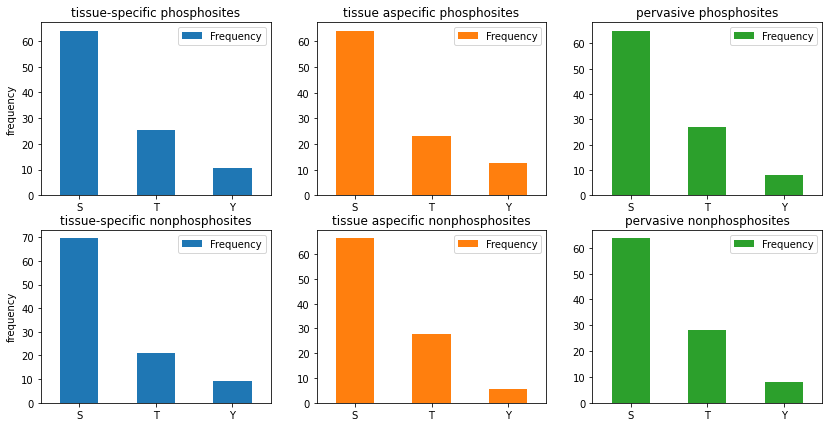

In [185]:
fig,ax = plt.subplots(2,3)

tspec_sites_Psites_plotSTY.plot(ax = ax[0,0], kind = 'bar', x="residue", xlabel="", ylabel = 'frequency', figsize=(14, 7), rot=0).set_title("tissue-specific phosphosites")
taspec_sites_Psites_plotSTY.plot(ax = ax[0,1], kind = 'bar', x="residue", xlabel="", figsize=(14, 7), rot=0, color=["tab:orange"]).set_title("tissue aspecific phosphosites")
gen_sites_Psites_plotSTY.plot(ax = ax[0,2], kind = 'bar', x="residue", xlabel="", figsize=(14, 7), rot=0, color=["tab:green"]).set_title("pervasive phosphosites")
tspec_sites_nonPsites_plotSTY.plot(ax = ax[1,0], kind = 'bar', x="residue", xlabel="", ylabel = 'frequency', figsize=(14, 7), rot=0).set_title("tissue-specific nonphosphosites")
taspec_sites_nonPsites_plotSTY.plot(ax = ax[1,1], kind = 'bar', x="residue", xlabel="", figsize=(14, 7), rot=0, color=["tab:orange"]).set_title("tissue aspecific nonphosphosites")
gen_sites_nonPsites_plotSTY.plot(ax = ax[1,2], kind = 'bar', x="residue", xlabel="", figsize=(14, 7), rot=0, color=["tab:green"]).set_title("pervasive nonphosphosites")


#plt.savefig("Comparison of frequency STY.png", format="png", bbox_inches="tight")
plt.show()

We'll now make a similar analysis of the effect of the mutation instead of the residue involved.

In [186]:
print("tspec_sites mutated Psite region")
print(tspec_sites_Psites.shape[0])
print(tspec_sites_Psites["Variant category"].value_counts())
print("taspec_sites mutated Psite region")
print(taspec_sites_Psites.shape[0])
print(taspec_sites_Psites["Variant category"].value_counts())
print("pervasively_sites mutated Psite region")
print(gen_sites_Psites.shape[0])
print(gen_sites_Psites["Variant category"].value_counts())

print("tspec_sites mutated nonPsite region")
print(tspec_sites_nonPsites.shape[0])
print(tspec_sites_nonPsites["Variant category"].value_counts())
print("taspec_sites mutated nonPsite region")
print(taspec_sites_nonPsites.shape[0])
print(taspec_sites_nonPsites["Variant category"].value_counts())
print("pervasively_sites mutated nonPsite region")
print(gen_sites_nonPsites.shape[0])
print(gen_sites_nonPsites["Variant category"].value_counts())

tspec_sites mutated Psite region
1261
LB/B    592
LP/P    482
US      187
Name: Variant category, dtype: int64
taspec_sites mutated Psite region
609
LB/B    289
LP/P    244
US       76
Name: Variant category, dtype: int64
pervasively_sites mutated Psite region
459
LB/B    274
LP/P    157
US       28
Name: Variant category, dtype: int64
tspec_sites mutated nonPsite region
2543
LB/B    1395
LP/P     939
US       209
Name: Variant category, dtype: int64
taspec_sites mutated nonPsite region
1063
LP/P    496
LB/B    466
US      101
Name: Variant category, dtype: int64
pervasively_sites mutated nonPsite region
614
LB/B    307
LP/P    242
US       65
Name: Variant category, dtype: int64


In [187]:
print("tspec_sites mutated Psite region")
print(tspec_sites_Psites["Variant category"].value_counts()[0]*100/tspec_sites_Psites.shape[0])
print(tspec_sites_Psites["Variant category"].value_counts()[1]*100/tspec_sites_Psites.shape[0])
print(tspec_sites_Psites["Variant category"].value_counts()[2]*100/tspec_sites_Psites.shape[0])
print("taspec_sites mutated Psite region")
print(taspec_sites_Psites["Variant category"].value_counts()[0]*100/taspec_sites_Psites.shape[0])
print(taspec_sites_Psites["Variant category"].value_counts()[1]*100/taspec_sites_Psites.shape[0])
print(taspec_sites_Psites["Variant category"].value_counts()[2]*100/taspec_sites_Psites.shape[0])
print("pervasively_sites mutated Psite region")
print(gen_sites_Psites["Variant category"].value_counts()[0]*100/gen_sites_Psites.shape[0])
print(gen_sites_Psites["Variant category"].value_counts()[1]*100/gen_sites_Psites.shape[0])
print(gen_sites_Psites["Variant category"].value_counts()[2]*100/gen_sites_Psites.shape[0])

print("tspec_sites mutated nonPsite region")
print(tspec_sites_nonPsites["Variant category"].value_counts()[0]*100/tspec_sites_nonPsites.shape[0])
print(tspec_sites_nonPsites["Variant category"].value_counts()[1]*100/tspec_sites_nonPsites.shape[0])
print(tspec_sites_nonPsites["Variant category"].value_counts()[2]*100/tspec_sites_nonPsites.shape[0])
print("taspec_sites mutated nonPsite region")
print(taspec_sites_nonPsites["Variant category"].value_counts()[1]*100/taspec_sites_nonPsites.shape[0])
print(taspec_sites_nonPsites["Variant category"].value_counts()[0]*100/taspec_sites_nonPsites.shape[0])
print(taspec_sites_nonPsites["Variant category"].value_counts()[2]*100/taspec_sites_nonPsites.shape[0])
print("pervasively_sites mutated nonPsite region")
print(gen_sites_nonPsites["Variant category"].value_counts()[0]*100/gen_sites_nonPsites.shape[0])
print(gen_sites_nonPsites["Variant category"].value_counts()[1]*100/gen_sites_nonPsites.shape[0])
print(gen_sites_nonPsites["Variant category"].value_counts()[2]*100/gen_sites_nonPsites.shape[0])

tspec_sites mutated Psite region
46.94686756542426
38.22363203806503
14.829500396510706
taspec_sites mutated Psite region
47.454844006568145
40.06568144499179
12.479474548440066
pervasively_sites mutated Psite region
59.694989106753816
34.20479302832244
6.1002178649237475
tspec_sites mutated nonPsite region
54.85646873771137
36.92489186000787
8.21863940228077
taspec_sites mutated nonPsite region
43.8381937911571
46.66039510818438
9.501411100658514
pervasively_sites mutated nonPsite region
50.0
39.413680781758956
10.586319218241043


In [188]:
tspec_sites_Psites_plotcons = pd.DataFrame({"Category": ["Benign","Pathogenic","US"]})
tspec_sites_Psites_plotcons["Frequency"] =  [tspec_sites_Psites["Variant category"].value_counts()[0]*100/tspec_sites_Psites.shape[0],
                                          tspec_sites_Psites["Variant category"].value_counts()[1]*100/tspec_sites_Psites.shape[0],
                                          tspec_sites_Psites["Variant category"].value_counts()[2]*100/tspec_sites_Psites.shape[0]]
taspec_sites_Psites_plotcons = pd.DataFrame({"Category": ["Benign","Pathogenic","US"]})
taspec_sites_Psites_plotcons["Frequency"] = [taspec_sites_Psites["Variant category"].value_counts()[0]*100/taspec_sites_Psites.shape[0],
                                          taspec_sites_Psites["Variant category"].value_counts()[1]*100/taspec_sites_Psites.shape[0],
                                          taspec_sites_Psites["Variant category"].value_counts()[2]*100/taspec_sites_Psites.shape[0]]
gen_sites_Psites_plotcons = pd.DataFrame({"Category": ["Benign","Pathogenic","US"]})
gen_sites_Psites_plotcons["Frequency"] = [gen_sites_Psites["Variant category"].value_counts()[0]*100/gen_sites_Psites.shape[0],
                                          gen_sites_Psites["Variant category"].value_counts()[1]*100/gen_sites_Psites.shape[0],
                                          gen_sites_Psites["Variant category"].value_counts()[2]*100/gen_sites_Psites.shape[0]]

tspec_sites_nonPsites_plotcons = pd.DataFrame({"Category": ["Benign","Pathogenic","US"]})
tspec_sites_nonPsites_plotcons["Frequency"] =  [tspec_sites_nonPsites["Variant category"].value_counts()[0]*100/tspec_sites_nonPsites.shape[0],
                                          tspec_sites_nonPsites["Variant category"].value_counts()[1]*100/tspec_sites_nonPsites.shape[0],
                                          tspec_sites_nonPsites["Variant category"].value_counts()[2]*100/tspec_sites_nonPsites.shape[0]]
taspec_sites_nonPsites_plotcons = pd.DataFrame({"Category": ["Benign","Pathogenic","US"]})
taspec_sites_nonPsites_plotcons["Frequency"] = [taspec_sites_nonPsites["Variant category"].value_counts()[1]*100/taspec_sites_nonPsites.shape[0],
                                          taspec_sites_nonPsites["Variant category"].value_counts()[0]*100/taspec_sites_nonPsites.shape[0],
                                          taspec_sites_nonPsites["Variant category"].value_counts()[2]*100/taspec_sites_nonPsites.shape[0]]
gen_sites_nonPsites_plotcons = pd.DataFrame({"Category": ["Benign","Pathogenic","US"]})
gen_sites_nonPsites_plotcons["Frequency"] = [gen_sites_nonPsites["Variant category"].value_counts()[0]*100/gen_sites_nonPsites.shape[0],
                                          gen_sites_nonPsites["Variant category"].value_counts()[1]*100/gen_sites_nonPsites.shape[0],
                                          gen_sites_nonPsites["Variant category"].value_counts()[2]*100/gen_sites_nonPsites.shape[0]]

We can clearly see that, while for tissue-specific P-sites the P-sites are more associated with pathogenic mutations than their non-phosphorylated counterpart, the opposite is true for the tissue aspecific P-sites and pervasive P-sites. While tissue-specific P-sites are relatively highly associated with mutations of unknown significance, compared to their non-phosphorylated counterparts, the opposite is true for pervasive P-sites, while for tissue aspecific P-sites, the difference is small.

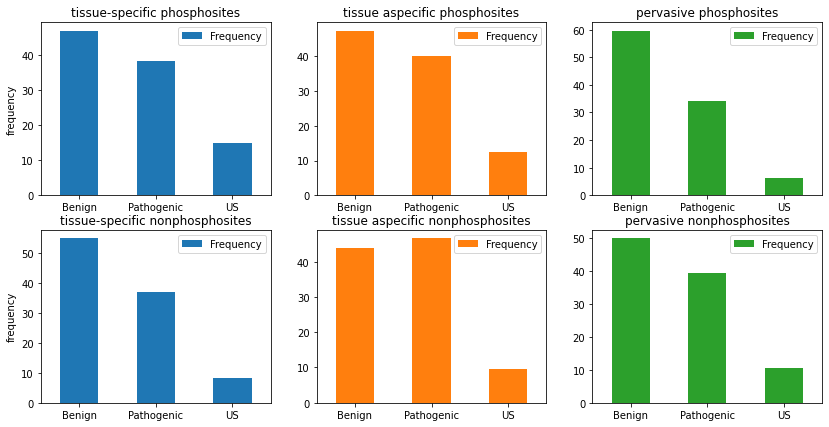

In [189]:
fig,ax = plt.subplots(2,3)

tspec_sites_Psites_plotcons.plot(ax = ax[0,0], kind = 'bar', x="Category", xlabel="", ylabel = 'frequency', figsize=(14, 7), rot=0).set_title("tissue-specific phosphosites")
taspec_sites_Psites_plotcons.plot(ax = ax[0,1], kind = 'bar', x="Category", xlabel="", figsize=(14, 7), rot=0, color=["tab:orange"]).set_title("tissue aspecific phosphosites")
gen_sites_Psites_plotcons.plot(ax = ax[0,2], kind = 'bar', x="Category", xlabel="", figsize=(14, 7), rot=0, color=["tab:green"]).set_title("pervasive phosphosites")
tspec_sites_nonPsites_plotcons.plot(ax = ax[1,0], kind = 'bar', x="Category", xlabel="", ylabel = 'frequency', figsize=(14, 7), rot=0).set_title("tissue-specific nonphosphosites")
taspec_sites_nonPsites_plotcons.plot(ax = ax[1,1], kind = 'bar', x="Category", xlabel="", figsize=(14, 7), rot=0, color=["tab:orange"]).set_title("tissue aspecific nonphosphosites")
gen_sites_nonPsites_plotcons.plot(ax = ax[1,2], kind = 'bar', x="Category", xlabel="", figsize=(14, 7), rot=0, color=["tab:green"]).set_title("pervasive nonphosphosites")


#plt.savefig("Comparison of frequency of annot.png", format="png", bbox_inches="tight")
plt.show()

In [190]:
print("tspec_sites mutated Psite region, per residue")
print(tspec_sites_Psites.shape[0])
print(tspec_sites_Psites[tspec_sites_Psites["modres_S"]==1]["Annotation"].value_counts())
print(tspec_sites_Psites[tspec_sites_Psites["modres_T"]==1]["Annotation"].value_counts())
print(tspec_sites_Psites[tspec_sites_Psites["modres_Y"]==1]["Annotation"].value_counts())
print("taspec_sites mutated Psite region")
print(taspec_sites_Psites.shape[0])
print(taspec_sites_Psites[taspec_sites_Psites["modres_S"]==1]["Annotation"].value_counts())
print(taspec_sites_Psites[taspec_sites_Psites["modres_T"]==1]["Annotation"].value_counts())
print(taspec_sites_Psites[taspec_sites_Psites["modres_Y"]==1]["Annotation"].value_counts())
print("pervasively_sites mutated Psite region")
print(gen_sites_Psites.shape[0])
print(gen_sites_Psites[gen_sites_Psites["modres_S"]==1]["Annotation"].value_counts())
print(gen_sites_Psites[gen_sites_Psites["modres_T"]==1]["Annotation"].value_counts())
print(gen_sites_Psites[gen_sites_Psites["modres_Y"]==1]["Annotation"].value_counts())

print("tspec_sites mutated nonPsite region")
print(tspec_sites_nonPsites.shape[0])
print(tspec_sites_nonPsites[tspec_sites_nonPsites["res"]=="S"]["Annotation"].value_counts())
print(tspec_sites_nonPsites[tspec_sites_nonPsites["res"]=="T"]["Annotation"].value_counts())
print(tspec_sites_nonPsites[tspec_sites_nonPsites["res"]=="Y"]["Annotation"].value_counts())
print("taspec_sites mutated nonPsite region")
print(taspec_sites_nonPsites.shape[0])
print(taspec_sites_nonPsites[taspec_sites_nonPsites["res"]=="S"]["Annotation"].value_counts())
print(taspec_sites_nonPsites[taspec_sites_nonPsites["res"]=="T"]["Annotation"].value_counts())
print(taspec_sites_nonPsites[taspec_sites_nonPsites["res"]=="Y"]["Annotation"].value_counts())
print("pervasively_sites mutated nonPsite region")
print(gen_sites_nonPsites.shape[0])
print(gen_sites_nonPsites[gen_sites_nonPsites["res"]=="S"]["Annotation"].value_counts())
print(gen_sites_nonPsites[gen_sites_nonPsites["res"]=="T"]["Annotation"].value_counts())
print(gen_sites_nonPsites[gen_sites_nonPsites["res"]=="Y"]["Annotation"].value_counts())

tspec_sites mutated Psite region, per residue
1261
(likely) Benign         363
(likely) Pathogenic     281
Unknown significance    127
Name: Annotation, dtype: int64
(likely) Benign         153
(likely) Pathogenic     138
Unknown significance     55
Name: Annotation, dtype: int64
(likely) Benign         76
(likely) Pathogenic     63
Unknown significance     5
Name: Annotation, dtype: int64
taspec_sites mutated Psite region
609
(likely) Benign         173
(likely) Pathogenic      88
Unknown significance     61
Name: Annotation, dtype: int64
(likely) Pathogenic     102
(likely) Benign          75
Unknown significance     11
Name: Annotation, dtype: int64
(likely) Pathogenic     54
(likely) Benign         41
Unknown significance     4
Name: Annotation, dtype: int64
pervasively_sites mutated Psite region
459
(likely) Benign         165
(likely) Pathogenic     110
Unknown significance     19
Name: Annotation, dtype: int64
(likely) Benign         87
(likely) Pathogenic     35
Unknown signifi

In [191]:
print("tspec_sites mutated Psite region, per residue")
print(tspec_sites_Psites.shape[0])
print(tspec_sites_Psites[tspec_sites_Psites["modres_S"]==1]["Annotation"].value_counts()[0]*100/tspec_sites_Psites[tspec_sites_Psites["modres_S"]==1].shape[0])
print(tspec_sites_Psites[tspec_sites_Psites["modres_S"]==1]["Annotation"].value_counts()[1]*100/tspec_sites_Psites[tspec_sites_Psites["modres_S"]==1].shape[0])
print(tspec_sites_Psites[tspec_sites_Psites["modres_S"]==1]["Annotation"].value_counts()[2]*100/tspec_sites_Psites[tspec_sites_Psites["modres_S"]==1].shape[0])

print(tspec_sites_Psites[tspec_sites_Psites["modres_T"]==1]["Annotation"].value_counts()[0]*100/tspec_sites_Psites[tspec_sites_Psites["modres_T"]==1].shape[0])
print(tspec_sites_Psites[tspec_sites_Psites["modres_T"]==1]["Annotation"].value_counts()[1]*100/tspec_sites_Psites[tspec_sites_Psites["modres_T"]==1].shape[0])
print(tspec_sites_Psites[tspec_sites_Psites["modres_T"]==1]["Annotation"].value_counts()[2]*100/tspec_sites_Psites[tspec_sites_Psites["modres_T"]==1].shape[0])

print(tspec_sites_Psites[tspec_sites_Psites["modres_Y"]==1]["Annotation"].value_counts()[0]*100/tspec_sites_Psites[tspec_sites_Psites["modres_Y"]==1].shape[0])
print(tspec_sites_Psites[tspec_sites_Psites["modres_Y"]==1]["Annotation"].value_counts()[1]*100/tspec_sites_Psites[tspec_sites_Psites["modres_Y"]==1].shape[0])
print(tspec_sites_Psites[tspec_sites_Psites["modres_Y"]==1]["Annotation"].value_counts()[2]*100/tspec_sites_Psites[tspec_sites_Psites["modres_Y"]==1].shape[0])


print("taspec_sites mutated Psite region")

print(taspec_sites_Psites[taspec_sites_Psites["modres_S"]==1]["Annotation"].value_counts()[0]*100/taspec_sites_Psites[taspec_sites_Psites["modres_S"]==1].shape[0])
print(taspec_sites_Psites[taspec_sites_Psites["modres_S"]==1]["Annotation"].value_counts()[1]*100/taspec_sites_Psites[taspec_sites_Psites["modres_S"]==1].shape[0])
print(taspec_sites_Psites[taspec_sites_Psites["modres_S"]==1]["Annotation"].value_counts()[2]*100/taspec_sites_Psites[taspec_sites_Psites["modres_S"]==1].shape[0])

print(taspec_sites_Psites[taspec_sites_Psites["modres_T"]==1]["Annotation"].value_counts()[1]*100/taspec_sites_Psites[taspec_sites_Psites["modres_T"]==1].shape[0])
print(taspec_sites_Psites[taspec_sites_Psites["modres_T"]==1]["Annotation"].value_counts()[0]*100/taspec_sites_Psites[taspec_sites_Psites["modres_T"]==1].shape[0])
print(taspec_sites_Psites[taspec_sites_Psites["modres_T"]==1]["Annotation"].value_counts()[2]*100/taspec_sites_Psites[taspec_sites_Psites["modres_T"]==1].shape[0])

print(taspec_sites_Psites[taspec_sites_Psites["modres_Y"]==1]["Annotation"].value_counts()[1]*100/taspec_sites_Psites[taspec_sites_Psites["modres_Y"]==1].shape[0])
print(taspec_sites_Psites[taspec_sites_Psites["modres_Y"]==1]["Annotation"].value_counts()[0]*100/taspec_sites_Psites[taspec_sites_Psites["modres_Y"]==1].shape[0])
print(taspec_sites_Psites[taspec_sites_Psites["modres_Y"]==1]["Annotation"].value_counts()[2]*100/taspec_sites_Psites[taspec_sites_Psites["modres_Y"]==1].shape[0])

print("pervasively_sites mutated Psite region")
print(gen_sites_Psites.shape[0])
print(gen_sites_Psites[gen_sites_Psites["modres_S"]==1]["Annotation"].value_counts()[0]*100/gen_sites_Psites[gen_sites_Psites["modres_S"]==1].shape[0])
print(gen_sites_Psites[gen_sites_Psites["modres_S"]==1]["Annotation"].value_counts()[1]*100/gen_sites_Psites[gen_sites_Psites["modres_S"]==1].shape[0])
print(gen_sites_Psites[gen_sites_Psites["modres_S"]==1]["Annotation"].value_counts()[2]*100/gen_sites_Psites[gen_sites_Psites["modres_S"]==1].shape[0])

print(gen_sites_Psites[gen_sites_Psites["modres_T"]==1]["Annotation"].value_counts()[0]*100/gen_sites_Psites[gen_sites_Psites["modres_T"]==1].shape[0])
print(gen_sites_Psites[gen_sites_Psites["modres_T"]==1]["Annotation"].value_counts()[1]*100/gen_sites_Psites[gen_sites_Psites["modres_T"]==1].shape[0])
print(gen_sites_Psites[gen_sites_Psites["modres_T"]==1]["Annotation"].value_counts()[2]*100/gen_sites_Psites[gen_sites_Psites["modres_T"]==1].shape[0])

print(gen_sites_Psites[gen_sites_Psites["modres_Y"]==1]["Annotation"].value_counts()[0]*100/gen_sites_Psites[gen_sites_Psites["modres_Y"]==1].shape[0])
print(gen_sites_Psites[gen_sites_Psites["modres_Y"]==1]["Annotation"].value_counts()[1]*100/gen_sites_Psites[gen_sites_Psites["modres_Y"]==1].shape[0])
print(gen_sites_Psites[gen_sites_Psites["modres_Y"]==1]["Annotation"].value_counts()[2]*100/gen_sites_Psites[gen_sites_Psites["modres_Y"]==1].shape[0])



print("tspec_sites mutated nonPsite region, per residue")
print(tspec_sites_nonPsites.shape[0])
print(tspec_sites_nonPsites[tspec_sites_nonPsites["res"]=="S"]["Annotation"].value_counts()[0]*100/tspec_sites_nonPsites[tspec_sites_nonPsites["res"]=="S"].shape[0])
print(tspec_sites_nonPsites[tspec_sites_nonPsites["res"]=="S"]["Annotation"].value_counts()[1]*100/tspec_sites_nonPsites[tspec_sites_nonPsites["res"]=="S"].shape[0])
print(tspec_sites_nonPsites[tspec_sites_nonPsites["res"]=="S"]["Annotation"].value_counts()[2]*100/tspec_sites_nonPsites[tspec_sites_nonPsites["res"]=="S"].shape[0])

print(tspec_sites_nonPsites[tspec_sites_nonPsites["res"]=="T"]["Annotation"].value_counts()[0]*100/tspec_sites_nonPsites[tspec_sites_nonPsites["res"]=="T"].shape[0])
print(tspec_sites_nonPsites[tspec_sites_nonPsites["res"]=="T"]["Annotation"].value_counts()[1]*100/tspec_sites_nonPsites[tspec_sites_nonPsites["res"]=="T"].shape[0])
print(tspec_sites_nonPsites[tspec_sites_nonPsites["res"]=="T"]["Annotation"].value_counts()[2]*100/tspec_sites_nonPsites[tspec_sites_nonPsites["res"]=="T"].shape[0])

print(tspec_sites_nonPsites[tspec_sites_nonPsites["res"]=="Y"]["Annotation"].value_counts()[1]*100/tspec_sites_nonPsites[tspec_sites_nonPsites["res"]=="Y"].shape[0])
print(tspec_sites_nonPsites[tspec_sites_nonPsites["res"]=="Y"]["Annotation"].value_counts()[0]*100/tspec_sites_nonPsites[tspec_sites_nonPsites["res"]=="Y"].shape[0])
print(tspec_sites_nonPsites[tspec_sites_nonPsites["res"]=="Y"]["Annotation"].value_counts()[2]*100/tspec_sites_nonPsites[tspec_sites_nonPsites["res"]=="Y"].shape[0])


print("taspec_sites mutated nonPsite region")

print(taspec_sites_nonPsites[taspec_sites_nonPsites["res"]=="S"]["Annotation"].value_counts()[0]*100/taspec_sites_nonPsites[taspec_sites_nonPsites["res"]=="S"].shape[0])
print(taspec_sites_nonPsites[taspec_sites_nonPsites["res"]=="S"]["Annotation"].value_counts()[1]*100/taspec_sites_nonPsites[taspec_sites_nonPsites["res"]=="S"].shape[0])
print(taspec_sites_nonPsites[taspec_sites_nonPsites["res"]=="S"]["Annotation"].value_counts()[2]*100/taspec_sites_nonPsites[taspec_sites_nonPsites["res"]=="S"].shape[0])

print(taspec_sites_nonPsites[taspec_sites_nonPsites["res"]=="T"]["Annotation"].value_counts()[1]*100/taspec_sites_nonPsites[taspec_sites_nonPsites["res"]=="T"].shape[0])
print(taspec_sites_nonPsites[taspec_sites_nonPsites["res"]=="T"]["Annotation"].value_counts()[0]*100/taspec_sites_nonPsites[taspec_sites_nonPsites["res"]=="T"].shape[0])
print(taspec_sites_nonPsites[taspec_sites_nonPsites["res"]=="T"]["Annotation"].value_counts()[2]*100/taspec_sites_nonPsites[taspec_sites_nonPsites["res"]=="T"].shape[0])

print(taspec_sites_nonPsites[taspec_sites_nonPsites["res"]=="Y"]["Annotation"].value_counts()[1]*100/taspec_sites_nonPsites[taspec_sites_nonPsites["res"]=="Y"].shape[0])
print(taspec_sites_nonPsites[taspec_sites_nonPsites["res"]=="Y"]["Annotation"].value_counts()[0]*100/taspec_sites_nonPsites[taspec_sites_nonPsites["res"]=="Y"].shape[0])
print(taspec_sites_nonPsites[taspec_sites_nonPsites["res"]=="Y"]["Annotation"].value_counts()[2]*100/taspec_sites_nonPsites[taspec_sites_nonPsites["res"]=="Y"].shape[0])

print("pervasively_sites mutated nonPsite region")
print(gen_sites_nonPsites.shape[0])
print(gen_sites_nonPsites[gen_sites_nonPsites["res"]=="S"]["Annotation"].value_counts()[0]*100/gen_sites_nonPsites[gen_sites_nonPsites["res"]=="S"].shape[0])
print(gen_sites_nonPsites[gen_sites_nonPsites["res"]=="S"]["Annotation"].value_counts()[1]*100/gen_sites_nonPsites[gen_sites_nonPsites["res"]=="S"].shape[0])
print(gen_sites_nonPsites[gen_sites_nonPsites["res"]=="S"]["Annotation"].value_counts()[2]*100/gen_sites_nonPsites[gen_sites_nonPsites["res"]=="S"].shape[0])

print(gen_sites_nonPsites[gen_sites_nonPsites["res"]=="T"]["Annotation"].value_counts()[1]*100/gen_sites_nonPsites[gen_sites_nonPsites["res"]=="T"].shape[0])
print(gen_sites_nonPsites[gen_sites_nonPsites["res"]=="T"]["Annotation"].value_counts()[0]*100/gen_sites_nonPsites[gen_sites_nonPsites["res"]=="T"].shape[0])
print(gen_sites_nonPsites[gen_sites_nonPsites["res"]=="T"]["Annotation"].value_counts()[2]*100/gen_sites_nonPsites[gen_sites_nonPsites["res"]=="T"].shape[0])

print(gen_sites_nonPsites[gen_sites_nonPsites["res"]=="Y"]["Annotation"].value_counts()[1]*100/gen_sites_nonPsites[gen_sites_nonPsites["res"]=="Y"].shape[0])
print(gen_sites_nonPsites[gen_sites_nonPsites["res"]=="Y"]["Annotation"].value_counts()[0]*100/gen_sites_nonPsites[gen_sites_nonPsites["res"]=="Y"].shape[0])
print(gen_sites_nonPsites[gen_sites_nonPsites["res"]=="Y"]["Annotation"].value_counts()[2]*100/gen_sites_nonPsites[gen_sites_nonPsites["res"]=="Y"].shape[0])

tspec_sites mutated Psite region, per residue
1261
47.08171206225681
36.4461738002594
16.472114137483786
44.21965317919075
39.884393063583815
15.895953757225433
52.77777777777778
43.75
3.4722222222222223
taspec_sites mutated Psite region
53.72670807453416
27.32919254658385
18.944099378881987
39.8936170212766
54.255319148936174
5.851063829787234
41.41414141414141
54.54545454545455
4.040404040404041
pervasively_sites mutated Psite region
459
56.12244897959184
37.414965986394556
6.462585034013605
67.44186046511628
27.131782945736433
5.426356589147287
61.111111111111114
33.333333333333336
5.555555555555555
tspec_sites mutated nonPsite region, per residue
2543
60.51243406179352
31.574981160512433
7.912584777694047
51.750972762645915
40.46692607003891
7.782101167315175
43.37078651685393
46.741573033707866
9.887640449438202
taspec_sites mutated nonPsite region
49.42965779467681
40.49429657794677
10.076045627376425
42.1875
47.65625
10.15625
28.758169934640524
65.359477124183
5.882352941176471


We now combine both type of analysis, residues and effect of mutation.

In [192]:
list_consequences = ["B", "P", "US"]

tspec_Psites_both = pd.DataFrame({"consequence": list_consequences})
tspec_Psites_both["all"] = [tspec_sites_Psites["Variant category"].value_counts()[0]*100/tspec_sites_Psites.shape[0],
                                          tspec_sites_Psites["Variant category"].value_counts()[1]*100/tspec_sites_Psites.shape[0],
                                          tspec_sites_Psites["Variant category"].value_counts()[2]*100/tspec_sites_Psites.shape[0]]
tspec_Psites_both["S"] = [tspec_sites_Psites[tspec_sites_Psites["modres_S"]==1]["Annotation"].value_counts()[0]*100/tspec_sites_Psites[tspec_sites_Psites["modres_S"]==1].shape[0],
                          tspec_sites_Psites[tspec_sites_Psites["modres_S"]==1]["Annotation"].value_counts()[1]*100/tspec_sites_Psites[tspec_sites_Psites["modres_S"]==1].shape[0],
                          tspec_sites_Psites[tspec_sites_Psites["modres_S"]==1]["Annotation"].value_counts()[2]*100/tspec_sites_Psites[tspec_sites_Psites["modres_S"]==1].shape[0]]

tspec_Psites_both["T"] = [tspec_sites_Psites[tspec_sites_Psites["modres_T"]==1]["Annotation"].value_counts()[0]*100/tspec_sites_Psites[tspec_sites_Psites["modres_T"]==1].shape[0],
                          tspec_sites_Psites[tspec_sites_Psites["modres_T"]==1]["Annotation"].value_counts()[1]*100/tspec_sites_Psites[tspec_sites_Psites["modres_T"]==1].shape[0],
                          tspec_sites_Psites[tspec_sites_Psites["modres_T"]==1]["Annotation"].value_counts()[2]*100/tspec_sites_Psites[tspec_sites_Psites["modres_T"]==1].shape[0]]

tspec_Psites_both["Y"] = [tspec_sites_Psites[tspec_sites_Psites["modres_Y"]==1]["Annotation"].value_counts()[0]*100/tspec_sites_Psites[tspec_sites_Psites["modres_Y"]==1].shape[0],
                          tspec_sites_Psites[tspec_sites_Psites["modres_Y"]==1]["Annotation"].value_counts()[1]*100/tspec_sites_Psites[tspec_sites_Psites["modres_Y"]==1].shape[0],
                          tspec_sites_Psites[tspec_sites_Psites["modres_Y"]==1]["Annotation"].value_counts()[2]*100/tspec_sites_Psites[tspec_sites_Psites["modres_Y"]==1].shape[0]]

taspec_Psites_both = pd.DataFrame({"consequence": list_consequences})
taspec_Psites_both["all"] = [taspec_sites_Psites["Variant category"].value_counts()[0]*100/taspec_sites_Psites.shape[0],
                                          taspec_sites_Psites["Variant category"].value_counts()[1]*100/taspec_sites_Psites.shape[0],
                                          taspec_sites_Psites["Variant category"].value_counts()[2]*100/taspec_sites_Psites.shape[0]]
taspec_Psites_both["S"] = [taspec_sites_Psites[taspec_sites_Psites["modres_S"]==1]["Annotation"].value_counts()[0]*100/taspec_sites_Psites[taspec_sites_Psites["modres_S"]==1].shape[0],
                      taspec_sites_Psites[taspec_sites_Psites["modres_S"]==1]["Annotation"].value_counts()[1]*100/taspec_sites_Psites[taspec_sites_Psites["modres_S"]==1].shape[0],
                      taspec_sites_Psites[taspec_sites_Psites["modres_S"]==1]["Annotation"].value_counts()[2]*100/taspec_sites_Psites[taspec_sites_Psites["modres_S"]==1].shape[0]]

taspec_Psites_both["T"] = [taspec_sites_Psites[taspec_sites_Psites["modres_T"]==1]["Annotation"].value_counts()[1]*100/taspec_sites_Psites[taspec_sites_Psites["modres_T"]==1].shape[0],
                      taspec_sites_Psites[taspec_sites_Psites["modres_T"]==1]["Annotation"].value_counts()[0]*100/taspec_sites_Psites[taspec_sites_Psites["modres_T"]==1].shape[0],
                      taspec_sites_Psites[taspec_sites_Psites["modres_T"]==1]["Annotation"].value_counts()[2]*100/taspec_sites_Psites[taspec_sites_Psites["modres_T"]==1].shape[0]]

taspec_Psites_both["Y"] = [taspec_sites_Psites[taspec_sites_Psites["modres_Y"]==1]["Annotation"].value_counts()[1]*100/taspec_sites_Psites[taspec_sites_Psites["modres_Y"]==1].shape[0],
                      taspec_sites_Psites[taspec_sites_Psites["modres_Y"]==1]["Annotation"].value_counts()[0]*100/taspec_sites_Psites[taspec_sites_Psites["modres_Y"]==1].shape[0],
                      taspec_sites_Psites[taspec_sites_Psites["modres_Y"]==1]["Annotation"].value_counts()[2]*100/taspec_sites_Psites[taspec_sites_Psites["modres_Y"]==1].shape[0]]

pervasive_Psites_both = pd.DataFrame({"consequence": list_consequences})
pervasive_Psites_both["all"] = [gen_sites_Psites["Variant category"].value_counts()[0]*100/gen_sites_Psites.shape[0],
                                          gen_sites_Psites["Variant category"].value_counts()[1]*100/gen_sites_Psites.shape[0],
                                          gen_sites_Psites["Variant category"].value_counts()[2]*100/gen_sites_Psites.shape[0]]
pervasive_Psites_both["S"] = [gen_sites_Psites[gen_sites_Psites["modres_S"]==1]["Annotation"].value_counts()[0]*100/gen_sites_Psites[gen_sites_Psites["modres_S"]==1].shape[0],
                              gen_sites_Psites[gen_sites_Psites["modres_S"]==1]["Annotation"].value_counts()[1]*100/gen_sites_Psites[gen_sites_Psites["modres_S"]==1].shape[0],
                              gen_sites_Psites[gen_sites_Psites["modres_S"]==1]["Annotation"].value_counts()[2]*100/gen_sites_Psites[gen_sites_Psites["modres_S"]==1].shape[0]]

pervasive_Psites_both["T"] = [gen_sites_Psites[gen_sites_Psites["modres_T"]==1]["Annotation"].value_counts()[0]*100/gen_sites_Psites[gen_sites_Psites["modres_T"]==1].shape[0],
                              gen_sites_Psites[gen_sites_Psites["modres_T"]==1]["Annotation"].value_counts()[1]*100/gen_sites_Psites[gen_sites_Psites["modres_T"]==1].shape[0],
                              gen_sites_Psites[gen_sites_Psites["modres_T"]==1]["Annotation"].value_counts()[2]*100/gen_sites_Psites[gen_sites_Psites["modres_T"]==1].shape[0]]

pervasive_Psites_both["Y"] = [gen_sites_Psites[gen_sites_Psites["modres_Y"]==1]["Annotation"].value_counts()[0]*100/gen_sites_Psites[gen_sites_Psites["modres_Y"]==1].shape[0],
                              gen_sites_Psites[gen_sites_Psites["modres_Y"]==1]["Annotation"].value_counts()[1]*100/gen_sites_Psites[gen_sites_Psites["modres_Y"]==1].shape[0],
                              gen_sites_Psites[gen_sites_Psites["modres_Y"]==1]["Annotation"].value_counts()[2]*100/gen_sites_Psites[gen_sites_Psites["modres_Y"]==1].shape[0]]
pervasive_Psites_both

,consequence,all,S,T,Y
0,B,59.694989,56.122449,67.441860,61.111111
1,P,34.204793,37.414966,27.131783,33.333333
2,US,6.100218,6.462585,5.426357,5.555556


In [193]:
tspec_nonPsites_both = pd.DataFrame({"consequence": list_consequences})
tspec_nonPsites_both["all"] = [tspec_sites_nonPsites["Variant category"].value_counts()[0]*100/tspec_sites_nonPsites.shape[0],
                                          tspec_sites_nonPsites["Variant category"].value_counts()[1]*100/tspec_sites_nonPsites.shape[0],
                                          tspec_sites_nonPsites["Variant category"].value_counts()[2]*100/tspec_sites_nonPsites.shape[0]]
tspec_nonPsites_both["S"] = [tspec_sites_nonPsites[tspec_sites_nonPsites["res"]=="S"]["Annotation"].value_counts()[0]*100/tspec_sites_nonPsites[tspec_sites_nonPsites["res"]=="S"].shape[0],
                             tspec_sites_nonPsites[tspec_sites_nonPsites["res"]=="S"]["Annotation"].value_counts()[1]*100/tspec_sites_nonPsites[tspec_sites_nonPsites["res"]=="S"].shape[0],
                             tspec_sites_nonPsites[tspec_sites_nonPsites["res"]=="S"]["Annotation"].value_counts()[2]*100/tspec_sites_nonPsites[tspec_sites_nonPsites["res"]=="S"].shape[0]]

tspec_nonPsites_both["T"] = [tspec_sites_nonPsites[tspec_sites_nonPsites["res"]=="T"]["Annotation"].value_counts()[0]*100/tspec_sites_nonPsites[tspec_sites_nonPsites["res"]=="T"].shape[0],
                             tspec_sites_nonPsites[tspec_sites_nonPsites["res"]=="T"]["Annotation"].value_counts()[1]*100/tspec_sites_nonPsites[tspec_sites_nonPsites["res"]=="T"].shape[0],
                             tspec_sites_nonPsites[tspec_sites_nonPsites["res"]=="T"]["Annotation"].value_counts()[2]*100/tspec_sites_nonPsites[tspec_sites_nonPsites["res"]=="T"].shape[0]]

tspec_nonPsites_both["Y"] = [tspec_sites_nonPsites[tspec_sites_nonPsites["res"]=="Y"]["Annotation"].value_counts()[1]*100/tspec_sites_nonPsites[tspec_sites_nonPsites["res"]=="Y"].shape[0],
                             tspec_sites_nonPsites[tspec_sites_nonPsites["res"]=="Y"]["Annotation"].value_counts()[0]*100/tspec_sites_nonPsites[tspec_sites_nonPsites["res"]=="Y"].shape[0],
                             tspec_sites_nonPsites[tspec_sites_nonPsites["res"]=="Y"]["Annotation"].value_counts()[2]*100/tspec_sites_nonPsites[tspec_sites_nonPsites["res"]=="Y"].shape[0]]

taspec_nonPsites_both = pd.DataFrame({"consequence": list_consequences})
taspec_nonPsites_both["all"] = [taspec_sites_nonPsites["Variant category"].value_counts()[1]*100/taspec_sites_nonPsites.shape[0],
                                          taspec_sites_nonPsites["Variant category"].value_counts()[0]*100/taspec_sites_nonPsites.shape[0],
                                          taspec_sites_nonPsites["Variant category"].value_counts()[2]*100/taspec_sites_nonPsites.shape[0]]

taspec_nonPsites_both["S"] = [taspec_sites_nonPsites[taspec_sites_nonPsites["res"]=="S"]["Annotation"].value_counts()[0]*100/taspec_sites_nonPsites[taspec_sites_nonPsites["res"]=="S"].shape[0],
                              taspec_sites_nonPsites[taspec_sites_nonPsites["res"]=="S"]["Annotation"].value_counts()[1]*100/taspec_sites_nonPsites[taspec_sites_nonPsites["res"]=="S"].shape[0],
                              taspec_sites_nonPsites[taspec_sites_nonPsites["res"]=="S"]["Annotation"].value_counts()[2]*100/taspec_sites_nonPsites[taspec_sites_nonPsites["res"]=="S"].shape[0]]

taspec_nonPsites_both["T"] = [taspec_sites_nonPsites[taspec_sites_nonPsites["res"]=="T"]["Annotation"].value_counts()[1]*100/taspec_sites_nonPsites[taspec_sites_nonPsites["res"]=="T"].shape[0],
                              taspec_sites_nonPsites[taspec_sites_nonPsites["res"]=="T"]["Annotation"].value_counts()[0]*100/taspec_sites_nonPsites[taspec_sites_nonPsites["res"]=="T"].shape[0],
                              taspec_sites_nonPsites[taspec_sites_nonPsites["res"]=="T"]["Annotation"].value_counts()[2]*100/taspec_sites_nonPsites[taspec_sites_nonPsites["res"]=="T"].shape[0]]

taspec_nonPsites_both["Y"] = [taspec_sites_nonPsites[taspec_sites_nonPsites["res"]=="Y"]["Annotation"].value_counts()[1]*100/taspec_sites_nonPsites[taspec_sites_nonPsites["res"]=="Y"].shape[0],
                              taspec_sites_nonPsites[taspec_sites_nonPsites["res"]=="Y"]["Annotation"].value_counts()[0]*100/taspec_sites_nonPsites[taspec_sites_nonPsites["res"]=="Y"].shape[0],
                              taspec_sites_nonPsites[taspec_sites_nonPsites["res"]=="Y"]["Annotation"].value_counts()[2]*100/taspec_sites_nonPsites[taspec_sites_nonPsites["res"]=="Y"].shape[0]]

pervasive_nonPsites_both = pd.DataFrame({"consequence": list_consequences})
pervasive_nonPsites_both["all"] = [gen_sites_nonPsites["Variant category"].value_counts()[0]*100/gen_sites_nonPsites.shape[0],
                                          gen_sites_nonPsites["Variant category"].value_counts()[1]*100/gen_sites_nonPsites.shape[0],
                                          gen_sites_nonPsites["Variant category"].value_counts()[2]*100/gen_sites_nonPsites.shape[0]]

pervasive_nonPsites_both["S"] = [gen_sites_nonPsites[gen_sites_nonPsites["res"]=="S"]["Annotation"].value_counts()[0]*100/gen_sites_nonPsites[gen_sites_nonPsites["res"]=="S"].shape[0],
                                 gen_sites_nonPsites[gen_sites_nonPsites["res"]=="S"]["Annotation"].value_counts()[1]*100/gen_sites_nonPsites[gen_sites_nonPsites["res"]=="S"].shape[0],
                                 gen_sites_nonPsites[gen_sites_nonPsites["res"]=="S"]["Annotation"].value_counts()[2]*100/gen_sites_nonPsites[gen_sites_nonPsites["res"]=="S"].shape[0]]

pervasive_nonPsites_both["T"] = [gen_sites_nonPsites[gen_sites_nonPsites["res"]=="T"]["Annotation"].value_counts()[1]*100/gen_sites_nonPsites[gen_sites_nonPsites["res"]=="T"].shape[0],
                                 gen_sites_nonPsites[gen_sites_nonPsites["res"]=="T"]["Annotation"].value_counts()[0]*100/gen_sites_nonPsites[gen_sites_nonPsites["res"]=="T"].shape[0],
                                 gen_sites_nonPsites[gen_sites_nonPsites["res"]=="T"]["Annotation"].value_counts()[2]*100/gen_sites_nonPsites[gen_sites_nonPsites["res"]=="T"].shape[0]]

pervasive_nonPsites_both["Y"] = [gen_sites_nonPsites[gen_sites_nonPsites["res"]=="Y"]["Annotation"].value_counts()[1]*100/gen_sites_nonPsites[gen_sites_nonPsites["res"]=="Y"].shape[0],
                                 gen_sites_nonPsites[gen_sites_nonPsites["res"]=="Y"]["Annotation"].value_counts()[0]*100/gen_sites_nonPsites[gen_sites_nonPsites["res"]=="Y"].shape[0],
                                 gen_sites_nonPsites[gen_sites_nonPsites["res"]=="Y"]["Annotation"].value_counts()[2]*100/gen_sites_nonPsites[gen_sites_nonPsites["res"]=="Y"].shape[0]]

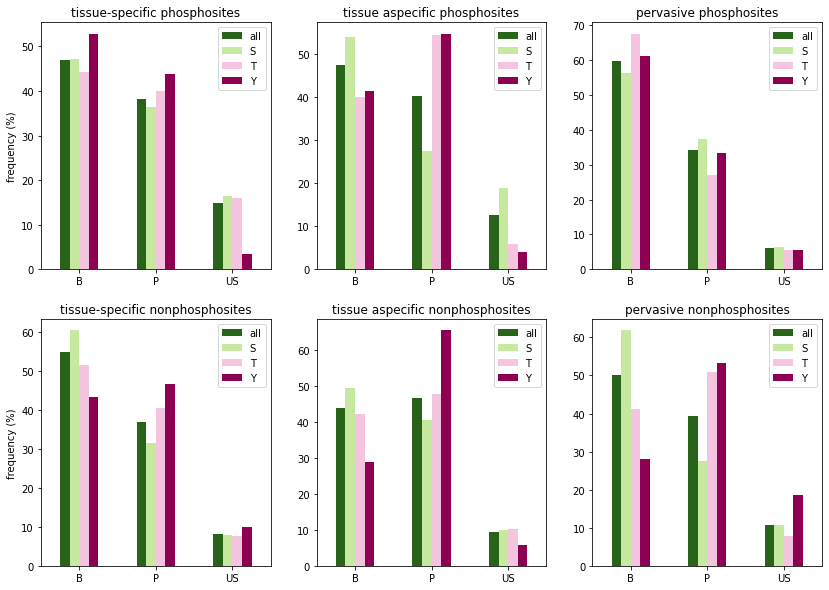

In [194]:
fig,ax = plt.subplots(2,3)

tspec_Psites_both.plot(ax = ax[0,0], kind = 'bar', x="consequence", xlabel="", ylabel = 'frequency (%)', figsize=(14, 10), rot=0, colormap="PiYG_r").set_title("tissue-specific phosphosites")
taspec_Psites_both.plot(ax = ax[0,1], kind = 'bar', x="consequence", xlabel="", figsize=(14, 10), rot=0, colormap="PiYG_r").set_title("tissue aspecific phosphosites")
pervasive_Psites_both.plot(ax = ax[0,2], kind = 'bar', x="consequence", xlabel="", figsize=(14, 10), rot=0, colormap="PiYG_r").set_title("pervasive phosphosites")
tspec_nonPsites_both.plot(ax = ax[1,0], kind = 'bar', x="consequence", xlabel="", ylabel = 'frequency (%)', figsize=(14, 10), rot=0, colormap="PiYG_r").set_title("tissue-specific nonphosphosites")
taspec_nonPsites_both.plot(ax = ax[1,1], kind = 'bar', x="consequence", xlabel="", figsize=(14, 10), rot=0, colormap="PiYG_r").set_title("tissue aspecific nonphosphosites")
pervasive_nonPsites_both.plot(ax = ax[1,2], kind = 'bar', x="consequence", xlabel="", figsize=(14, 10), rot=0, colormap="PiYG_r").set_title("pervasive nonphosphosites")


#plt.savefig("Humsavar_comparison STY-annot.png", format="png", bbox_inches="tight")
plt.show()

We now calculate the percentage of both non-phosphorylated and phosphorylated STY-sites of each of the three categories associated with at least one benign, pathogenic and unknown significance mutation, respectively. Previously, if a site was associated with more than one mutation, it was counted twice, even if the consequence was the same. Here, this is no longer the case. If a site is associated with a benign mutaiton and a pathogenic mutaiton, it is counted twice. This is done by, per category, selecting all records associated with a consequence and then grouping on the site level.

In [195]:
list_consequences = ["LB/B", "LP/P", "US"]

tspec_Psites_both = pd.DataFrame({"consequence": list_consequences})
list_all = []
list_S = []
list_T = []
list_Y = []
for con in list_consequences:
    count_all = tspec_sites_Psites.loc[tspec_sites_Psites["Variant category"]==con, :].groupby(["ACC_ID", "UP_POS"],
                                                                                               as_index=False).agg({
        "modres": "first"}).shape[0]*100/tspec_sites_Psites.groupby(["ACC_ID", "UP_POS"],as_index=False).agg({
        "modres": "first"}).shape[0]
    count_S = tspec_sites_Psites.loc[(tspec_sites_Psites["Variant category"]==con)&(
    tspec_sites_Psites["modres_S"]==1), :].groupby(["ACC_ID", "UP_POS"], as_index=False).agg({"modres": "first"}).shape[0]*100/(
    tspec_sites_Psites.loc[(tspec_sites_Psites["modres_S"]==1), :].groupby(["ACC_ID", "UP_POS"],
                                                                           as_index=False).agg({"modres": "first"}).shape[0])
    count_T = tspec_sites_Psites.loc[(tspec_sites_Psites["Variant category"]==con)&(
    tspec_sites_Psites["modres_T"]==1), :].groupby(["ACC_ID", "UP_POS"], as_index=False).agg({"modres": "first"}).shape[0]*100/(
    tspec_sites_Psites.loc[(tspec_sites_Psites["modres_T"]==1), :].groupby(["ACC_ID", "UP_POS"],
                                                                           as_index=False).agg({"modres": "first"}).shape[0])
    count_Y = tspec_sites_Psites.loc[(tspec_sites_Psites["Variant category"]==con)&(
    tspec_sites_Psites["modres_Y"]==1), :].groupby(["ACC_ID", "UP_POS"], as_index=False).agg({"modres": "first"}).shape[0]*100/(
    tspec_sites_Psites.loc[(tspec_sites_Psites["modres_Y"]==1), :].groupby(["ACC_ID", "UP_POS"],
                                                                           as_index=False).agg({"modres": "first"}).shape[0])
    list_all.append(count_all)
    list_S.append(count_S)
    list_T.append(count_T)
    list_Y.append(count_Y)
tspec_Psites_both["all"] = list_all
tspec_Psites_both["S"] = list_S
tspec_Psites_both["T"] = list_T
tspec_Psites_both["Y"] = list_Y


taspec_Psites_both = pd.DataFrame({"consequence": list_consequences})
list_all = []
list_S = []
list_T = []
list_Y = []
for con in list_consequences:
    count_all = taspec_sites_Psites.loc[taspec_sites_Psites["Variant category"]==con, :].groupby(["ACC_ID", "UP_POS"],
                                                                                               as_index=False).agg({
        "modres": "first"}).shape[0]*100/taspec_sites_Psites.groupby(["ACC_ID", "UP_POS"],as_index=False).agg({
        "modres": "first"}).shape[0]
    count_S = taspec_sites_Psites.loc[(taspec_sites_Psites["Variant category"]==con)&(
    taspec_sites_Psites["modres_S"]==1), :].groupby(["ACC_ID", "UP_POS"], as_index=False).agg({"modres": "first"}).shape[0]*100/(
    taspec_sites_Psites.loc[(taspec_sites_Psites["modres_S"]==1), :].groupby(["ACC_ID", "UP_POS"],
                                                                           as_index=False).agg({"modres": "first"}).shape[0])
    count_T = taspec_sites_Psites.loc[(taspec_sites_Psites["Variant category"]==con)&(
    taspec_sites_Psites["modres_T"]==1), :].groupby(["ACC_ID", "UP_POS"], as_index=False).agg({"modres": "first"}).shape[0]*100/(
    taspec_sites_Psites.loc[(taspec_sites_Psites["modres_T"]==1), :].groupby(["ACC_ID", "UP_POS"],
                                                                           as_index=False).agg({"modres": "first"}).shape[0])
    count_Y = taspec_sites_Psites.loc[(taspec_sites_Psites["Variant category"]==con)&(
    taspec_sites_Psites["modres_Y"]==1), :].groupby(["ACC_ID", "UP_POS"], as_index=False).agg({"modres": "first"}).shape[0]*100/(
    taspec_sites_Psites.loc[(taspec_sites_Psites["modres_Y"]==1), :].groupby(["ACC_ID", "UP_POS"],
                                                                           as_index=False).agg({"modres": "first"}).shape[0])
    list_all.append(count_all)
    list_S.append(count_S)
    list_T.append(count_T)
    list_Y.append(count_Y)
taspec_Psites_both["all"] = list_all
taspec_Psites_both["S"] = list_S
taspec_Psites_both["T"] = list_T
taspec_Psites_both["Y"] = list_Y


pervasive_Psites_both = pd.DataFrame({"consequence": list_consequences})
list_all = []
list_S = []
list_T = []
list_Y = []
for con in list_consequences:
    count_all = gen_sites_Psites.loc[gen_sites_Psites["Variant category"]==con, :].groupby(["ACC_ID", "UP_POS"],
                                                                                               as_index=False).agg({
        "modres": "first"}).shape[0]*100/gen_sites_Psites.groupby(["ACC_ID", "UP_POS"],as_index=False).agg({
        "modres": "first"}).shape[0]
    count_S = gen_sites_Psites.loc[(gen_sites_Psites["Variant category"]==con)&(
    gen_sites_Psites["modres_S"]==1), :].groupby(["ACC_ID", "UP_POS"], as_index=False).agg({"modres": "first"}).shape[0]*100/(
    gen_sites_Psites.loc[(gen_sites_Psites["modres_S"]==1), :].groupby(["ACC_ID", "UP_POS"],
                                                                           as_index=False).agg({"modres": "first"}).shape[0])
    count_T = gen_sites_Psites.loc[(gen_sites_Psites["Variant category"]==con)&(
    gen_sites_Psites["modres_T"]==1), :].groupby(["ACC_ID", "UP_POS"], as_index=False).agg({"modres": "first"}).shape[0]*100/(
    gen_sites_Psites.loc[(gen_sites_Psites["modres_T"]==1), :].groupby(["ACC_ID", "UP_POS"],
                                                                           as_index=False).agg({"modres": "first"}).shape[0])
    count_Y = gen_sites_Psites.loc[(gen_sites_Psites["Variant category"]==con)&(
    gen_sites_Psites["modres_Y"]==1), :].groupby(["ACC_ID", "UP_POS"], as_index=False).agg({"modres": "first"}).shape[0]*100/(
    gen_sites_Psites.loc[(gen_sites_Psites["modres_Y"]==1), :].groupby(["ACC_ID", "UP_POS"],
                                                                           as_index=False).agg({"modres": "first"}).shape[0])
    list_all.append(count_all)
    list_S.append(count_S)
    list_T.append(count_T)
    list_Y.append(count_Y)
pervasive_Psites_both["all"] = list_all
pervasive_Psites_both["S"] = list_S
pervasive_Psites_both["T"] = list_T
pervasive_Psites_both["Y"] = list_Y

In [196]:
list_consequences = ["LB/B", "LP/P", "US"]

tspec_nonPsites_both = pd.DataFrame({"consequence": list_consequences})
list_all = []
list_S = []
list_T = []
list_Y = []
for con in list_consequences:
    count_all = tspec_sites_nonPsites.loc[tspec_sites_nonPsites["Variant category"]==con, :].groupby(["ACC_ID", "UP_POS"],
                                                                                               as_index=False).agg({
        "modres": "first"}).shape[0]*100/tspec_sites_nonPsites.groupby(["ACC_ID", "UP_POS"],as_index=False).agg({
        "modres": "first"}).shape[0]
    count_S = tspec_sites_nonPsites.loc[(tspec_sites_nonPsites["Variant category"]==con)&(
    tspec_sites_nonPsites["res"]=="S"), :].groupby(["ACC_ID", "UP_POS"], as_index=False).agg({"modres": "first"}).shape[0]*100/(
    tspec_sites_nonPsites.loc[(tspec_sites_nonPsites["res"]=="S"), :].groupby(["ACC_ID", "UP_POS"],
                                                                           as_index=False).agg({"modres": "first"}).shape[0])
    count_T = tspec_sites_nonPsites.loc[(tspec_sites_nonPsites["Variant category"]==con)&(
    tspec_sites_nonPsites["res"]=="T"), :].groupby(["ACC_ID", "UP_POS"], as_index=False).agg({"modres": "first"}).shape[0]*100/(
    tspec_sites_nonPsites.loc[(tspec_sites_nonPsites["res"]=="T"), :].groupby(["ACC_ID", "UP_POS"],
                                                                           as_index=False).agg({"modres": "first"}).shape[0])
    count_Y = tspec_sites_nonPsites.loc[(tspec_sites_nonPsites["Variant category"]==con)&(
    tspec_sites_nonPsites["res"]=="Y"), :].groupby(["ACC_ID", "UP_POS"], as_index=False).agg({"modres": "first"}).shape[0]*100/(
    tspec_sites_nonPsites.loc[(tspec_sites_nonPsites["res"]=="Y"), :].groupby(["ACC_ID", "UP_POS"],
                                                                           as_index=False).agg({"modres": "first"}).shape[0])
    list_all.append(count_all)
    list_S.append(count_S)
    list_T.append(count_T)
    list_Y.append(count_Y)
tspec_nonPsites_both["all"] = list_all
tspec_nonPsites_both["S"] = list_S
tspec_nonPsites_both["T"] = list_T
tspec_nonPsites_both["Y"] = list_Y


taspec_nonPsites_both = pd.DataFrame({"consequence": list_consequences})
list_all = []
list_S = []
list_T = []
list_Y = []
for con in list_consequences:
    count_all = taspec_sites_nonPsites.loc[taspec_sites_nonPsites["Variant category"]==con, :].groupby(["ACC_ID", "UP_POS"],
                                                                                               as_index=False).agg({
        "modres": "first"}).shape[0]*100/taspec_sites_nonPsites.groupby(["ACC_ID", "UP_POS"],as_index=False).agg({
        "modres": "first"}).shape[0]
    count_S = taspec_sites_nonPsites.loc[(taspec_sites_nonPsites["Variant category"]==con)&(
    taspec_sites_nonPsites["res"]=="S"), :].groupby(["ACC_ID", "UP_POS"], as_index=False).agg({"modres": "first"}).shape[0]*100/(
    taspec_sites_nonPsites.loc[(taspec_sites_nonPsites["res"]=="S"), :].groupby(["ACC_ID", "UP_POS"],
                                                                           as_index=False).agg({"modres": "first"}).shape[0])
    count_T = taspec_sites_nonPsites.loc[(taspec_sites_nonPsites["Variant category"]==con)&(
    taspec_sites_nonPsites["res"]=="T"), :].groupby(["ACC_ID", "UP_POS"], as_index=False).agg({"modres": "first"}).shape[0]*100/(
    taspec_sites_nonPsites.loc[(taspec_sites_nonPsites["res"]=="T"), :].groupby(["ACC_ID", "UP_POS"],
                                                                           as_index=False).agg({"modres": "first"}).shape[0])
    count_Y = taspec_sites_nonPsites.loc[(taspec_sites_nonPsites["Variant category"]==con)&(
    taspec_sites_nonPsites["res"]=="Y"), :].groupby(["ACC_ID", "UP_POS"], as_index=False).agg({"modres": "first"}).shape[0]*100/(
    taspec_sites_nonPsites.loc[(taspec_sites_nonPsites["res"]=="Y"), :].groupby(["ACC_ID", "UP_POS"],
                                                                           as_index=False).agg({"modres": "first"}).shape[0])
    list_all.append(count_all)
    list_S.append(count_S)
    list_T.append(count_T)
    list_Y.append(count_Y)
taspec_nonPsites_both["all"] = list_all
taspec_nonPsites_both["S"] = list_S
taspec_nonPsites_both["T"] = list_T
taspec_nonPsites_both["Y"] = list_Y


pervasive_nonPsites_both = pd.DataFrame({"consequence": list_consequences})
list_all = []
list_S = []
list_T = []
list_Y = []
for con in list_consequences:
    count_all = gen_sites_nonPsites.loc[gen_sites_nonPsites["Variant category"]==con, :].groupby(["ACC_ID", "UP_POS"],
                                                                                               as_index=False).agg({
        "modres": "first"}).shape[0]*100/gen_sites_nonPsites.groupby(["ACC_ID", "UP_POS"],as_index=False).agg({
        "modres": "first"}).shape[0]
    count_S = gen_sites_nonPsites.loc[(gen_sites_nonPsites["Variant category"]==con)&(
    gen_sites_nonPsites["res"]=="S"), :].groupby(["ACC_ID", "UP_POS"], as_index=False).agg({"modres": "first"}).shape[0]*100/(
    gen_sites_nonPsites.loc[(gen_sites_nonPsites["res"]=="S"), :].groupby(["ACC_ID", "UP_POS"],
                                                                           as_index=False).agg({"modres": "first"}).shape[0])
    count_T = gen_sites_nonPsites.loc[(gen_sites_nonPsites["Variant category"]==con)&(
    gen_sites_nonPsites["res"]=="T"), :].groupby(["ACC_ID", "UP_POS"], as_index=False).agg({"modres": "first"}).shape[0]*100/(
    gen_sites_nonPsites.loc[(gen_sites_nonPsites["res"]=="T"), :].groupby(["ACC_ID", "UP_POS"],
                                                                           as_index=False).agg({"modres": "first"}).shape[0])
    count_Y = gen_sites_nonPsites.loc[(gen_sites_nonPsites["Variant category"]==con)&(
    gen_sites_nonPsites["res"]=="Y"), :].groupby(["ACC_ID", "UP_POS"], as_index=False).agg({"modres": "first"}).shape[0]*100/(
    gen_sites_nonPsites.loc[(gen_sites_nonPsites["res"]=="Y"), :].groupby(["ACC_ID", "UP_POS"],
                                                                           as_index=False).agg({"modres": "first"}).shape[0])
    list_all.append(count_all)
    list_S.append(count_S)
    list_T.append(count_T)
    list_Y.append(count_Y)
pervasive_nonPsites_both["all"] = list_all
pervasive_nonPsites_both["S"] = list_S
pervasive_nonPsites_both["T"] = list_T
pervasive_nonPsites_both["Y"] = list_Y

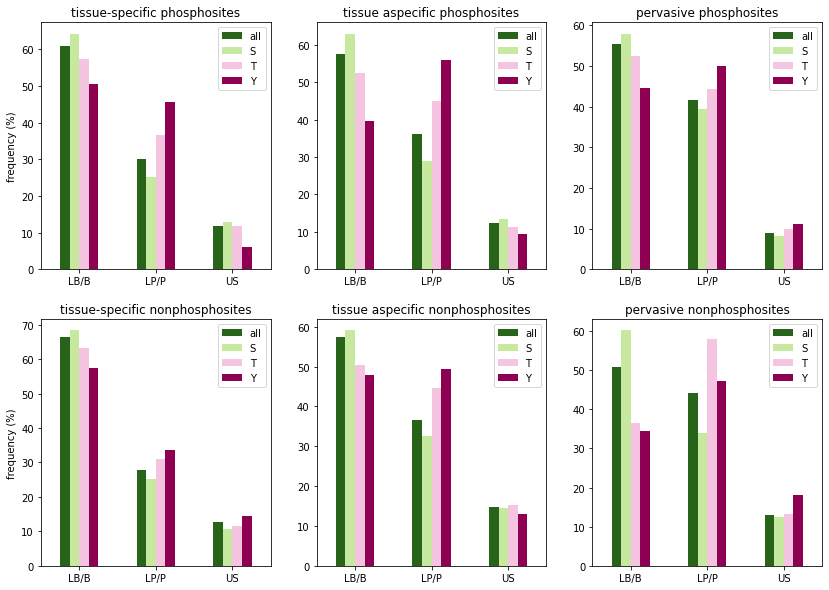

In [197]:
fig,ax = plt.subplots(2,3)

tspec_Psites_both.plot(ax = ax[0,0], kind = 'bar', x="consequence", xlabel="", ylabel = 'frequency (%)', figsize=(14, 10), rot=0, colormap="PiYG_r").set_title("tissue-specific phosphosites")
taspec_Psites_both.plot(ax = ax[0,1], kind = 'bar', x="consequence", xlabel="", figsize=(14, 10), rot=0, colormap="PiYG_r").set_title("tissue aspecific phosphosites")
pervasive_Psites_both.plot(ax = ax[0,2], kind = 'bar', x="consequence", xlabel="", figsize=(14, 10), rot=0, colormap="PiYG_r").set_title("pervasive phosphosites")
tspec_nonPsites_both.plot(ax = ax[1,0], kind = 'bar', x="consequence", xlabel="", ylabel = 'frequency (%)', figsize=(14, 10), rot=0, colormap="PiYG_r").set_title("tissue-specific nonphosphosites")
taspec_nonPsites_both.plot(ax = ax[1,1], kind = 'bar', x="consequence", xlabel="", figsize=(14, 10), rot=0, colormap="PiYG_r").set_title("tissue aspecific nonphosphosites")
pervasive_nonPsites_both.plot(ax = ax[1,2], kind = 'bar', x="consequence", xlabel="", figsize=(14, 10), rot=0, colormap="PiYG_r").set_title("pervasive nonphosphosites")


#plt.savefig("Humsavar_comparison STYsites_annot2.png", format="png", bbox_inches="tight")
plt.show()

In [198]:
tspec_Psites_both

,consequence,all,S,T,Y
0,LB/B,61.032258,64.185111,57.360406,50.617284
1,LP/P,30.193548,25.150905,36.548223,45.679012
2,US,11.870968,12.877264,11.675127,6.172840


In [199]:
tspec_nonPsites_both

,consequence,all,S,T,Y
0,LB/B,66.396761,68.313953,63.146067,57.489879
1,LP/P,27.732794,25.290698,31.011236,33.603239
2,US,12.854251,10.610465,11.685393,14.574899


In [200]:
taspec_Psites_both

,consequence,all,S,T,Y
0,LB/B,57.558140,62.895928,52.50,39.534884
1,LP/P,36.046512,28.959276,45.00,55.813953
2,US,12.500000,13.574661,11.25,9.302326


In [201]:
taspec_nonPsites_both

,consequence,all,S,T,Y
0,LB/B,57.352941,59.040590,50.261780,47.826087
1,LP/P,36.519608,32.472325,44.502618,49.275362
2,US,14.705882,14.391144,15.183246,13.043478


In [202]:
pervasive_Psites_both

,consequence,all,S,T,Y
0,LB/B,55.309735,57.823129,52.459016,44.444444
1,LP/P,41.592920,39.455782,44.262295,50.000000
2,US,8.849558,8.163265,9.836066,11.111111


In [203]:
pervasive_nonPsites_both

,consequence,all,S,T,Y
0,LB/B,50.833333,60.130719,36.363636,34.545455
1,LP/P,44.166667,33.986928,57.851240,47.272727
2,US,12.916667,12.418301,13.223140,18.181818


The same is done in absolute numbers.

In [204]:
list_consequences = ["LB/B", "LP/P", "US"]

tspec_Psites_both_abs = pd.DataFrame({"consequence": list_consequences})
list_all = []
list_S = []
list_T = []
list_Y = []
for con in list_consequences:
    count_all = tspec_sites_Psites.loc[tspec_sites_Psites["Variant category"]==con, :].groupby(["ACC_ID", "UP_POS"],
                                                                                               as_index=False).agg({
        "modres": "first"}).shape[0]*100/tspec_sites_Psites.groupby(["ACC_ID", "UP_POS"],as_index=False).agg({
        "modres": "first"}).shape[0]
    count_S = tspec_sites_Psites.loc[(tspec_sites_Psites["Variant category"]==con)&(
    tspec_sites_Psites["modres_S"]==1), :].groupby(["ACC_ID", "UP_POS"], as_index=False).agg({"modres": "first"}).shape[0]
    count_T = tspec_sites_Psites.loc[(tspec_sites_Psites["Variant category"]==con)&(
    tspec_sites_Psites["modres_T"]==1), :].groupby(["ACC_ID", "UP_POS"], as_index=False).agg({"modres": "first"}).shape[0]
    count_Y = tspec_sites_Psites.loc[(tspec_sites_Psites["Variant category"]==con)&(
    tspec_sites_Psites["modres_Y"]==1), :].groupby(["ACC_ID", "UP_POS"], as_index=False).agg({"modres": "first"}).shape[0]
    list_all.append(count_all)
    list_S.append(count_S)
    list_T.append(count_T)
    list_Y.append(count_Y)
tspec_Psites_both_abs["all"] = list_all
tspec_Psites_both_abs["S"] = list_S
tspec_Psites_both_abs["T"] = list_T
tspec_Psites_both_abs["Y"] = list_Y


taspec_Psites_both_abs = pd.DataFrame({"consequence": list_consequences})
list_all = []
list_S = []
list_T = []
list_Y = []
for con in list_consequences:
    count_all = taspec_sites_Psites.loc[taspec_sites_Psites["Variant category"]==con, :].groupby(["ACC_ID", "UP_POS"],
                                                                                               as_index=False).agg({
        "modres": "first"}).shape[0]*100/taspec_sites_Psites.groupby(["ACC_ID", "UP_POS"],as_index=False).agg({
        "modres": "first"}).shape[0]
    count_S = taspec_sites_Psites.loc[(taspec_sites_Psites["Variant category"]==con)&(
    taspec_sites_Psites["modres_S"]==1), :].groupby(["ACC_ID", "UP_POS"], as_index=False).agg({"modres": "first"}).shape[0]
    count_T = taspec_sites_Psites.loc[(taspec_sites_Psites["Variant category"]==con)&(
    taspec_sites_Psites["modres_T"]==1), :].groupby(["ACC_ID", "UP_POS"], as_index=False).agg({"modres": "first"}).shape[0]
    count_Y = taspec_sites_Psites.loc[(taspec_sites_Psites["Variant category"]==con)&(
    taspec_sites_Psites["modres_Y"]==1), :].groupby(["ACC_ID", "UP_POS"], as_index=False).agg({"modres": "first"}).shape[0]
    list_all.append(count_all)
    list_S.append(count_S)
    list_T.append(count_T)
    list_Y.append(count_Y)
taspec_Psites_both_abs["all"] = list_all
taspec_Psites_both_abs["S"] = list_S
taspec_Psites_both_abs["T"] = list_T
taspec_Psites_both_abs["Y"] = list_Y


pervasive_Psites_both_abs = pd.DataFrame({"consequence": list_consequences})
list_all = []
list_S = []
list_T = []
list_Y = []
for con in list_consequences:
    count_all = gen_sites_Psites.loc[gen_sites_Psites["Variant category"]==con, :].groupby(["ACC_ID", "UP_POS"],
                                                                                               as_index=False).agg({
        "modres": "first"}).shape[0]*100/gen_sites_Psites.groupby(["ACC_ID", "UP_POS"],as_index=False).agg({
        "modres": "first"}).shape[0]
    count_S = gen_sites_Psites.loc[(gen_sites_Psites["Variant category"]==con)&(
    gen_sites_Psites["modres_S"]==1), :].groupby(["ACC_ID", "UP_POS"], as_index=False).agg({"modres": "first"}).shape[0]
    count_T = gen_sites_Psites.loc[(gen_sites_Psites["Variant category"]==con)&(
    gen_sites_Psites["modres_T"]==1), :].groupby(["ACC_ID", "UP_POS"], as_index=False).agg({"modres": "first"}).shape[0]
    count_Y = gen_sites_Psites.loc[(gen_sites_Psites["Variant category"]==con)&(
    gen_sites_Psites["modres_Y"]==1), :].groupby(["ACC_ID", "UP_POS"], as_index=False).agg({"modres": "first"}).shape[0]
    list_all.append(count_all)
    list_S.append(count_S)
    list_T.append(count_T)
    list_Y.append(count_Y)
pervasive_Psites_both_abs["all"] = list_all
pervasive_Psites_both_abs["S"] = list_S
pervasive_Psites_both_abs["T"] = list_T
pervasive_Psites_both_abs["Y"] = list_Y

In [205]:
list_consequences = ["LB/B", "LP/P", "US"]

tspec_nonPsites_both_abs = pd.DataFrame({"consequence": list_consequences})
list_all = []
list_S = []
list_T = []
list_Y = []
for con in list_consequences:
    count_all = tspec_sites_nonPsites.loc[tspec_sites_nonPsites["Variant category"]==con, :].groupby(["ACC_ID", "UP_POS"],
                                                                                               as_index=False).agg({
        "modres": "first"}).shape[0]*100/tspec_sites_nonPsites.groupby(["ACC_ID", "UP_POS"],as_index=False).agg({
        "modres": "first"}).shape[0]
    count_S = tspec_sites_nonPsites.loc[(tspec_sites_nonPsites["Variant category"]==con)&(
    tspec_sites_nonPsites["res"]=="S"), :].groupby(["ACC_ID", "UP_POS"], as_index=False).agg({"modres": "first"}).shape[0]
    count_T = tspec_sites_nonPsites.loc[(tspec_sites_nonPsites["Variant category"]==con)&(
    tspec_sites_nonPsites["res"]=="T"), :].groupby(["ACC_ID", "UP_POS"], as_index=False).agg({"modres": "first"}).shape[0]
    count_Y = tspec_sites_nonPsites.loc[(tspec_sites_nonPsites["Variant category"]==con)&(
    tspec_sites_nonPsites["res"]=="Y"), :].groupby(["ACC_ID", "UP_POS"], as_index=False).agg({"modres": "first"}).shape[0]
    list_all.append(count_all)
    list_S.append(count_S)
    list_T.append(count_T)
    list_Y.append(count_Y)
tspec_nonPsites_both_abs["all"] = list_all
tspec_nonPsites_both_abs["S"] = list_S
tspec_nonPsites_both_abs["T"] = list_T
tspec_nonPsites_both_abs["Y"] = list_Y


taspec_nonPsites_both_abs = pd.DataFrame({"consequence": list_consequences})
list_all = []
list_S = []
list_T = []
list_Y = []
for con in list_consequences:
    count_all = taspec_sites_nonPsites.loc[taspec_sites_nonPsites["Variant category"]==con, :].groupby(["ACC_ID", "UP_POS"],
                                                                                               as_index=False).agg({
        "modres": "first"}).shape[0]*100/taspec_sites_nonPsites.groupby(["ACC_ID", "UP_POS"],as_index=False).agg({
        "modres": "first"}).shape[0]
    count_S = taspec_sites_nonPsites.loc[(taspec_sites_nonPsites["Variant category"]==con)&(
    taspec_sites_nonPsites["res"]=="S"), :].groupby(["ACC_ID", "UP_POS"], as_index=False).agg({"modres": "first"}).shape[0]
    count_T = taspec_sites_nonPsites.loc[(taspec_sites_nonPsites["Variant category"]==con)&(
    taspec_sites_nonPsites["res"]=="T"), :].groupby(["ACC_ID", "UP_POS"], as_index=False).agg({"modres": "first"}).shape[0]
    count_Y = taspec_sites_nonPsites.loc[(taspec_sites_nonPsites["Variant category"]==con)&(
    taspec_sites_nonPsites["res"]=="Y"), :].groupby(["ACC_ID", "UP_POS"], as_index=False).agg({"modres": "first"}).shape[0]
    list_all.append(count_all)
    list_S.append(count_S)
    list_T.append(count_T)
    list_Y.append(count_Y)
taspec_nonPsites_both_abs["all"] = list_all
taspec_nonPsites_both_abs["S"] = list_S
taspec_nonPsites_both_abs["T"] = list_T
taspec_nonPsites_both_abs["Y"] = list_Y


pervasive_nonPsites_both_abs = pd.DataFrame({"consequence": list_consequences})
list_all = []
list_S = []
list_T = []
list_Y = []
for con in list_consequences:
    count_all = gen_sites_nonPsites.loc[gen_sites_nonPsites["Variant category"]==con, :].groupby(["ACC_ID", "UP_POS"],
                                                                                               as_index=False).agg({
        "modres": "first"}).shape[0]*100/gen_sites_nonPsites.groupby(["ACC_ID", "UP_POS"],as_index=False).agg({
        "modres": "first"}).shape[0]
    count_S = gen_sites_nonPsites.loc[(gen_sites_nonPsites["Variant category"]==con)&(
    gen_sites_nonPsites["res"]=="S"), :].groupby(["ACC_ID", "UP_POS"], as_index=False).agg({"modres": "first"}).shape[0]
    count_T = gen_sites_nonPsites.loc[(gen_sites_nonPsites["Variant category"]==con)&(
    gen_sites_nonPsites["res"]=="T"), :].groupby(["ACC_ID", "UP_POS"], as_index=False).agg({"modres": "first"}).shape[0]
    count_Y = gen_sites_nonPsites.loc[(gen_sites_nonPsites["Variant category"]==con)&(
    gen_sites_nonPsites["res"]=="Y"), :].groupby(["ACC_ID", "UP_POS"], as_index=False).agg({"modres": "first"}).shape[0]
    list_all.append(count_all)
    list_S.append(count_S)
    list_T.append(count_T)
    list_Y.append(count_Y)
pervasive_nonPsites_both_abs["all"] = list_all
pervasive_nonPsites_both_abs["S"] = list_S
pervasive_nonPsites_both_abs["T"] = list_T
pervasive_nonPsites_both_abs["Y"] = list_Y

In [206]:
tspec_Psites_both_abs

,consequence,all,S,T,Y
0,LB/B,61.032258,319,113,41
1,LP/P,30.193548,125,72,37
2,US,11.870968,64,23,5


In [207]:
tspec_nonPsites_both_abs

,consequence,all,S,T,Y
0,LB/B,66.396761,470,281,142
1,LP/P,27.732794,174,138,83
2,US,12.854251,73,52,36


In [208]:
taspec_Psites_both_abs

,consequence,all,S,T,Y
0,LB/B,57.558140,139,42,17
1,LP/P,36.046512,64,36,24
2,US,12.500000,30,9,4


In [209]:
taspec_nonPsites_both_abs

,consequence,all,S,T,Y
0,LB/B,57.352941,160,96,33
1,LP/P,36.519608,88,85,34
2,US,14.705882,39,29,9


In [210]:
pervasive_Psites_both_abs

,consequence,all,S,T,Y
0,LB/B,55.309735,85,32,8
1,LP/P,41.592920,58,27,9
2,US,8.849558,12,6,2


In [211]:
pervasive_nonPsites_both_abs

,consequence,all,S,T,Y
0,LB/B,50.833333,92,44,19
1,LP/P,44.166667,52,70,26
2,US,12.916667,19,16,10
